# Projet Back Office Crédit - Exploration des données

In [1]:
# Librairies nécessaires
# ---------------------------
# Calculs 
import numpy as np
import numpy.linalg as npl
import pandas as pd 
import datetime as dt
from collections import Counter
import phik
from phik import resources, report
import random

# Graphes
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Machine Learing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Système
import os

# Sauvegarde
import pickle as pkl

import warnings
warnings.filterwarnings('ignore')

## Description des jeux de données

**Edition du crédit en agence ou au backOffice ? => faire un nettoyage. Dépend de l'identifiant interne COEMEDI (si la personne est au backoffice ou en agence. Attendre que bertrand me sorte les codes pour savoir ceux qui sont au backOffice et ceux qui sont en agence).**

Les données de la CEMP disponibles pour ce projet sont constituées de la table  "crédits" et de la table "client". 

Les variables à prédire sont: 
- Le **délai** entre la date de l'accord du client déterminé par la signature du dossier (varible `DTINS`) et la date d'arrivée du crédit au backOffice `DATEDI`. En effet, lorsq'un client veut contracter un crédit, il monte un dossier. Lorsque ce dossier est conforme, il est accepté et le client signe le dossier. Une fois le dossier signé par le client, il arrive au backOffice. Ainsi, la réponse se calcule comme suit: `DELAI` = `DATEDI` - `DTINS` 

    
- Le **nombre de dossiers qui arrivent au backOffice** par jour ou par semaine. Pour cela, on calcule le nombre de `CODOSB` par jour ou par semaine en fonction de la date donnée par `DATEDI`. Les besoins du métier sont à la semaine (ils ont surtout besoin de connaître le nombre de dossiers qui arrivent par semaine.    

______________
Voici les données choisies  (<font color = 'red'>/.\ c'est différent de ce qu'avait fait Joan</font>): 
- Données crédits :

| Libellé    | Définition                                  |Variable retenue (V1) |Quanti (1)/Quali(0)/date(d) |
|------------|---------------------------------------------|----------------------|--------------------| 
| `COETB`    | Code Etablissement                          |                      |0                   |     
| `LIETB`    | Libellé Etablissement                       |X                     |0                   |       
| `CODOSB`   | Identifiant dossier bancaire                |X                     |0                   |
| `COCO`     | Identifiant contrat                         |X                     |0                   |
| `COPRO`    | Code produit local                          |                      |0                   |
| `LIPRLG`   | Libellé code produit local                  |                      |0                   |
| `COPROG`   | Identifiant produit groupe                  |X                     |0                   |
| `LIPRO`    | Libellé produit groupe                      |                      |0                   |
| `COOBJ`    | Code objet prêt                             |X                     |0                   |
| `LOBJ`     | Libellé du code objet prêt                  |                      |0                   |
| `MEDOS`    | Montant nominal du dossier                  |X                     |1                   |
| `TAINT`    | Taux intérêt                                |X                     |1                   |
| `TITEGI`   | TEG Initial prêt                            |X                     |1                   |
| `QLDDOS`   | Durée du prêt                               |X                     |1                   |
| `NBASSGPE` | Nbre Assurance Groupe                       |X                     |1                   |
| `NBASSEXT` | Nbre Assurance Externe                      |X                     |1                   |
| `NBGAR`    | Nbre de garantie(s)                         |X                     |1                   |
| `TOPPSC`   | Top prescription (O/N)                      |X                     |0                   | 
| `COFAAP`   | Code famille apporteur affaire              |                      |0                   | 
| `LIBLGG`   | Libellé long du CBO prescripteur            |                      |0                   | 
| `COPOST`   | Code postal du bien financé                 |X                     |0                   | 
| `CONSCE`   | Nbre de scénarios (Accord Banque à traiter) |X                     |1                   | 
| `DDDOSP`   | Date instruction à traiter                  |X                     |d                   | 
| `DTINS`    | Date instruction traitée                    |X                     |d                   | 
| `COEMINS`  | Identifiant employé instruction             |X                     |0                   | 
| `DATDEC`   | Date accord banque à traiter                |X                     |d                   | 
| `DTDEC`    | Date accord banque traitée                  |X                     |d                   | 
| `COEMDEC`  | Identifiant employé décision                |X                     |0                   | 
| `DATEDI`   | Date edition à traiter                      |X                     |d                   | 
| `DTEDI`    | Date édition traitée                        |X                     |d                   | 
| `COEMEDI`  | Identifiant employé édition                 |X                     |0                   | 
| `DELINS`   | Nbre jrs Instruction                        |X                     |1                   | 
| `DELDEC`   | Nbre jrs Décision                           |X                     |1                   | 
| `DELEDI`   | Nbre Jrs Edition                            |X                     |1                   | 
|`TOP_EDITION_BACK_OFFICE`| Crédit ayant transféré par le BackOffce |X            |0                   |
|`CODE_INDIC_PRM_ACCS`| Client primo accédant              |             |                    |


- Données clients : 

| Rubrique   | Libellé                                  |Variable retenue (V1) |Quanti (1)/ Quali (0)|
|------------|------------------------------------------|----------------------|---------------------| 
| `COETB`    | Code Etablissement                       |                      |0                    |
| `LIETB`    | Libellé Etablissement                    |                      |0                    |
| `COESRG`   | Code URA Région                          |                      |0                    |
| `LIESNLRG` | Libellé Région                           |                      |0                    |
| `COESSU`   | Code URA Succursale                      |v                     |0                    |
| `LIESNLSU` | Libellé Succursale                       |                      |0                    |
| `COES`     | Code URA Agence                          |X                     |0                    |
| `LIESNL`   | Libellé Agence                           |                      |0                    |
| `COPFCI`   | Code portefeuille                        |X                     |0                    |
| `COEMEM`   | Identifiant Conseiller                   |X                     |0                    |
| `CODOSB`   | Identifiant dossier bancaire             |X                     |0                    |
| `COMAX`    | Identifiant Client                       |X                     |0                    |
| `COPOST`   | Code Postal adresse postale client       |X                     |0                    |
| `DANAID`   | Age                                      |X                     |1                    |
| `CTSCPI`   | Catégorie Socio Professionnelle          |X                     |0                    |
| `CTREGM`   | Code Régime matrimonial                  |X                     |0                    |
| `CTSIFA`   | Code Situation Familiale                 |X                     |0                    |
| `QTENAC`   | Nbre d'enfants à charge                  |X                     |1                    |
| `CTCLOG`   | Condition de logement d'une PP           |X                     |0                    |
| `DMRELBJ`  | Ancienneté                               |X                     |1                    |
| `DAEMB`    | Date d'embauche                          |X                     |d                    |
| `CTCTRT`   | Type de contrat de travail               |X                     |0                    |
| `COSCOR`   | Cotation Bâle 2 (Mac Donough)            |X                     |0                    |
| `CEBPF1`   | Top produits Cartes et Conventions       |X                     |1                    | 
| `CEBPF2`   | Top produits Prévoyance                  |X                     |1                    | 
| `CEBPF3`   | Top produits Crédits CT                  |X                     |1                    | 
| `CEBPF4`   | Top produits Crédits MLT                 |X                     |1                    | 
| `CEBPF5`   | Top produits Epargne Liquide             |X                     |1                    | 
| `CEBPF6`   | Top produits Epargne MLT                 |X                     |1                    | 
| `CEBPF7`   | Top produits IARD                        |X                     |1                    | 
| `MCTOTA`   | Total des avoirs                         |X                     |1                    | 
| `NBCIMMO`  | Nombre de crédits immobiliesr en cours   |X                     |1                    | 
| `MTCDIM`   | Montant des crédits immobiliers en cours |X                     |1                    | 
| `MCMD12`   | Cumul mouvement net débiteurs 12 mois    |X                     |1                    | 
| `MCMC12`   | Cumul mouvement net créditeurs 12 mois   |X                     |1                    | 
| `NBENTCLI` | Nombre d'entretiens M-12                 |X                     |1                    | 

## Récupération des jeux de données

In [2]:
"""OK"""
# Variables globales & chemins absolus
# ------------------------------------
# Chemin du répertoire de travail (ajouter double \\)
PATH = "C:\\Users\\A3193307\\Groupe BPCE\\CEMP - Data & Décisionnel - Data Science\\Back office Crédit (Projet DMO)\\Back Office Credit version 4"
# Chemin des données
PATH_DATA = PATH + "/data"
# Chemin des scripts python .py
PATH_UTILS =  PATH + "/utilities"
# Chemin du dossier où sauvegarder les plots
PATH_PLOTS = PATH + "/plots"

In [3]:
# Récupération des jeux de données
# ------------------------------------
#--- dataset CEMP
credits_CEMP = pd.read_csv(PATH_DATA + "/CEMP - Données CREDITS.csv", encoding='utf8', sep=';')
clients_CEMP = pd.read_csv(PATH_DATA + "/CEMP - Données CLIENTS.csv", encoding='utf8', sep=';')

credits = credits_CEMP.copy()
clients = clients_CEMP.copy()
#--- dataset BPS

In [4]:
print("taille credits_CEMP: {} x {}".format(credits_CEMP.shape[0],credits_CEMP.shape[1]))
print("taille clients_CEMP: {} x {}".format(clients_CEMP.shape[0],clients_CEMP.shape[1]))

taille credits_CEMP: 61014 x 36
taille clients_CEMP: 71931 x 36


## Prétraitement données Crédit

In [5]:
credits_CEMP.head()

,COETB,LIETB,CODOSB,COCO,COPRO,LIPRLG,COPROG,LIPRO,COOBJ,LOBJ,...,COEMDEC,DATEDI,DTEDI,COEMEDI,DELINS,DELDEC,DELEDI,TOP_EDITION_BACK_OFFICE,CODE_INDIC_PRM_ACCS,MEDOS
0,13135,MIDI PYRENEES,E6506328,5229015,PRM001,PRIMO SIMPLE,G1511,PRET IMMO LIBRE,3.0,REPARATION ENTRETIEN AMENAGEMENT,...,601614,2018-01-08 00:00:00,2018-01-08 00:00:00,612456.0,0.0,0.0,0.0,1,N,30000.00
1,13135,MIDI PYRENEES,E6506328,5229016,PRM001,PRIMO SIMPLE,G1511,PRET IMMO LIBRE,3.0,REPARATION ENTRETIEN AMENAGEMENT,...,601614,2018-01-08 00:00:00,2018-01-08 00:00:00,612456.0,0.0,0.0,0.0,1,N,40000.00
2,13135,MIDI PYRENEES,E6524515,5237382,PRM001,PRIMO SIMPLE,G1511,PRET IMMO LIBRE,21.0,CONSTRUCTION MAISON + TERRAIN,...,705868,2018-01-18 00:00:00,2018-01-25 00:00:00,612456.0,2.0,0.0,7.0,1,N,133144.00
3,13135,MIDI PYRENEES,E6524515,5237383,PRM003,PRIMOLIS,G1511,PRET IMMO LIBRE,21.0,CONSTRUCTION MAISON + TERRAIN,...,705868,2018-01-18 00:00:00,2018-01-25 00:00:00,612456.0,2.0,0.0,7.0,1,N,119057.89
4,13135,MIDI PYRENEES,E6535374,5262903,PRM001,PRIMO SIMPLE,G1511,PRET IMMO LIBRE,5.0,SOUSCRIPTION APPARTEMENT NEUF,...,706236,2018-03-22 00:00:00,2018-03-22 00:00:00,647009.0,52.0,173.0,0.0,1,N,268194.85


In [6]:
"""OK"""
# Définition du type des variables crédit
# ------------------------------------
# variables quantitatives
VAR_QUANTI_CREDIT = ['MEDOS','TAINT','TITEGI','QLDDOS','NBASSGPE','NBASSEXT','NBGAR','DELINS','DELDEC','DELEDI','CONSCE']
# variables dates
VAR_DATE_CREDIT = ['DATEDI','DTEDI','DDDOSP','DTINS','DATDEC','DTDEC']
# variables qualitatives 
VAR_QUALI_CREDIT = ['LIETB','CODOSB','COCO','COPROG','COOBJ','TOPPSC','COPOST','COEMINS','COEMDEC','COEMEDI','LIBLGG']

In [7]:
# à installer avec pip après avoir configuré pip.ini -> voir le OneNote 
#from pandas_profiling import ProfileReport 
#profile = ProfileReport(credits[["LIBLGG","TAINT"]])

### Premières transformations variables

In [8]:
"""OK"""
def special_treatment(df_credits):
    """
    Cette fonction applique un traitement spécial à certaines variables
    fixées dans la fonction.
    
    Input:
    ------
    - df_credits (dataframe): dataframe crédits contenant les données.
    
    Output:
    ------
    - df (dataframe): dataframe transformée.  
    """
    df = df_credits.copy()
    
    # Suppression des colonnes non nécessaires
    # -----------------------------
    # Suppression de [COETB,LOBJ,COFAAP] car équivalents respectivement à [LIETB,COOBJ,LIBLGG] que l'on garde.
    # COPRO et LIPRLG (id locaux) peuvent être remplacés COPROG et LIPRO (id du groupe).
    # Suppression de LIPRO qui est équivalent à COPROG que l'on garde.
    # 'CODE_INDIC_PRM_ACCS' est utile pour un autre projet dataScience mais inutile ici.
    # -----------------------------
    DEL_CREDIT = ['COETB','COPRO','LIPRLG','LOBJ','COFAAP','LIPRO','CODE_INDIC_PRM_ACCS'] #variables à supprimer
    df.drop(DEL_CREDIT, axis=1,inplace=True)
  
    # Suprpression des lignes ne contenant que des valeurs NaN (il n'y en a pas pour le moment)
    # -----------------------------
    df.dropna(how='all',inplace = True)
  
    # Variable LIBLGG
    # -----------------------------
    # La variable LIBLGG est le nom du prescripteur. Comme il y a trop de modalités,
    # on transforme cette variable avec seulement la présence ou non d'un prescripteur. 
    # Attention, le fait de binariser cette variable crée des duplicates ce qui veut
    # dire qu'un même contrat (variable 'COCO') peut avoir différents prescripteurs. 
    # -----------------------------
    df["LIBLGG"][df["LIBLGG"].notna()] = 1 #présence d'un prescripteur
    df["LIBLGG"][df["LIBLGG"].isna()]  = 0 #valeur NaN donc pas de prescripteur
    
    # Suppression des lignes identiques (il y en a 971 pour le moment)
    # --------------------------------
    # Le fait d'avoir appliqué le traitement sur 'LIBLGG' ci-dessus
    # a créé des duplicates
    # --------------------------------
    df.drop_duplicates(inplace=True)
    
    # Variable CONSCE
    # -----------------------------
    # La variable CONSCE est le nb d'intéractions entre l'agence et le backOffice
    # lorsqu'un dossier n'est pas valide du premier coup. 
    # On peut donc mettre les valeurs NaN à 0 par défaut. 
    # -----------------------------
    df['CONSCE'][df['CONSCE'].isna()] = 0 #### METTRE DANS UNE FONCTION FILL_NA DEDIEE ? #####
    
    
    # Variable TOP_EDITION_BACK_OFFICE
    # -----------------------------
    # La variable TOP_EDITION_BACK_OFFICE indique si le dossier a transité ou non par le 
    # backOffice. Comme on veut prédire un délai pour le backOffice, on enlève toutes les 
    # lignes qui ne sont pas passées par le backOffice.
    # -----------------------------
    # indices des lignes qui ont TOP_EDITION_BACK_OFFICE = 0
    del_idx = df.index[df['TOP_EDITION_BACK_OFFICE'] == 0]
    # on supprime les indices del_idx
    df.drop(axis=0,index=del_idx,inplace=True)
    # on réindexe depuis 0
    df.reset_index(inplace=True,drop=True)
    # supprime la colonne TOP_EDITION_BACK_OFFICE
    df.drop(['TOP_EDITION_BACK_OFFICE'],axis=1,inplace=True)
    
    return df

In [9]:
credits = special_treatment(credits)

In [10]:
print("taille credits: {} x {}".format(credits.shape[0],credits.shape[1]))

taille credits: 42659 x 28


Justificatif de suppression des variables:
- `COETB`: Code Etablissement $\rightarrow$ toujours identique. Idem que `LIETB` que l'on garde.
- `COPRO` et `LIPRLG`: Code produit local et Libellé code produit local $\rightarrow$  on ne garde que `COPROG` et `LIPRO`qui sont les identifiant produit groupe et Libellé produit groupe. Ce sont les équivalents de `COPRO` et `LIPRLG` mais dont les dénominations sont harmonisées au niveau du groupe. 
- `LOBJ`: idem que `COOBJ` que l'on garde.
- `COFAAP` et `LIBLGG`: <font color = 'red'> je ne sais pas pourquoi Joan a supprimé. LIBLGG: prescripteur: calculer si présence ou non d'un preescripteur car trop de levels.</font>

<font color = 'red'> **Attention, le fait de binariser la variable 'LIBLGG' crée 1384 duplicates ce qui veut dire qu'un même contrat (variable 'COCO') peut avoir différents prescripteurs.** 

**Transformer les variables int en integer et ne pas les laisser en floats**

### Variables quantitatives 

In [11]:
# types des variables
# --------------------
credits[VAR_QUANTI_CREDIT].dtypes

MEDOS       float64
TAINT       float64
TITEGI      float64
QLDDOS        int64
NBASSGPE    float64
NBASSEXT    float64
NBGAR       float64
DELINS      float64
DELDEC      float64
DELEDI      float64
CONSCE      float64
dtype: object

In [12]:
credits[VAR_QUANTI_CREDIT].describe()

,MEDOS,TAINT,TITEGI,QLDDOS,NBASSGPE,NBASSEXT,NBGAR,DELINS,DELDEC,DELEDI,CONSCE
count,4.265900e+04,42659.000000,42659.000000,42659.000000,41857.000000,41857.000000,40048.000000,42342.000000,42342.000000,42659.000000,42659.000000
mean,1.145305e+05,1.179232,1.764406,231.773647,1.476312,1.756910,1.864612,9.350054,35.968849,15.677067,2.012307
std,1.163107e+05,0.578095,0.669766,78.227510,1.939825,2.290681,0.957325,22.845271,45.011666,19.437022,2.096764
min,1.500000e+02,0.000000,0.000000,5.000000,0.000000,0.000000,1.000000,0.000000,-5.000000,0.000000,0.000000
25%,4.000000e+04,0.954100,1.465390,180.000000,0.000000,0.000000,1.000000,0.000000,5.000000,5.000000,1.000000
50%,9.200000e+04,1.206600,1.834440,240.000000,1.000000,0.000000,2.000000,0.000000,24.000000,10.000000,1.000000
75%,1.567452e+05,1.510300,2.192750,300.000000,2.000000,3.000000,2.000000,7.000000,49.000000,20.000000,3.000000
max,7.650915e+06,4.970000,6.656720,360.000000,18.000000,16.000000,11.000000,362.000000,794.000000,364.000000,35.000000


#### Variables nulles & variables manquantes

In [13]:
"""OK"""
# Calcul des données manquantes & données nulles
# -------------------------------------------
def plot_na_null(df,var,fig_size,plot_null:bool):
    """
    Cette fonction trace pour chaque variable le pourcentage et le nombre 
    de valeurs manquantes et de valeurs nulles présentes dans le dataframe df.

    Input:
    ------
    - df (dataframe): dataframe contenant les données.
    - var (list): liste des variables pour lesquelles chercher les valeurs
      manquantes ou nulles. 
    - fig_size (list): liste de 2 valeurs indiquant la taille 
      des subplots. 
    - plot_null (bool): si False, on ne trace que les valeurs manquantes.  
    
    Output:
    ------
    - Graphiques.
    """

    d_na = {}    #dict contenant le pourcentage de données NaN pour chaque variable   
    d_na_2 =  {} #dict contenant le nb de données NaN pour chaque variable   
    d_null = {}   #dict contenant le pourcentage de données nulles pour chaque variable  
    d_null_2 = {} #dict contenant le nb de données nulles pour chaque variable   

    # Calcul du %  et du nb de valeurs manquantes et de valeurs nulles
    for v in var:
        nb_na = round(len(np.where(df[v].isna())[0])/len(df)*100,4) #pourcentage
        nb_na_2 = len(np.where(df[v].isna())[0]) #valeur réelle
        d_na[v] = nb_na 
        d_na_2[v] = nb_na_2

        if plot_null: #si plot_null, on calcule le nb et le % de valeurs nulles 
            nb_null = round(len(np.where(df[v]==0.0)[0])/len(df)*100,4) #pourcentage
            nb_null_2 = len(np.where(df[v]==0.0)[0]) #valeur réelle
            d_null[v] = nb_null
            d_null_2[v] = nb_null_2


    # Plot des données manquantes & données nulles
    # -------------------------------------------    
    if plot_null: 
        fig, axs = plt.subplots(2, 1, figsize=(fig_size[0], fig_size[1]))
        fig.subplots_adjust(hspace=.5)

        #---- Valeurs manquantes 
        axs[0].bar(d_na.keys(), d_na.values(), width=.3, color='b',alpha=.3)
        axs[0].set_xticklabels(d_na.keys(), rotation = 45, ha="right")
        axs[0].grid(linestyle=':')
        axs[0].set_title("Pourcentage de valeurs manquantes pour chaque variable")
        axs[0].set_ylabel("pourcentage"); axs[0].set_xlabel("variables")
        axs[0].spines[['right', 'top', 'bottom', 'left']].set_visible(False)
        # Affiche le nb de valeurs NaN au dessus des plots
        j = 0
        for index,data in enumerate(d_na_2.values()):
            axs[0].text(x=index-0.2,y =list(d_na.values())[j],s=f"{data}",
                        fontdict=dict(fontsize=10),color='b',alpha=.7)
            j+=1

        #---- Valeurs nulles 
        axs[1].bar(d_null.keys(), d_null.values(), width=.3, color='g',alpha=.3)
        axs[1].set_xticklabels(d_null.keys(), rotation = 45, ha="right")
        axs[1].grid(linestyle=':')
        axs[1].set_title("Pourcentage de valeurs nulles pour chaque variable")
        axs[1].set_ylabel("pourcentage"); axs[1].set_xlabel("variables")
        axs[1].spines[['right', 'top', 'bottom', 'left']].set_visible(False)
        # Affiche le nb de valeurs NaN au dessus des plots
        j = 0
        for index,data in enumerate(d_null_2.values()):
            axs[1].text(x=index-0.2, y =list(d_null.values())[j],s=f"{data}",
                        fontdict=dict(fontsize=10),color='g')
            j+=1

    # Plot des données manquantes uniquement
    # -------------------------------------------  
    else: 
        fig, axs = plt.subplots(1,1, figsize=(fig_size[0], fig_size[1]))
        axs.bar(d_na.keys(), d_na.values(), width=.3, color='b',alpha=.3)
        axs.set_xticklabels(d_na.keys(), rotation = 45, ha="right")
        axs.grid(linestyle=':')
        axs.set_title("Pourcentage de valeurs manquantes pour chaque variable")
        axs.set_ylabel("pourcentage"); axs.set_xlabel("variables")
        axs.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
    # Affiche le nb de valeurs NaN au dessus des plots
        j = 0
        for index,data in enumerate(d_na_2.values()):
            axs.text(x=index-0.2,y =list(d_na.values())[j],s=f"{data}",
                        fontdict=dict(fontsize=10),color='b',alpha=.7)
            j+=1


    plt.show()

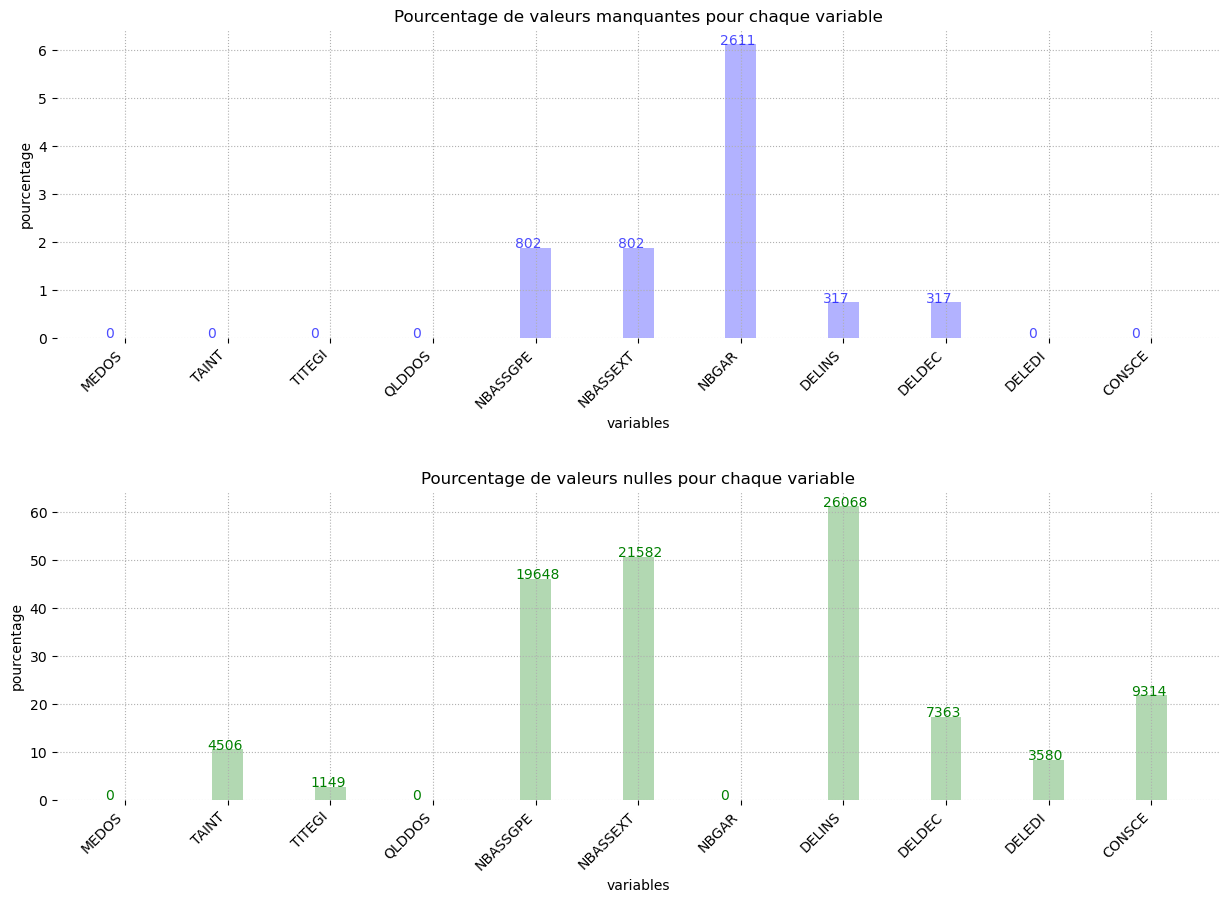

In [14]:
plot_na_null(credits,VAR_QUANTI_CREDIT,fig_size=[15,10],plot_null=True)

=> <font color = 'red'> **Les zéros sont ils des données manquantes ou des vrais 0 ?**
    
**Observations:**
    
- La variable `CONSCE` a originellement 50% de donnés manquantes. Cependant, d'après Bertrand, il s'agit  du nombre d'intéractions entre l'agence et le back Office lorsqu'un dossier n'est pas valide du premier coup. On a donc mis les valeurs NaN à 0 par défaut. 
- Les variables `DELINS`, `DELDEC` et `DELEDI` sont des nombres de jours. Nous allons regarder par la suite si ces variables ont des 0 aux même endroit ce qui pourrait indiquer que ces 0 correspondent à des données manquantes.
- Les variables `NBASSGPE` et `NBASSEXT` sont ne nombre d'assurance groupe et le nomdre d'assurance Externe. Il se pourrait que ces 0 soient de vrais 0 (quand un client ne possède aucune assurance). Un client possède soit une assurance externe, soit une assurance de groupe. 

In [15]:
# Regarder si 'DELINS','DELDEC','DELEDI' ont des 0 au mêmes endroits
# ----------------------------------------------------
var = ['DELINS','DELDEC','DELEDI'] 
df_3_var = credits[var]
#ajouter une colonne qui contient la somme des 3 premières colonnes :
#(les NaN ne sont pas compris dans la somme)
df_3_var['sum'] =  df_3_var[var].sum(axis = 1) 

#nombre de lignes de df_3_var contenant au moins 1 zéro
n_1Zero = len(df_3_var.iloc[np.unique(np.where(df_3_var[var]==0.0)[0])])

#nombre de lignes de df_3_var où toutes les valeurs sont nulles
n_allZero = len(df_3_var[df_3_var['sum'] == 0])

print("{} valeurs pour les variables 'DELINS','DELDEC','DELEDI' contienent au moins 1 zéro sur {} valeurs au total.".format(str(n_1Zero),str(len(df_3_var))))
print("=> soit {} %".format(str(round(n_1Zero/len(df_3_var)*100,3))))      
      
print("{} valeurs pour les variables 'DELINS','DELDEC','DELEDI' sont toutes nulles sur {} valeurs au total.".format(str(n_allZero),str(len(df_3_var))))
print("=> soit {} %".format(str(round(n_allZero/len(df_3_var)*100,3))))      

29859 valeurs pour les variables 'DELINS','DELDEC','DELEDI' contienent au moins 1 zéro sur 42659 valeurs au total.
=> soit 69.995 %
795 valeurs pour les variables 'DELINS','DELDEC','DELEDI' sont toutes nulles sur 42659 valeurs au total.
=> soit 1.864 %


**Observations:**
    
- Seulement 5% des variables `DELINS`,`DELDEC`,`DELEDI` sont nulles au même endroit. 

#### Histogrammes & Boxplots

Pour le tracé des histogrammes, on supprime les valeurs manquantes `NaN` sinon cela fausse les histogrammes.

In [16]:
"""OK"""
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
    - https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting
    - Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
      Handle Outliers", The ASQC Basic References in Quality Control:
      Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [17]:
"""OK"""
# Histogrammes ou boxplot de toutes les variables quantitatives
# --------------------------------------------------
def plot_hist_box(df,var,type_plot,layout=[3,4],fig_size=[20,20]):
    """
    Cette fonction trace les histogrammes ou les boxplots des variables 
    var du dataframe df. Requiert la fonction is_outlier qui enlève 
    les outliers pour le tracé des histogrammes afin de ne pas applatir 
    le graphe. 

    Input:
    ------
    - df (dataframe): dataframe contenant les données.
    - var (list): liste des variables quantitatives pour lesquelles tracer
      les histogrammes ou les boxplots
    - type_plot (str): prend les valeurs 'hist' ou 'box' et indique si 
      on trace les histogrammes ou les boxplots.
    - layout (list): liste de 2 valeurs indiquant la disposition des 
      subplots. Par exemple, pour tracer 10 histogrammes, on peut 
      entrer layout = [5,2] et on aura une matrice 5x2 de plots. 
    - fig_size (list): liste de 2 valeurs indiquant la taille 
      des subplots. 

    Output:
    ------
    - Graphiques.

    Reference:
    ---------
    https://stackoverflow.com/questions/17210646/python-subplot-
    within-a-loop-first-panel-appears-in-wrong-position
    """


    if type_plot == 'hist':
        kind = 'Histogramme'
    elif type_plot == 'box':
        kind = 'Boxplot'
    else:
        print("Pour type_plot entrer 'hist' ou 'box'")

    fig, axs = plt.subplots(layout[0],layout[1], figsize=(fig_size[0], fig_size[1]))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(kind + " des variables quantitatives", fontsize=16, y=0.95)
    axs = axs.ravel()

    #---- Parcourt les variables et trace leur histogramme
    i=0
    for v in var:
        if type_plot == 'hist':
            df_v = df[v][~is_outlier(df[v])] #colonne de la variable v sans les outliers
            sns.histplot(ax=axs[i], data=df_v, edgecolor='w',alpha=0.6)
        elif type_plot == 'box':
            df_v = df[v]
            sns.boxplot(ax=axs[i], data=df_v, saturation=0.75,
            flierprops = dict(markerfacecolor = '0.5', markersize = 3))
        axs[i].set_title(kind + " de " + v)
        axs[i].tick_params(axis='x', rotation=45)
        axs[i].spines[['right', 'top', 'bottom', 'left']].set_visible(False)
        i+=1
    
    n_var = len(var); n_plots = layout[0]*layout[1]
    if n_plots > n_var:
        for a in range(n_var,n_plots):
                fig.delaxes(axs[a])
    plt.show()

In [18]:
#plot_hist_box(credits,VAR_QUANTI_CREDIT,type_plot='hist',layout=[3,4])

<font color = 'red'> **=> appliquer des transformations sur les données pour les rendre + gaussiennes ?** </font>

In [19]:
#plot_hist_box(credits,VAR_QUANTI_CREDIT,type_plot='box',layout=[3,4])

In [20]:
"""OK"""
# Tracé des pairplots pour les variables quantitatives
# -----------------------------------
def plot_pairs(df,var,fig_size,save_path=None,save_name=None):
    """
    Cette fonction trace les pairplots pour les variables*
    quantitatives var de la dataframe df.  
    
    Input:
    ------
    - df (dataframe): dataframe contenant les données.
    - var (list): liste des variables quantitatives pour lesquelles tracer
      les graphe
    - fig_size (list): liste de 2 valeurs indiquant la taille 
      des subplots. 
    - save_path (str): chemin du dossier vers lequel sauvegarder 
      les graphes. Si none, les graphes ne sont pas sauvegardés. 
    - save_name (str): nom du graphe sauvegardé.

    Output:
    ------
    - Graphiques.
    """
    # Tracé des graphiques
    sns.set_style('darkgrid')
    g = sns.pairplot(data=df[var], diag_kind='hist', palette='CMRmap_r',diag_kws={'color':'green'},plot_kws={"s": 8})
    g.fig.suptitle("Pairplot des variables quantitatives", y=1.08,fontsize=18) 
    g.fig.set_size_inches(fig_size[0],fig_size[1])
    
    # Sauvegarde
    if save_path:
        g.figure.savefig(save_path + '/' + save_name + ".png")

In [21]:
"""plot_pairs(credits,VAR_QUANTI_CREDIT,fig_size=[20,20],
           save_path=PATH_PLOTS,save_name="credit_pairs_quanti")"""

'plot_pairs(credits,VAR_QUANTI_CREDIT,fig_size=[20,20],\n           save_path=PATH_PLOTS,save_name="credit_pairs_quanti")'

**Observations**: 

- On avec graphique, on voit que peu de variables sont corrélées. Les seulves variables qui semblent corrélées entre elles sont: `TAINT`(Taux intérê) et `TITEGI` (TEG Initial prêt) ainsi que `NBASSGPE` (Nbre Assurance Groupe) et `NBASSEXT` (Nbre Assurance Externe)

In [22]:
"""OK"""
# Permet de regarder un histogramme en particulier
# --------------------------------------------------
def plot_1_hist_box(df,var):
    """
    Cette fonction trace l'histogramme et le boxplot de la variable 
    var du dataframe df. Requiert la fonction is_outlier qui enlève 
    les outliers pour le tracé des histogrammes afin de ne pas applatir 
    le graphe. 

    Input:
    ------
    - df (dataframe): dataframe contenant les données.
    - var (str): variable quantitative pour laquelle tracer
      l'histogramme et le boxplot.

    Output:
    ------
    - Graphique.

    Reference:
    ---------
    https://stackoverflow.com/questions/17210646/python-subplot-
    within-a-loop-first-panel-appears-in-wrong-position
    """
         
    fig, axs = plt.subplots(1,2,figsize=(10, 4),gridspec_kw={'width_ratios':[2,1]})
    fig.suptitle(" Histogramme & Boxplot de " + var, fontsize=16, y=0.95)    
    # tracé histograme
    df_v = df[var][~is_outlier(df[var])] #colonne de la variable v sans les outliers
    sns.histplot(ax=axs[0], data=df_v, edgecolor='w',alpha=0.6)
    # tracé boxplot
    df_v = df[var]
    sns.boxplot(ax=axs[1], data=df_v, saturation=0.75,
                flierprops = dict(markerfacecolor = '0.5', markersize = 3))
        
    sp = ['right', 'top', 'bottom', 'left']
    axs[0].spines[sp].set_visible(False); axs[1].spines[sp].set_visible(False)
    axs[0].grid(linestyle = ':'); axs[1].grid(linestyle = ':')
    plt.show()

In [23]:
#plot_1_hist_box(credits,'DELINS')

#### Corrélations 

_____
**Les différents types de corrélations**:

The correlation is a value between -1 and +1, -1 indicating total negative monotonic correlation, 0 indicating no monotonic correlation and 1 indicating total positive monotonic correlation.

- <font color = 'blue'> Pearson's r </font> : The Pearson's correlation coefficient (r) measures the degree of the relationship between **linearly related variables**. Furthermore, r is invariant under separate changes in location and scale of the two variables. This correlation is based on the values and is sensitive to outliers. To calculate r for two variables X and Y, one divides the covariance of X and Y by the product of their standard deviations.

- <font color = 'blue'> Spearman's ρ </font>: The Spearman's rank correlation coefficient (ρ) is a measure of **monotonic correlation** between two variables, and is therefore better in catching **nonlinear monotonic correlations** than Pearson's r.  The Spearman test is based on ranks and does not carry any assumptions about the distribution of the data and is the appropriate correlation analysis when the variables are measured on a scale that is at least ordinal. To calculate ρ for two variables X and Y, one divides the covariance of the rank variables of X and Y by the product of their standard deviations. 

- <font color = 'blue'> Kendall's τ </font> : Similarly to Spearman's rank correlation coefficient. Is is an alternative to Spearman's, allowing better management of ex-æquos but also being more pessimistic. 

- <font color = 'blue'> Phik (φk) </font> : new and practical correlation coefficient that has the same characteristics as Pearson's but works consistently between categorical, ordinal and interval variables, captures non-linear dependency. Paper: https://arxiv.org/abs/1811.11440 (2018). It is based on several refinements to Pearson’s χ2 (chi-squared) contingency test (a hypothesis test for independence between two (or more) variables).

$\Rightarrow$ On utilisera `spearman` et `phik`.
_____

In [24]:
"""OK"""
def plot_corr(df,var,type_corr,fig_size=[8,6],save_path=None,save_name=None):
    """
    Cette fonction trace la matrice de corrélation pour les variables
    quantitatives var du dataframe df. Le type de corrélation choisi
    est indiqué par type_corr.
    /.\ Attention, la corrélation phik est très longue à run.
        Il faut au préalable avoir transformé les variables 
        qualitatives en categorical. 
    
     Input:
    ------
    - df (dataframe): dataframe contenant les données.
    - var (list): liste des variables quantitatives pour lesquelles tracer
      le graphe.
    - type_corr (str): type de corrélation à tracer. Peut prendre 
      les valeurs 'pearson','kendall','spearman','phik'. 
    - fig_size (list): liste de 2 valeurs indiquant la taille 
      des subplots. 
    - save_path (str): chemin du dossier vers lequel sauvegarder 
      les graphes. Si none, les graphes ne sont pas sauvegardés. 
    - save_name (str): nom du graphe sauvegardé. 

    Output:
    ------
    - Graphiques.
    
    # =========================== Notes ============================
    Les différents types de corrélations:
    The correlation is a value between -1 and +1, -1 indicating total negative 
    monotonic correlation, 0 indicating no monotonic correlation and 1 indicating 
    total positive monotonic correlation.

    - Pearson's r : The Pearson's correlation coefficient (r) measures the degree
      of the relationship between linearly related variables. Furthermore, r is 
      invariant under separate changes in location and scale of the two variables. 
      This correlation is based on the values and is sensitive to outliers. 
      To calculate r for two variables X and Y, one divides the covariance of X and
      Y by the product of their standard deviations.

    - Spearman's ρ : The Spearman's rank correlation coefficient (ρ) is a measure of
      monotonic correlation between two variables, and is therefore better in catching 
      nonlinear monotonic correlations than Pearson's r. The Spearman test is based on ranks
      and does not carry any assumptions about the distribution of the data and is the appropriate
      correlation analysis when the variables are measured on a scale that is at least ordinal. 
      To calculate ρ for two variables X and Y, one divides the covariance of the rank variables
      of X and Y by the product of their standard deviations.

    - Kendall's τ : Similarly to Spearman's rank correlation coefficient. Is is an alternative
      to Spearman's, allowing better management of ex-æquos but also being more pessimistic.

    - Phik (φk) : new and practical correlation coefficient that has the same characteristics
      as Pearson's but works consistently between categorical, ordinal and interval variables, 
      captures non-linear dependency. Paper: https://arxiv.org/abs/1811.11440 (2018). 
      It is based on several refinements to Pearson’s χ2 (chi-squared) contingency test 
      (a hypothesis test for independence between two (or more) variables).

    ⇒  On utilisera spearman et phik. 
    # ==============================================================

    Reference:
    ---------
    phik librairie : https://phik.readthedocs.io/en/latest/phik.html
    """ 
    # Calcul de la matrice de covariance
    if type_corr == 'phik':
        #Correlation matrix of bivariate gaussian derived from chi2-value:
        corr = df[var].phik_matrix()
        
    else:   
        corr = df[var].corr(method=type_corr)
        
   # Tracé de la matrice de covariance
    fig, ax = plt.subplots(figsize=(fig_size[0],fig_size[1]))  
    g = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values,
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                annot=True,
                annot_kws={"fontsize":8},ax=ax)
    ax.set_title("Matrice de corrélation {}".format(type_corr))
    # Sauvegarde
    if save_path:
        fig = g.get_figure()
        fig.savefig(save_path + '/' + save_name + ".png")    

In [25]:
"""plot_corr(credits,VAR_QUANTI_CREDIT,'pearson',fig_size=[8,6],
          save_path=PATH_PLOTS,save_name="credit_correlation_quanti_pearson")"""

'plot_corr(credits,VAR_QUANTI_CREDIT,\'pearson\',fig_size=[8,6],\n          save_path=PATH_PLOTS,save_name="credit_correlation_quanti_pearson")'

In [26]:
"""plot_corr(credits,VAR_QUANTI_CREDIT,'spearman',fig_size=[8,6],
          save_path=PATH_PLOTS,save_name="credit_correlation_quanti_spearman")"""

'plot_corr(credits,VAR_QUANTI_CREDIT,\'spearman\',fig_size=[8,6],\n          save_path=PATH_PLOTS,save_name="credit_correlation_quanti_spearman")'

**Observations** :\
Avec **`Pearson`** (mesure relations linéaires): 

- De la même daçon qu'avec le pairplot, on observe que  `TAINT`(Taux intérêt) et `TITEGI` (TEG Initial prêt) sont corrélées positivement à 86% ce qui suggère une relation linéaire entre ces 2 variables. En effet `TITEGI` est le taux d'intérêt comme  `TAINT` mais qui prend en compte la totalité des frais occasionnés.

- De même, `NBASSGPE` (Nbre Assurance Groupe) et `NBASSEXT` (Nbre Assurance Externe) sont corrélées négativement à -54% ce qui semble logique car un client possède soit `NBASSGPE` soit `NBASSEXT`. 

Avec **`Spearman`** (aucun apriori sur la distribution des variables), on observe les mêmes éléments que ci-dessus avec en plus:

- On voit que `MEDOS` (Montant nominal du dossier) est corrélée avec `TAINT` (Taux intérêt) à 26%, `TITEGI` à 18%, et `QLDDOS` à 17%

- `QLDDOS` (durée du prêt) est corrélé avec `TAINT` à 42%

-  `NBGAR` (Nbre de garanties) est corrélé avec `DELDEC` (Nbre jrs Décision) à 30%, `DELEDI` à 20% (Nbre Jrs Edition) et `CONSCE` (Nbre de scénarios) à 25%.

- `DELEDI`(Nbre Jrs Edition) est corrélé avec `CONSCE` (Nbre de scénarios) à 49%.


**=> une corrélation en dessous de 50% est-elle significative?** 

### Variables dates

- `DATEDI`: Date edition à traiter
- `DTEDI`: Date édition traitée	

- `DDDOSP`: Date instruction à traiter
- `DTINS`: Date instruction traitée

- `DATDEC`: Date accord banque à traiter	
- `DTDEC`: Date accord banque traitée	

In [27]:
credits[VAR_DATE_CREDIT].describe()

,DATEDI,DTEDI,DDDOSP,DTINS,DATDEC,DTDEC
count,42659,42659,42659,42342,42342,42659
unique,1450,1439,1411,1439,1439,1457
top,2020-11-13 00:00:00,2020-03-18 00:00:00,2020-02-20 00:00:00,2021-04-09 00:00:00,2021-04-09 00:00:00,2021-07-09 00:00:00
freq,112,115,106,104,104,126


#### Variables manquantes

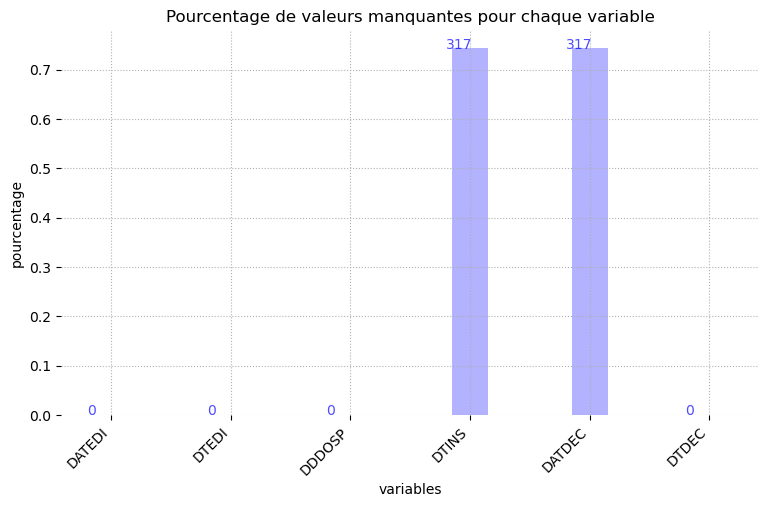

In [28]:
# Calcul des données manquantes & données nulles
# -------------------------------------------
plot_na_null(credits,VAR_DATE_CREDIT,fig_size=[9,5],plot_null=False)

In [29]:
# Calcul du nombre de valeurs manquantes pour les variables 'DTINS','DATDEC','DTEDI'
# -------------------------------------------
var_na = ['DTINS','DATDEC','DTEDI'] 
idx_na_list = [] # listes des indices des valeurs nulles pour les vaeriables de var_na

#---- calcul du nb de valeurs manquantes
for i in range(len(var_na)):
    idx_na_list.append(list(np.where(credits[var_na[i]].isna())[0]))
    print("Il y a {} valeurs manquantes dans {}".format(len(idx_na_list[i]),var_na[i]))

#---- calcul du nb de valeurs manquantes en commun
n_common = len((set(idx_na_list[0]).intersection(idx_na_list[1]))) #nb de valeurs en commun entre 2 variables 
print("\nIl y a  {} valeurs manquantes en commun entre DTINS et DATDEC".format(n_common))
n_common = len((set(idx_na_list[2]).intersection(idx_na_list[1]))) #nb de valeurs en commun entre 2 variables 
print("Il y a  {} valeurs manquantes en commun entre DATDEC et DTEDI".format(n_common))

Il y a 317 valeurs manquantes dans DTINS
Il y a 317 valeurs manquantes dans DATDEC
Il y a 0 valeurs manquantes dans DTEDI

Il y a  317 valeurs manquantes en commun entre DTINS et DATDEC
Il y a  0 valeurs manquantes en commun entre DATDEC et DTEDI


**Observation:** Il y a peu de variables manquantes pour les variables dates: seulement 0.7% pour les variables `DTINS` et `DATDEC` et quasiment 0%  pour `DTEDI`. On voit également que si une valeur manque pour `DTINS` elle manque aussi pour `DATDEC`. 

#### Pré-traitement & interpolation

In [30]:
"""OK"""
# Transformation des dates au format datetime
# -------------------------------------------
def type_date(df,var):
    """
    Cette fonction transforme les variables var du dataframe df
    au format pd.Timestamp qui est l'équivalent pandas de 
    Datetime de python et est interchangeable avec lui dans 
    la plupart des cas.     

    Input:
    ------
    - df (dataframe): dataframe contenant les données.
    - var (str): variable dates à transformer

    Output:
    -------
    - df (dataframe): dataframe transformé.
    
    Reference:
    ----------
    https://stackoverflow.com/questions/31761047/
    what-difference-between-the-date-time-datetime-and-timestamp-types
    """  
    
    # Transformation au format datetime
    for v in var:
        df[v] = pd.to_datetime(df[v])
    return df

In [31]:
credits = type_date(credits,VAR_DATE_CREDIT)

In [32]:
"""OK"""
def datetime_to_float(d):
    """
    Prend en entrée un timestamp et le transforme en float.
    """
    # '1970-01-01 00:00:00': date de référence: 
    epoch = dt.datetime.utcfromtimestamp(0) 
    # nb de secondes entre la date de référence et la date d (millisecond precision): 
    total_seconds =  (d - epoch).total_seconds() 
    return total_seconds

def float_to_datetime(fl):
    """
    Prend en entrée un float et le transforme en timestamp.
    """
    # Transformation des secondes fl en dae (Timestamp)
    return dt.datetime.fromtimestamp(fl)

In [33]:
"""OK"""
def sort_without_nan(df,v):
    """
    Cette fonction renvoie les indices des valeurs de la colonne v de la 
    dataframe df triés sans tenir compte des valeurs NaN. Les valeurs NaN 
    resteront donc au même endroit. 
    Ex: [2,np.nan,9,8,7,4] devient [2,np.nan,4,7,8,9]. 
    Un sort classique mettrait toutes les valeurs NaN à la fin.
    
     Input:
    ------
    - df (dataframe): dataframe contenant les données.
    - var (str): variable à trier

    Output:
    ------
    - idx_sorted (np.array): indices des éléments triés 
      sans les NaN. Dans l'exemple ci-dessus, on aurait
      [0,1,5,4,3,2]
    - save_idx (np.array): indices des éléments dans leur
      ordre d'origine. Dans l'exemple ci-dessus, on aurait
      [0,1,2,3,4,5]
    """
    #--- indices de df[v]
    save_idx = df[v].index
    #--- indices des éléments NaN dans df[v]
    idx_na=df[v][df[v].isna()].index
    #--- indices des éléments non NaN dans df[v]
    idx_no_na=df[v][df[v].notna()].index
    #--- indices des éléments non NaN **triés** dans df[v]
    # (on trie sans les NaN car sinon ils se retrouvent tous à la fin du tri)
    idx_sorted=df[v][idx_no_na].sort_values().index
    #--- On insère dans idx_sorted les indices idx_na aux 
    # localisations donnés idx_na. Ceci revient à avoir trié le tableau
    # sans avoir tenu compte des NaN que l'on a laissé au même endroit.
    for i in range(len(idx_na)):
        idx_sorted = np.insert(arr=idx_sorted,obj=idx_na[i],values=idx_na[i])
    return idx_sorted,save_idx

In [34]:
"""OK"""
def interpolate_date(df,var):
    """
    Cette fonction interpole les dates de façon linéaire. Les dates sont 
    au préalable triées (sans tenir compte des nan) avec la fonction sort_without_nan.
    L'interpolation donne des dates précises commme : '2022-12-18 12:00:00'
    Or, nous n'avons pas besoin d'une telle précision donc nous 
    simplifierons en '2022-12-18'. 
    Avant d'appliquer cette fonction: 
        * Appliquer la fonction type_date.
        * S'assurer que les index commencent bien à 0 et que le pas est de 1
          (sinon crée une erreur)
    On utilise les fonctions datetime_to_float et float_to_datetime. 
    
    Input:
    ------
    - df (dataframe): dataframe contenant les données.
    - var (str): variable dates à interpoler

    Output:
    ------
    - df (dataframe): dataframe transformé.
    
    Reference:
    ----------
    https://github.com/pandas-dev/pandas/issues/11312
    """
    
    for v in var:
        # Transformation du type timestamp au type float.
        s2 = df[v].apply(lambda x: datetime_to_float(x))
        # Avant d'interpoler, on récupère les indices des valeurs triées sans les NaN 
        idx_sorted,save_idx = sort_without_nan(df,v)
        # On interpole les floats de façon linéaire  
        df_interp = s2[idx_sorted].interpolate(method='linear') 
        # On remet dans l'ordre d'origine
        df_interp = df_interp[save_idx]
        # On transforme à nouveau le floats en timestamp
        df[v] = df_interp.apply(lambda x: float_to_datetime(x))
        # Réduit la précision au jour (et non pas à l'heure). Ceci met au format datetime 
        df[v] = df[v].apply(lambda x: x.date())
        # Remet met le format datetime au format timestamp
        df[v] = pd.to_datetime(df[v])

    return(df)

In [35]:
"""OK"""
def sort_by_date(df):
    """
    Une fois que l'on a interpolé les dates avec la fonction interpolate_date,
    on peut trier df par 'DATEDI' croissant. Cela permet d'éviter des erreurs
    par la suite (notamment lorsque l'on va calculer le nb de 'CODOSB' par 
    jour ou par semaine).  
        
    Input:
    ------
    - df (dataframe): dataframe contenant les données.

    Output:
    ------
    - df (dataframe): dataframe trié par 'DATEDI' croissant.
    """
    # Une fois la date interpolée, on peut trier par 'DATEDI' croissant
    df.sort_values(by=['DATEDI'],axis=0,inplace=True)
    # On réordonne les index
    df.reset_index(inplace=True,drop=True)
    
    return df

In [36]:
credits = interpolate_date(credits, VAR_DATE_CREDIT)
credits = sort_by_date(credits)

In [37]:
"""OK"""
def df_datetime_to_float(df,var):
    """
    Cette fonction transforme les variables dates du 
    dataframe df du format datetime au format float.
    Utilise la fonction datetime_to_float. 
    Le dataframe df ne doit pas contenir de NaN.
    
    Input:
    ------
    - df (dataframe): dataframe contenant les données.
    - var (str): variable dates à transformer

    Output:
    ------
    - df (dataframe): dataframe transformé.
    """
    # Parcourt des variables 
    for v in var:
        df[v] = df[v].apply(lambda x: datetime_to_float(x))
    return df

def df_float_to_datetime(df,var):
    """
    Cette fonction transforme les variables dates du 
    dataframe df du format float au format datetime.
    Utilise la fonction float_to_datetime. 
    Le dataframe df ne doit pas contenir de NaN.
    
    Input:
    ------
    - df (dataframe): dataframe contenant les données.
    - var (str): variable dates à transformer

    Output:
    ------
    - df (dataframe): dataframe transformé.
    """
    # Parcourt des variables 
    for v in var:
        df[v] = df[v].apply(lambda x: float_to_datetime(x))
    return df

In [38]:
# Calcul du nombre de variables telles que credits['DATEDI']-credits['DTINS'] < 0
# ----------------------------------------
delta = credits['DATEDI']-credits['DTINS']
delta = delta.apply(lambda x: x.total_seconds()) #transformation en float
n_neg_delta = len(np.where(delta < 0)[0]) #nb de variables qui ont un delta < 0
print("Il y a {} variables telles que DATEDI-DTINS < 0".format(n_neg_delta))

Il y a 163 variables telles que DATEDI-DTINS < 0


#### Ajout des variables réponses

In [39]:
"""OK"""
def compute_DELAI(df):
    """
    Cette fonction calcule la variable réponse 'DELAI'. 
    C'est le délai (en jours) entre l'arrivée du crédit
    au backOffice (variable 'DATEDI') et l'accord du client (variable 
    'DTINS'). Ainsi, 'DELAI' = 'DATEDI' - 'DTINS'.
    A utiliser après la fonction type_date.
        
    Input:
    ------
    - df (dataframe): dataframe contenant les données.

    Output:
    ------
    - df (dataframe): dataframe augmenté avec la variable 'DELAI'
    """
    # Différence 'DATEDI'-'DTINS'
    delta = df['DATEDI']-df['DTINS']
    # delta est du type timedelta64[ns] et on le transforme en nb de jours
    delta = (delta/np.timedelta64(1, 'D')).astype(int)
    # On met 0 aux endroits où DATEDI'-'DTINS' < 0 (pour le moment il y en a 163)
    delta[delta<0] = 0 
    # On crée une nouvelle colonne 'DELAI' contenant le nombre de jours
    # entre 'DATEDI' et 'DTINS'
    df['DELAI'] = delta.values
    
    return df

In [40]:
credits = compute_DELAI(credits)

In [41]:
"""OK"""
def compute_NB_DOSS_DAY(df):
    """
    Cette fonction calcule la variable réponse 'NB_DOSS_DAY'.
    'NB_DOSS_DAY' est le nombre de dossiers qui arrivent chaque semaine 
    au backOffice. Pour cela, on compte le nombre de 'CODOSB' par jour. 
    A utiliser après la fonction type_date.
    
    Input:
    ------
    - df (dataframe): dataframe contenant les données.

    Output:
    ------
    - df (dataframe): dataframe augmenté avec la variable 'NB_DOSS_DAY'
    """ 
    # Dataframe ayant en indice le jour ('DATEDI') et en valeur le nb de 'CODOSB' par jour
    df_CODOSB_day = df.groupby([df['DATEDI'].dt.date]).count()['CODOSB']
    # Convertit les indices au format datetime64 pour pouvoir faire le merge avec la 
    # variable 'DATEDI' de df qui est au format datetime64.
    df_CODOSB_day.index = pd.to_datetime(df_CODOSB_day.index)
    # Merge le nb de 'CODOSB' avec df. 
    # On obtient df avec une colonne en plus qui est le nb de 'CODOSB' par jour.
    df = df.merge(df_CODOSB_day, on='DATEDI')
    # On renomme les colonnes 
    df.rename(columns={"CODOSB_x": "CODOSB", "CODOSB_y": "NB_DOSS_DAY"},inplace=True)
    
    return df

In [42]:
credits = compute_NB_DOSS_DAY(credits)

**Si je veux prédire le nb de CODOSB qui arrivent par semaine, il faut que je regroupe toutes les données par semaine non ? Ou alors je mets le nb CODOSB par semaine pour tous les jours de la semaine. Le pb de grouper toutes les données par semaine est: comment faire le regroupement (moyenne, valeur la plus fréquente, pourcentage de telle modalités à la semaine?) ?** Il faut donc définir des règles pour regrouper par semaine et je verrai ça plus tard...

#### Corrélations

In [43]:
# Pour calculer la matrice de corrélation avec les dates,
# il faut les transformer au format float
credits_fl = credits.copy() #credits où les dates sont en floats
credits_fl = df_datetime_to_float(credits_fl,VAR_DATE_CREDIT)

In [44]:
"""plot_corr(credits_fl, VAR_QUANTI_CREDIT + VAR_DATE_CREDIT ,'spearman',fig_size=[10,9],
          save_path=PATH_PLOTS,save_name="credit_correlation_quanti&date_spearman")"""

'plot_corr(credits_fl, VAR_QUANTI_CREDIT + VAR_DATE_CREDIT ,\'spearman\',fig_size=[10,9],\n          save_path=PATH_PLOTS,save_name="credit_correlation_quanti&date_spearman")'

**Observations :** Nous observons que :

- Les variables des dates sont toutes corrélées entre elles.
- `DTEDI` (et les autres dates) est corrélée avec `CONSCE` (Nbre de scénarios) à 45%, `DELDEC` (Nbre jrs Décision) à 30% et `NBGAR` (Nbre de garanties) à 26%. 

In [45]:
"""plot_corr(credits_fl, VAR_QUANTI_CREDIT + ['NB_DOSS_DAY','DELAI'] + ['DATEDI'],'spearman',fig_size=[10,9],
          save_path=PATH_PLOTS,save_name="credit_correlation_quanti&reponses&dates_spearman")"""

'plot_corr(credits_fl, VAR_QUANTI_CREDIT + [\'NB_DOSS_DAY\',\'DELAI\'] + [\'DATEDI\'],\'spearman\',fig_size=[10,9],\n          save_path=PATH_PLOTS,save_name="credit_correlation_quanti&reponses&dates_spearman")'

In [46]:
"""plot_corr(credits_fl, VAR_QUANTI_CREDIT + ['DATEDI','DELAI','NB_DOSS_DAY'],'phik',fig_size=[8,6],
          save_path=PATH_PLOTS,save_name="credit_correlation_quanti&reponses_phik")"""

'plot_corr(credits_fl, VAR_QUANTI_CREDIT + [\'DATEDI\',\'DELAI\',\'NB_DOSS_DAY\'],\'phik\',fig_size=[8,6],\n          save_path=PATH_PLOTS,save_name="credit_correlation_quanti&reponses_phik")'

**Observations :** Nous observons que :

- Seul le taux d'intérêt `TAINT` semble être corrélé  à `DATEDI` avec la corrélation `phik`.

###  Variables qualitatives 

#### Variables manquantes 

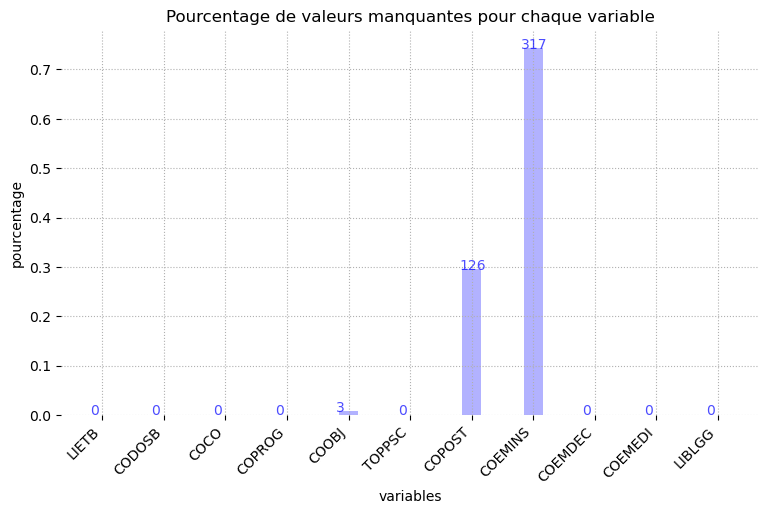

In [47]:
plot_na_null(credits,VAR_QUALI_CREDIT,fig_size=[9,5],plot_null=False)

**Observations**: 
- Les valeurs manquantes sont au nombre de 0.5% pour `COPOST` (code postal du bien financé) et 0.7% pour `COEMINS` (Identifiant employé instruction). **<font color = 'red'> Peut-on imputer COPOST par un autre moyen ?</font>** 
- Il y a moinds de 0.1% de valeurs manquantes pour `COEMEDI`(Identifiant employé édition) et `COOBJ` (Code objet prêt). On pourrait emputer par la valeur la plus commune.   

In [48]:
"""OK"""
# Mettre les variables qualitatives au format categorical. 
# --------------------------------------
def to_Categorical(df,var):
    """
    Cette fonction transforme les variables qualitatives var 
    de la dataframe df et les met aui format pd.Categorical
    
     Input:
    ------
    - df (dataframe): dataframe contenant les données.
    - var (list): liste des variables quanlitatives à transformer
      en pd.Categorical.

    Output:
    ------
    - df (dataframe): dataframe transformé
    """
    credits_cat = df.copy()
    for v in var: 
        credits_cat[v] = pd.Categorical(df[v],ordered=False)
    return credits_cat

In [49]:
credits_cat = to_Categorical(credits,VAR_QUALI_CREDIT)

In [50]:
"""OK"""
def print_levels(df,var,fig_size,verbose:bool=False):
    """
    Cette fonction trace pour chaque variable qualitative var du
    dataframe df, le nombre de modalités.
    
    Input:
    ------
    - df (dataframe): dataframe contenant les données.
    - var (list): liste des variables qualitatives
    - fig_size (list): liste de 2 valeurs indiquant la taille 
      des plots. 
    - verbose (bool): si True, affiche un texte décrivant le 
      nombre de modalités. 
      
    Output:
    ------
    - Graphiques.
    """
    
    #---- Calcul du nombre de modalités
    # Dictionnaire contenant en key la variable et 
    # en value le nb de modalités de la variable
    d_nb_mod = {}  

    for v in var:
        #dict contenant en clé la modalité et en value le nb d'occurences dans le dataset
        d = Counter(df[v]) 
        d_nb_mod[v] = len(d.keys())
    
    #---- Affichage si verbose=True
    if verbose: 
        print("Nombre de modalités pour chaque variable:")
        print("-----------------------------------------")
        for v in var:
            print("{} possède {} modalités".format(v,d_nb_mod[v]))
            
    #---- Tracé des graphes
    fig, axs = plt.subplots(figsize=(fig_size[0], fig_size[1]))
    
    axs.bar(d_nb_mod.keys(), d_nb_mod.values(), width=.3, color='b',alpha=.3)
    axs.set_xticklabels(d_nb_mod.keys(), rotation = 45, ha="right")
    axs.grid(linestyle=':')
    axs.set_title("Nombre de modalités pour chaque variable")
    axs.set_ylabel("nombre de modalités"); axs.set_xlabel("variables")
    axs.spines[['right', 'top', 'bottom', 'left']].set_visible(False)

    # Affiche le nb de valeurs NaN au dessus des plots
    j = 0
    for index,data in enumerate(d_nb_mod.values()):
        axs.text(x=index-0.2,y =list(d_nb_mod.values())[j],s=f"{data}",
                    fontdict=dict(fontsize=10),color='b',alpha=.7)
        j+=1

Nombre de modalités pour chaque variable:
-----------------------------------------
LIETB possède 1 modalités
CODOSB possède 26211 modalités
COCO possède 42659 modalités
COPROG possède 9 modalités
COOBJ possède 16 modalités
TOPPSC possède 2 modalités
COPOST possède 1523 modalités
COEMINS possède 1546 modalités
COEMDEC possède 1179 modalités
COEMEDI possède 53 modalités
LIBLGG possède 2 modalités


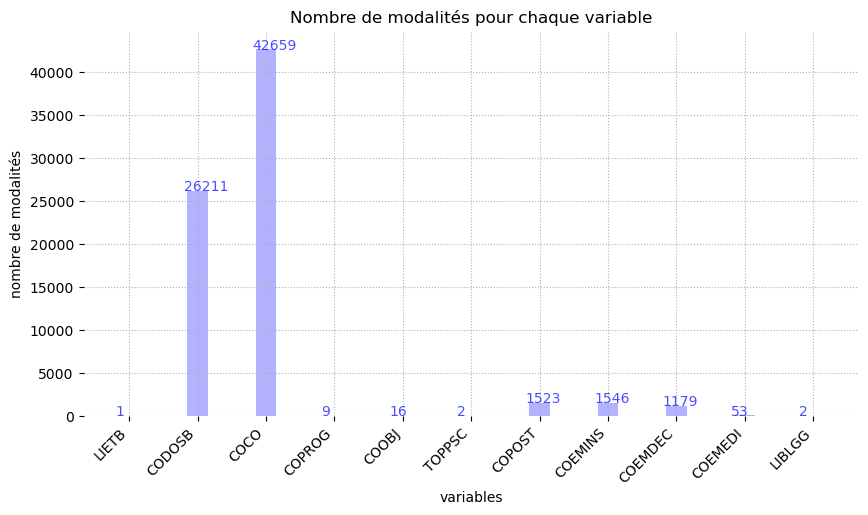

In [51]:
print_levels(credits,VAR_QUALI_CREDIT,fig_size=[10,5],verbose=True)

In [52]:
"""OK"""
# Variables qualitatives de crédit qui ont peu de modalités (small)
VAR_QUALI_CREDIT_S = ['LIETB','COPROG','COOBJ','TOPPSC','LIBLGG']
# Variables qualitatives de crédit qui ont beaucoup de modalités (big)
VAR_QUALI_CREDIT_B = list((set(VAR_QUALI_CREDIT).difference(VAR_QUALI_CREDIT_S)))

**Observations:** 
- On voit que seules les variables `LIETB`, `COPROG`, `COOBJ` et `TOPPSC` possèdent moins de 1000 modalités. 
- Il est normal que les autres varibles possèdent beaucoup de modalités. Il s'agit de : 
    * `COCO`: Identifiant contrat 
    * `CODOSB`: Identifiant dossier bancaire
    * `COPOST`: Code postal du bien financé
    * `COEMINS`,`COEMDEC`,`COEMEDI` : Identifiant employé instruction, décision et édition

In [53]:
"""OK"""
def plot_bar(df,var,layout,fig_size=[8,8]):
    """
    Cette fonction trace les barplots des variables var 
    de la dataframe df.
    
     Input:
    ------
    - df (dataframe): dataframe contenant les données.
    - var (str): variables qualitatives pour lesquelles 
      tracer les barplots.
    - layout (list): liste de 2 valeurs indiquant la disposition des 
      subplots. Par exemple, pour tracer 10 histogrammes, on peut 
      entrer layout = [5,2] et on aura une matrice 5x2 de plots. 
    - fig_size (list): liste de 2 valeurs indiquant la taille 
      des subplots. 

    Output:
    ------
    - Graphiques.    
    """
    fig, axs = plt.subplots(layout[0],layout[1], figsize=(fig_size[0], fig_size[1]))
    plt.subplots_adjust(hspace=.5,wspace=.3)
    fig.suptitle("Barplot des variables qualitatives", fontsize=16, y=0.95)
    axs = axs.ravel()

    #---- Parcourt les variables et trace leur barplot
    i=0
    for v in var:
        #dict contenant en clé la modalité et en value le nb d'occurences dans me dataset
        d = Counter(df[v]) 
        axs[i].bar(x=list(d.keys()),height=list(d.values()),color='b',alpha=0.5)

        axs[i].set_title("Barplot de " + v)
        axs[i].tick_params(axis='x', rotation=45)
        axs[i].set_ylabel("nb d'occurrences")
        axs[i].spines[['right', 'top', 'bottom', 'left']].set_visible(False)
        i+=1

    plt.show()

In [54]:
"""plot_bar(credits_cat,VAR_QUALI_CREDIT_S,layout=[3,2],fig_size=[8,15])"""

'plot_bar(credits_cat,VAR_QUALI_CREDIT_S,layout=[3,2],fig_size=[8,15])'

#### Boxplots quantitative~qualitative

In [55]:
print(VAR_QUANTI_CREDIT)
print(VAR_QUALI_CREDIT_S)
print(VAR_QUALI_CREDIT_B)

['MEDOS', 'TAINT', 'TITEGI', 'QLDDOS', 'NBASSGPE', 'NBASSEXT', 'NBGAR', 'DELINS', 'DELDEC', 'DELEDI', 'CONSCE']
['LIETB', 'COPROG', 'COOBJ', 'TOPPSC', 'LIBLGG']
['COPOST', 'COEMDEC', 'CODOSB', 'COEMEDI', 'COEMINS', 'COCO']


In [56]:
"""OK"""
import math
def round_up_to_even(f):
    """
    Donne la valeur entière paire supérieure à f la plus proche. 
    """
    return math.ceil(f / 2.) * 2

def find_multiplied_nb(x:int):
    """
    Cette fonction prend en entrée un integer x et renvoie un tuble (a,b)
    tels que a*b=x où a et b sont les plus proches possibles.
    Ex: 16 = 1*16 = 2*8 = 4*4. La fonction renverra (4,4) car ce sont 
    les nombres les plus proches entre eux. 
    
    Ref: https://stackoverflow.com/questions/42351977/how-to-split-an
    -integer-into-two-integers-that-when-multiplied-they-give-the-res
    """
    # trouve toutes les combinaisons possibles de (a,b) telles que x = a*b
    possible_combinations = [(i, x / i) for i in range(1, int(math.ceil(x**0.5)) + 1) if x % i == 0]
    # liste des différentes valeurs de |a-b|
    absolute_diff = [] 
    for item in possible_combinations:
        absolute_diff.append(abs(item[0]-item[1]))
    # On veut a et b les plus proches entre eux tq a*b=x
    # on prend donc la combinaison tel que |a-b| soit minimal
    best_combi = possible_combinations[np.argmin(absolute_diff)]
    
    return (int(best_combi[0]),int(best_combi[1]))

In [57]:
"""OK"""
def plot_box_cat_num(df,var_quanti,var_quali,fig_size,layout=None,hide_labels:bool=False):
    """
    Cette fonction trace les boxplots des variables var_quanti~var_quali 
    du dataframe df. Nécessite les fonctions round_up_to_even et 
    find_multiplied_nb pour calculer la matrice des subplots.
    
     Input:
    ------
    - df (dataframe): dataframe contenant les données.
    - var_quanti (str): variables quantitatives pour lesquelles 
      tracer les boxplots.
    - var_quanli (str): variables qualitatives pour lesquelles 
      tracer les boxplots.
    - fig_size (list): liste de 2 valeurs indiquant la taille 
      des subplots. 
    - layout (list): liste de 2 valeurs indiquant la taille de
      la matrice des subplots. Si None, la taille est calculée
      automatiquement.
    - hide_labels (bool): si True, n'affiche pas les x labels.

    Output:
    ------
    - Graphiques.    
    
    Reference:
    ----------
    https://stackoverflow.com/questions/57891028/
    unable-to-recreate-catplot-with-matplotlib
    """

    #----- Calculs préliminaires
    # Calcul du nb total de variables
    n_var = int(len(var_quali) *len(var_quanti))
    print("{} variables".format(n_var))

    # CAS 1: Plusieurs boxplots
    # -------------------------
    if n_var > 1:
        # Trouve l'entier pair le plus proche supérieur à n_var 
        n_var2 = round_up_to_even(n_var)
        # Calcul de la taille de la matrice des subplots 
        if not(layout):
            layout = find_multiplied_nb(n_var2)

        #----- Tracé des graphiques
        fig, axs = plt.subplots(layout[0],layout[1], figsize=(fig_size[0], fig_size[1]))
        plt.subplots_adjust(hspace=0.5,wspace=0.3)
        fig.suptitle("Boxplots des variables quantitatives ~ qualitatives", fontsize=16, y=0.95)
        axs = axs.ravel()

        i=0
        for v_num in var_quanti:
            for v_cat in var_quali:
                # dataframe réduit à 2 variables: une quantitative et une qualitative
                df_v = pd.DataFrame(data = {'V_QUALI': df[v_cat],
                                            'V_QUANTI': df[v_num]})
                
                # labels de var_quali. On trie car plus bas, groupby trie par
                # ordre alphabétique et on veut que chaque boxplot ait le bon label. 
                labels = list(np.sort(df_v.V_QUALI[df_v.V_QUALI.notna()].unique()))
                
                # on retire les NaN sinon le boxplot peut ne pas apparaître
                df_v.dropna(axis=0,inplace = True)

                axs[i].boxplot([col.V_QUANTI.values for n, col in df_v.groupby(by="V_QUALI",sort=True)],patch_artist=False,
                           labels=labels,flierprops = dict(markerfacecolor = '0.5', markersize = 2))
                axs[i].set_xlabel(v_cat)
                axs[i].tick_params(axis='x', rotation=45)
                axs[i].set_ylabel(v_num)
                axs[i].set_title("Boxplot {}~{}".format(v_num,v_cat))
                if hide_labels:
                    axs[i].set_xticks([])
                
                i+=1
        # suppression des subplots en trop
        n_plots = layout[0]*layout[1]
        if n_plots > n_var:
            for a in range(n_var,n_plots):
                fig.delaxes(axs[a])
        plt.show()


    # CAS 2: Un boxplot
    # -------------------------
    else: 
        v_cat=var_quali[0]; v_num=var_quanti[0]
        
        #----- Tracé des graphiques
        fig, axs = plt.subplots(figsize=(fig_size[0], fig_size[1]))
        # dataframe réduit à 2 variables: une quantitative et une qualitative
        df_v = pd.DataFrame(data = {'V_QUALI': df[v_cat],
                                    'V_QUANTI': df[v_num]})
        
        # labels de var_quali. On trie car plus bas, groupby trie par
        # ordre alphabétique et on veut que chaque boxplot ait le bon label.
        labels = list(np.sort(np.unique(df_v.V_QUALI[df_v.V_QUALI.notna()])))
        # on retire les NaN sinon le boxplot peut ne pas apparaître
        df_v.dropna(axis=0,inplace = True)
        axs.boxplot([col.V_QUANTI.values for n, col in df_v.groupby(by="V_QUALI",sort=True)],patch_artist=False,
                   labels=labels,flierprops = dict(markerfacecolor = '0.5', markersize = 2))
        
        axs.set_xlabel(var_quali)
        axs.tick_params(axis='x', rotation=45)
        axs.set_ylabel(var_quanti)
        axs.set_title("Boxplot {}~{}".format(var_quanti,var_quali))
        if hide_labels:
            axs.set_xticks([])

    # Rq: liste de array de taille (nb modalités de V_QUALI)
    # Chaque élément de la liste est un tableau contenant 
    # les valeurs que prend V_QUANTI pour une modalité de var_quali donnée 
    # [col.V_QUANTI.values for n, col in df.groupby(by="V_QUALI")] 

In [58]:
# Corrélations entre les variables qualitatives avec peu de modalités & toutes les variables quantitatives 
# -----------------------------------------------
"""plot_box_cat_num(credits_cat,VAR_QUANTI_CREDIT,['COPROG', 'COOBJ', 'TOPPSC','LIBLGG'],fig_size=[20,30],layout=[9,5])"""

"plot_box_cat_num(credits_cat,VAR_QUANTI_CREDIT,['COPROG', 'COOBJ', 'TOPPSC','LIBLGG'],fig_size=[20,30],layout=[9,5])"

**Observations:**  On voit les variables suivantes semnblent êytre corrélées:

- `TAINT`(Taux intérêt)-`COPROG`(Id produit groupe), `TITEGI`-`COPROG`(Id produit groupe) & un peu `TAINT`(Taux intérêt)-`COOBJ`(Code objet prêt)
- `QLDDOS`(Durée du prêt)-`COPROG`(Id produit groupe) & `QLDDOS`(Durée du prêt)-`COOBJ`(Code objet prêt)
- `NBASSGPE`(Nb Assurance Groupe)-`COPROG`(Id produit groupe) & `NBASSGPE`(Nb Assurance Groupe)-`COOBJ`(Code objet prêt)
- `NBASSEXT`(Nb Assurance Externe)-`COPROG`(Id produit groupe) & `NBASSEXT`(Nb Assurance Externe)-`COOBJ`(Code objet prêt)
- `NBGAR`(Nbre de garanties)-`COPROG`(Id produit groupe)

8 variables


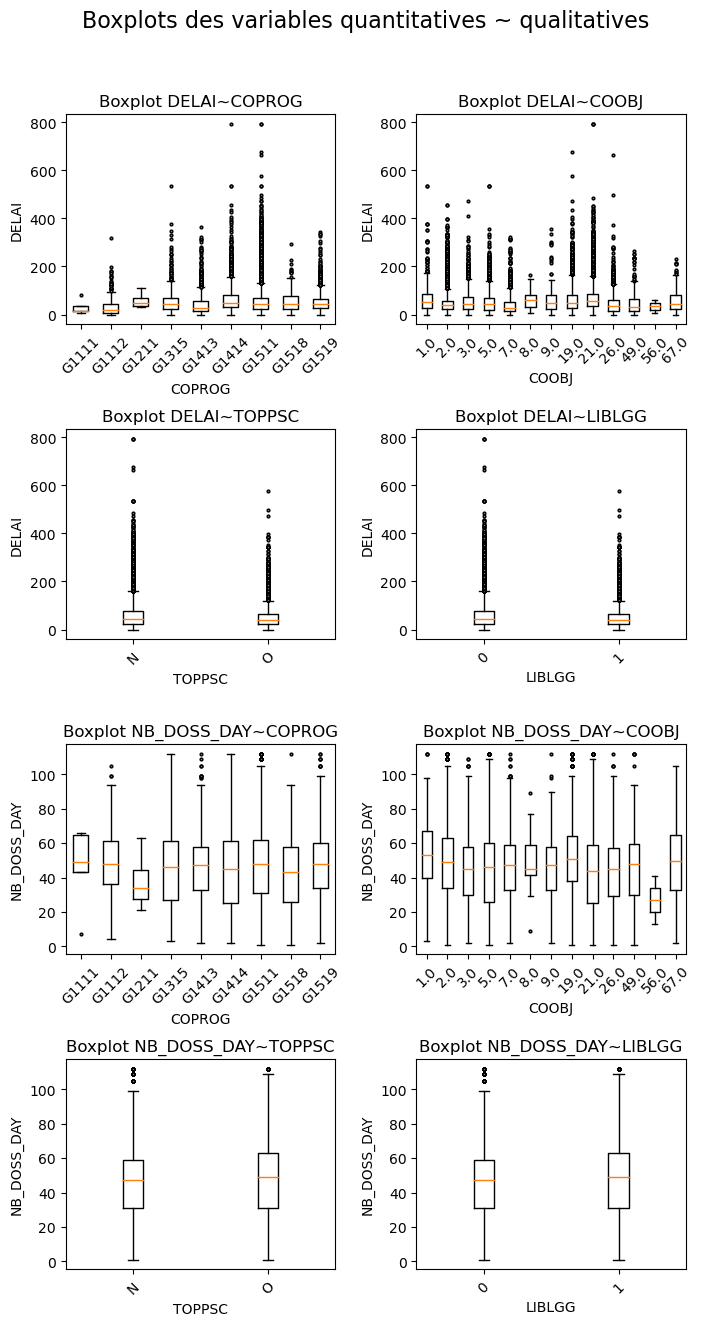

In [59]:
# Corrélations entre les variables qualitatives avec peu de modalités & les variabes réponses 
# -----------------------------------------------
plot_box_cat_num(credits_cat,['DELAI','NB_DOSS_DAY'],['COPROG', 'COOBJ', 'TOPPSC','LIBLGG'],fig_size=[8,15],layout=[4,2])

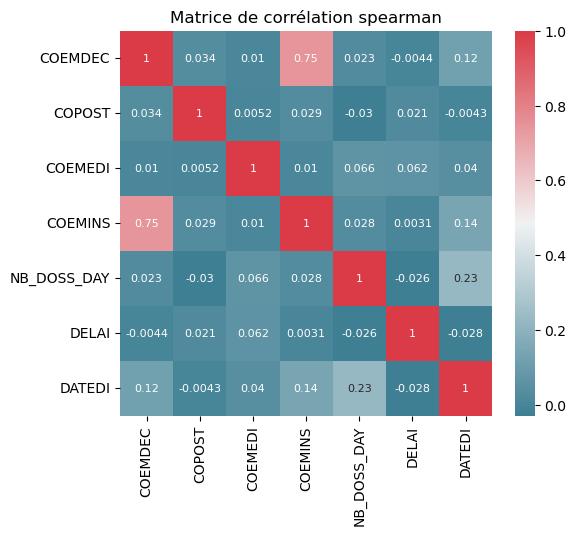

In [60]:
# Comme on ne peut pas regarder les corrélations entre les variables qualitatives avec beaucoup de modalités 
# & les variables quantitative avec des boxplots comme ci-dessus, on calcule la matrice des corrélartions
# et on traite les variables qualitatives avec beaucoup de modalités qui sont des entiers comme des variables quanttitatives. 
plot_corr(credits_fl, ['COEMDEC', 'COPOST', 'COCO', 'COEMEDI', 'COEMINS'] + ['NB_DOSS_DAY','DELAI'] + ['DATEDI'],'spearman',fig_size=[6,5],
          save_path=PATH_PLOTS,save_name="credit_correlation_quanli&reponses&dates_spearman")

## NB_DOSS_DAY

Dans cette section, on cherche à prédire la variable réponse `NB_DOSS_DAY` qui est le nombre de dossiers qui arrivent au backOffice par jour ou par semaine. 

Pour rappel, voici la table des données crédit avec la variable réponse : 

| Index | `DATEDI`   | `DELAI` | `TAINT`    |...|`NB_DOSS_DAY`|
|-------|------------|---------|----------  |---|-------------| 
|0	    |2017-10-19  |	 2	   | 2.4266	    |...|1            |
|1	    |2017-11-24	 |   0	   |1.6625	    |...|1            |
|2	    |2017-12-13  |  140	   |1.5104      |...|1            |
|3	    |2017-12-14  |	41     |	1.8146  |...|1            |
|4	    |2018-01-05  |	37     |	0.0000	|...|5            |
|...    |	...	     |...	   |...         |...|...          |
|42654  |2022-12-29  |	85     |	2.1305  |...|4            |
|42655  |2022-12-29  |	85     |	1.8658  |...|4            |
|42656  |2022-12-29  |	71     |	2.4777  |...|4            |
|42657  |2022-12-30  |	56     |	2.6312  |...|2            |
|42658  |2022-12-30  |	56     |	2.2938  |...|2            |

On voit que plusieurs crédits peuvent être édités pour la même date. Or, pour avoir une série temporelle (ST), il ne faut pas de doublons dans les dates. On va donc aggréger les données correspondant à une même date en prenant la classe majoritaire pour les variables qualitatives et la valeur moyenne pour les variables quantitatives.

Un autre problème est que les données temporelles ne sont pas continues dans le temps (nous n'avons pas une donnée tous les jours). Lorsque nous cherchons à faire de l'univarié c'est à dire à prédire `NB_DOSS_DAY` en fonction du temps seulement, nous pouvons ajouter des lignes aux journées manquantes et mettre pour ces lignes `NB_DOSS_DAY` = 0. Cependant, si nous voulons faire du multivarié, nous ne pouvons pas ajouter des lignes aux endroits où il manque des jours car il faudrait alors ajouter des valeurs pour toutes les autres variables ce qui n'est pas possible car ces valeurs sont inconnues. On peut peut-être aggréger les données par semaine (mais  de la même façon, il faut trouver des règles pour aggréger les données à la semaine et des règles pour trouver des valeurs pour les semaines où nous n'avons pas de crédits).

### Sélection de variables 

- Les variables qualitatives ayant beaucoup de modalités sont: `COEMDEC`,`COEMEDI`, `COEMINS` (Identifiant employé décision, édition, instruction), `COPOST` (code postal), `COCO` (Identifiant contrat) et `CODOSB` (Identifiat dossier bancaire). \
D'après les graphes ci-dessus, on voit que ces variables ne sont pas très corrélées avec les variables à expliquer (`DELAI`,`NB_DOSS_DAY`). Comme les variables qualitatives doivent être encodées et que le nombre de modalités pose problème pour l'encodage, je pense ne pas considérer ces variables pour la suite. 

- On observe aussi que les variables dates `DATEDI`, `DTEDI`, `DDDOSP`, `DTINS`, `DATDEC`, `DTDEC` sont toutes fortement corrélées entre elles (corrélation > 0.99). On ne peut donc conserver que `DATEDI` pour l'étude.  

- On peut supprimer la variable `LIETB`est constate et sera utile uniquement lorsque les données BPS seront présentes. On peut donc pour le moment supprimer cette variable.

In [61]:
"""OK"""
# Redéfinition des variables qualitatives, quantitatives et dates 
# ----------------------------------------
# variables réponses
VAR_REP = ['NB_DOSS_DAY']
# variable date
VAR_DATE_CREDIT_n = ['DATEDI']
# variables quantitatives 
VAR_QUANTI_CREDIT_n = ['MEDOS','TAINT','TITEGI','QLDDOS','NBASSGPE','NBASSEXT','NBGAR','DELINS','DELDEC','DELEDI','CONSCE']
# variables qualitatives 
VAR_QUALI_CREDIT_n = ['COPROG','COOBJ','TOPPSC','LIBLGG']

### Imputation des données 

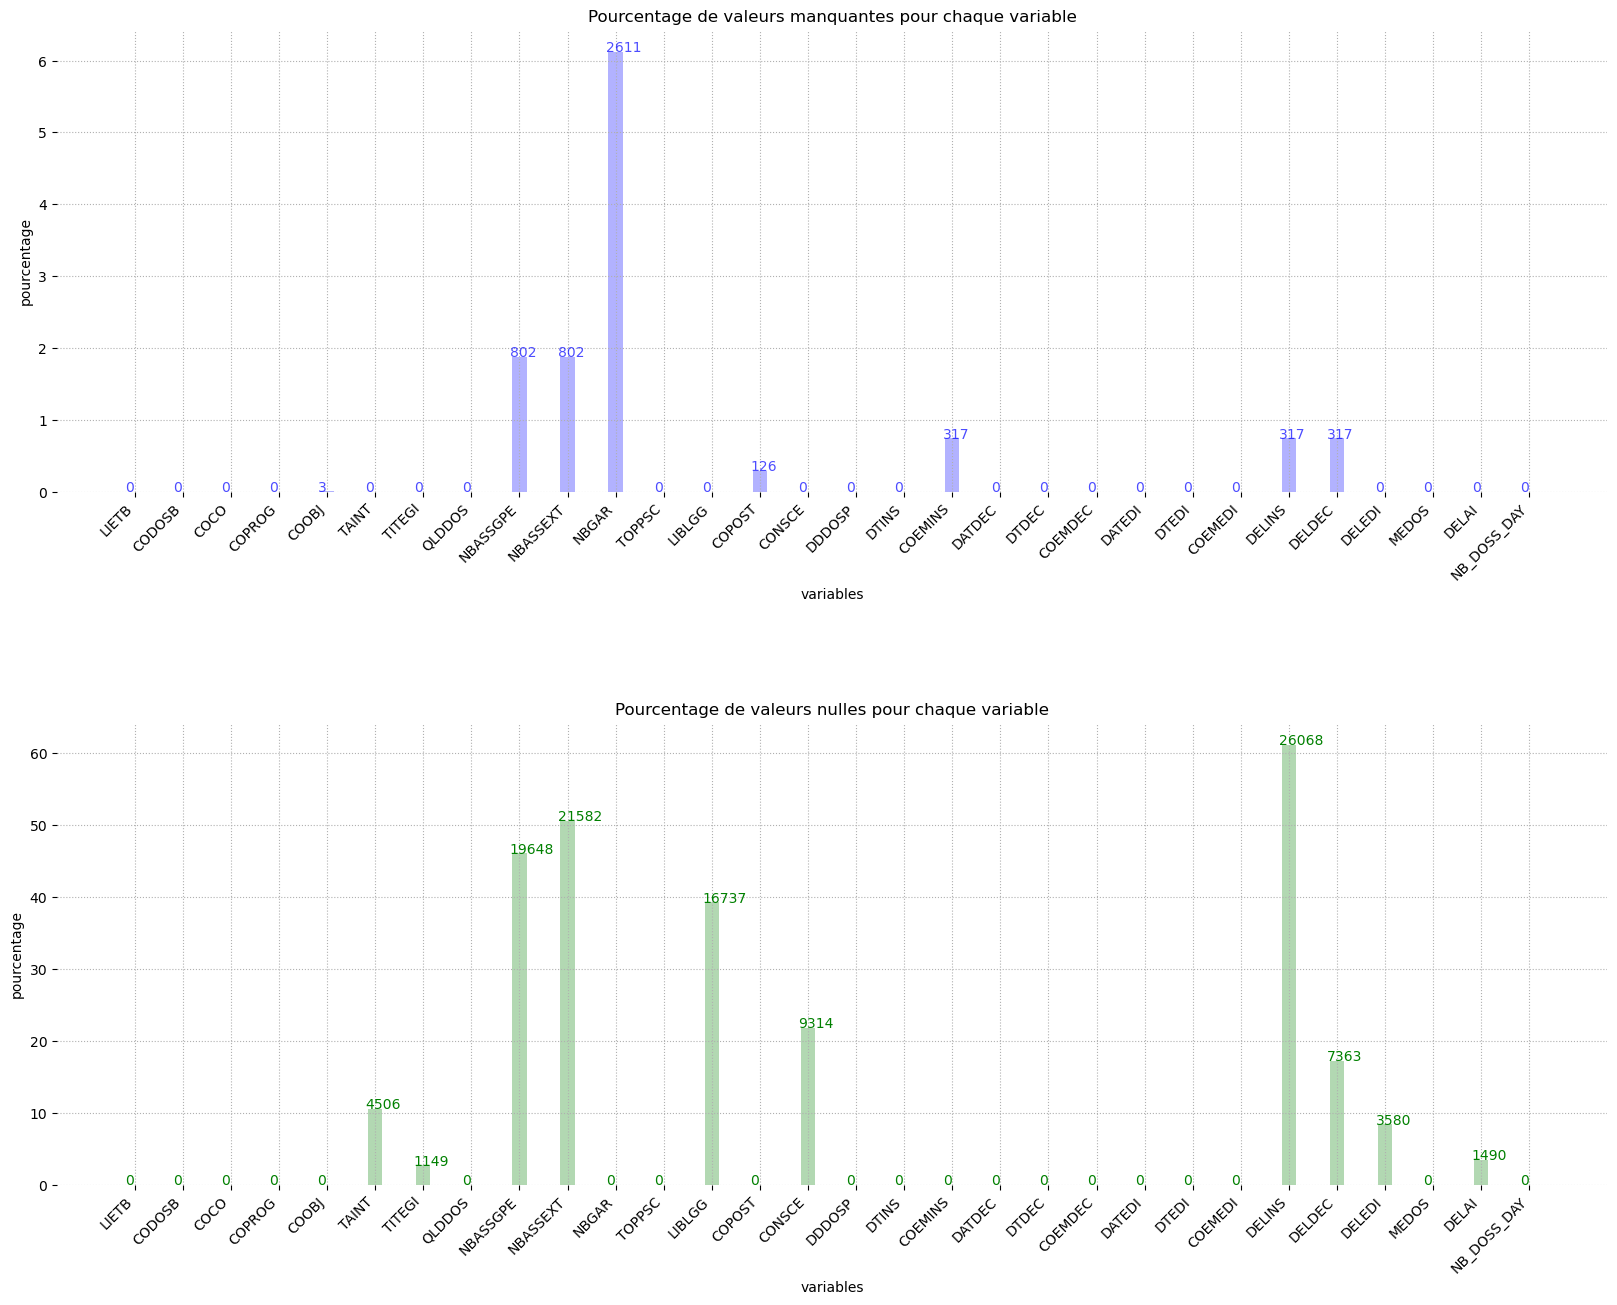

In [62]:
# Affichage à nouveau des données manquantes et nulles pour les variables sélectionnées ci-dessus. 
# -----------------------------------------------
plot_na_null(credits,credits.columns,fig_size=[20,15],plot_null=True)

**Observations:**

Parmi les variables que l'on va sélectionner, on observe des variables manquantes pour:
- `NBGAR` (Nbre de garanties) $\rightarrow$ on observe des valeurs manquantes pour `NBGAR` et aucune valeur nulle. On en déduit que lorsqu'un client n'a pas de garanties, la variable est manquante. On met donc toutes les variables manquantes de `NBGAR` à 0.
- `DELINS` (Nbre jours Instruction) $\rightarrow$ on sait que `DELINS` = `DTINS`(Date instruction traitée) - `DDD0SP`(Date instruction à traiter). Or nous avons déjà interpolé la variable `DTINS` et la variable `DDD0SP` n'est pas manquante. Nous pouvons donc calculer les valeurs manquantes de `DELINS`. 
- `DELDEC` (Nbre jrs Décision) $\rightarrow$ on sait que `DELDEC` = `DTDEC`(Date accord banque traitée) - `DATDEC`(Date accord banque à traiter). Or nous avons déjà interpolé la variable `DATDEC` et la variable `DTDEC` n'est pas manquante. Nous pouvons donc calculer les valeurs manquantes de `DELDEC`
- `NBASSGPE`(Nbre Assurance Groupe) et `NBASSEXT`(Nbre Assurance Externe)  $\rightarrow$  on observe le même nombre de valeurs manquantes pour ces 2 variables et après calcul on voit que les valeurs sont manquantes aux mêmes endroits pour ces deux variables. Or, un client est supposé posseder soit une assurance de groupe, soit une assurance externe. De plus, on voit que `NBASSGPE` et `NBASSEXT` ont environ le même nombre de 0. Pour un dossier dont l'assurance est manquante, on va donc tirer aléatoirement (avec proba 1/2) une assurance entre `NBASSGPE` et `NBASSEXT`, par exemple `NBASSGPE`. On met la valeur de `NBASSGPE` à 0 et on prend pour `NBASSEXT`, la moyenne. 
-  `COOBJ` (Code objet prêt) $\rightarrow$ possède très peu de valeurs manquantes. On impute par la modalité majoritaire.

In [63]:
"""OK"""
def fill_na_1(df):
    """
    Cette fonction remplit les valeurs manquantes pour le cas de la prédiction de NB_DOSS_DAY    
    selon les régles décrites ci-dessous : 
        *'NBGAR': toutes les variables manquantes sont mises à 0.
        *'COOBJ': toutes les variables manquantes sont imputées par la modalité majoritaire.
        *'DELINS' = 'DTINS'-'DDD0SP', où les valeurs manquantes de 'DTINS' ont été au préalable interpolées. 
        *'DELDEC' = 'DTDEC'-'DATDEC', où les valeurs manquantes de 'DATDEC' ont été au préalable interpolées. 
        * 'NBASSGPE' et 'NBASSEXT' (valeurs manquantes aux mêmes endroits). Pour un dossier dont l'assurance 
          est manquante, on tire aléatoirement (avec proba 1/2) une assurance entre NBASSGPE et NBASSEXT que 
          que l'on met à 0. Pour la variable non tiée, on remplit par la valeur moyenne.
    
     Input:
    ------
    - df (dataframe): dataframe contenant les données.

    Output:
    ------
    - df (dataframe): dataframe avec données manquantes imputées.
    """ 
    
    # Variable NBGAR
    # --------------------------------------
    df['NBGAR'][df['NBGAR'].isna()] = 0

    # Variable COOBJ
    # --------------------------------------
    # indices des valeurs manquantes pour la variable 'COOBJ'
    idx_na = np.where(df['COOBJ'].isna())[0]
    # dictionnaire contenant en key, la modalité et en value, son occurrence dans df
    d = Counter(df['COOBJ'][df['COOBJ'].notna()].values)
    # modalité majoritaire 
    majority_class = d.most_common(1)[0][0]
    # imputation par la classe majoritaire 
    df['COOBJ'].iloc[idx_na] = majority_class

    # Variable DELINS
    # --------------------------------------
    # indices des valeurs manquantes de 'DELINS'
    idx_na = np.where(df['DELINS'].isna())[0]
    # remplissage des valeurs manquantes
    df['DELINS'].iloc[idx_na] = df['DTINS'].iloc[idx_na]-df['DDDOSP'].iloc[idx_na]
    # transformation du type timedelta au type float
    df['DELINS'].iloc[idx_na] = df['DELINS'].iloc[idx_na]/pd.to_timedelta(1, unit='D')
    # mise au format entier
    df['DELINS'] = df['DELINS'].astype(int)

    # Variable DELDEC
    # --------------------------------------
    # indices des valeurs manquantes de 'DELINS'
    idx_na = np.where(df['DELDEC'].isna())[0]
    # remplissage des valeurs manquantes
    df['DELDEC'].iloc[idx_na] = df['DTDEC'].iloc[idx_na]-df['DATDEC'].iloc[idx_na]
    # transformation du type timedelta au type float
    df['DELDEC'].iloc[idx_na] = df['DELDEC'].iloc[idx_na]/pd.to_timedelta(1, unit='D')
    # l'imputation a créé des valeurs négatives que l'on met à 0
    df['DELDEC'].iloc[np.where(df['DELDEC'] < 0)[0]] = 0
    # mise au format entier
    df['DELDEC'] = df['DELDEC'].astype(int)

    # Variables NBASSGPE & NBASSEXT
    # --------------------------------------
    # indices des valeurs manquantes de 'NBASSGPE' et 'NBASSEXT' (qui ont des NaN aux mêmes endroits)
    idx_na = np.unique(np.where(df[['NBASSGPE','NBASSEXT']].isna())[0])

    # valeurs moyennes des variables NBASSGPE et NBASSEXT 
    val_moy_NBASSGPE = round(df['NBASSGPE'].mean()) #round car on veut des entiers 
    val_moy_NBASSEXT = round(df['NBASSEXT'].mean()) #round car on veut des entiers

    for i in range(len(idx_na)):
        # choix aléatoire: 1 -> on impute par 'NBASSGPE', 0 -> on impute par 'NBASSEXT'
        is_NBASSGPE = random.choice([0,1])

        # on met NBASSEXT=0 et NBASSGPE=valeur moyenne 
        if is_NBASSGPE:
            df['NBASSEXT'].iloc[idx_na[i]] = 0
            df['NBASSGPE'].iloc[idx_na[i]] = val_moy_NBASSGPE
        # on met NBASSGPE=0 et NBASSEXT=valeur moyenne 
        else:
            df['NBASSEXT'].iloc[idx_na[i]] = val_moy_NBASSEXT
            df['NBASSGPE'].iloc[idx_na[i]] = 0

    return df

In [64]:
# Imputation des données manquantes 
# -------------------------------------
credits = fill_na_1(credits)

In [65]:
# Selection des variables définies plus haut
# -------------------------------------
credits1 = credits[VAR_DATE_CREDIT_n+VAR_QUANTI_CREDIT_n+VAR_QUALI_CREDIT_n+VAR_REP]

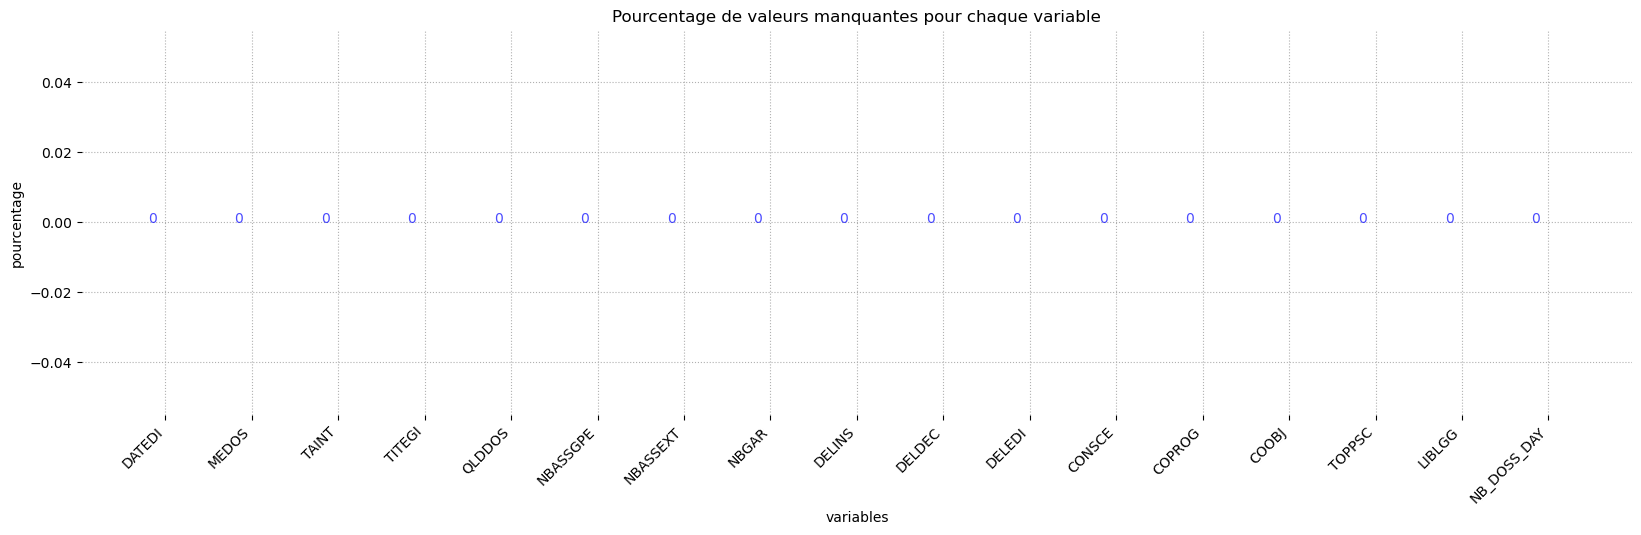

In [66]:
# Vérification qu'il ne reste plus de variables manquantes
# -------------------------------------
plot_na_null(credits1,credits1.columns,fig_size=[20,5],plot_null=False)

### Regroupement des dates identiques

Afin d'avoir le format d'une Série Temporelle, on aggrège les données correspondant à une même date en prenant la classe majoritaire pour les variables qualitatives et la valeur moyenne pour les variables quantitatives.

In [67]:
"""OK"""
def create_MTS_day(df,var_floats,var_int,var_quali,var_date,var_rep):
    """
    Cette fonction permet d'aggréger les lignes correspondant à une même date en prenant 
    la classe majoritaire pour les variables qualitatives et la valeur moyenne pour les variables 
    quantitatives. Pour la variable réponse 'NB_DOSS_DAY' (nb dossiers/jours), on prend la valeur 
    médiane. En effet, comme nous avons calculé au préalable le 'NB_DOSS_DAY' pour chaque jour,
    les lignes correspondant à une même date ont la même valeur de 'NB_DOSS_DAY' et la médiane 
    est simplement la valeur de 'NB_DOSS_DAY' par jour. 

    Input:
    ------
    - df (dataframe): dataframe contenant les données.
    - var_floats (list): variables quantitatives réelles.
    - var_int (list): variables quantitatives entières.
    - var_quali (list): variables qualitatives.
    - var_date (list): variable date.
    - var_rep (list): variable réponse.

    Output:
    ------
    - df_finale (dataframe): dataframe transformée.

    Reference:
    ---------
    https://stackoverflow.com/questions/15222754/
    groupby-pandas-dataframe-and-select-most-common-value
    """ 
    
    # Variable réponse
    # -------------------------------------
    # On a déjà calculé 'NB_DOSS_DAY' (nb de dossiers/jours). 
    # Toutes les lignes correspondant à une même dates ont une même valeur de 'NB_DOSS_DAY'
    # df_rep = dataframe de 'NB_DOSS_DAY' regroupés par date. 
    # En indice: date, en values:valeur médiane = valeur réelle (car les mêmes jours ont déjà les mêmes valeurs)
    df_rep = df[var_date+var_rep].groupby('DATEDI').median().astype(int)

    # Variables quantitatives
    # -------------------------------------
    # dataframe des variables quantitatives floats regroupés par date. 
    # En indice: date, en values:valeur moyenne par date
    df_float = df[var_date+var_floats].groupby(var_date).mean()
    # dataframe des variables quantitatives integer regroupés par date. 
    # En indice: date, en values:valeur moyenne par date arrondie à l'unité
    df_int = df[var_date+var_int].groupby(var_date).mean().round(0).astype(int)
    # merge de df_float & df_int.
    # En indice: date, en values: valeur moyenne par date
    df_quanti = df_float.merge(df_int,on=var_date)

    # Variables qualitatives
    # -------------------------------------
    # dataframe des variables qualitatives regroupés par date. 
    # En indice: date, en values:valeur majoritaire par date
    df_quali = df[var_date+var_quali].groupby(by=var_date).agg(lambda x: x.value_counts().index[0])

    # Merge variables quantitatives & qualitatives
    # -------------------------------------
    # on merge les tables df_quali et df_quanti selon la date 'DATEDI'
    df_quanti_quali = df_quanti.merge(df_quali,on=var_date)
    # on merge les tables df_quanti_quali et df_rep
    df_finale = df_quanti_quali.merge(df_rep,on=var_date)

    # on recrée la variable 'DATEDI' (qui était passée en index)
    df_finale[var_date[0]] = df_finale.index
    # on réindexe en partant de 0 (l'indexe était 'DATEDI')
    df_finale = df_finale.reset_index(level=0, drop=True).reset_index(drop=True)
    
    return df_finale

In [68]:
"""OK"""
# Création du dataframe pour prédire 'NB_DOSS_DAY' dans le cas de MTS (séries temporelles multivariées)
# -------------------------------------
 # variable date
var_date=['DATEDI']
# variables quantitatives réelles
var_floats = ['MEDOS','TAINT','TITEGI'] 
# variables quantitatives entières 
var_int = ['QLDDOS','NBASSGPE','NBASSEXT','NBGAR','DELINS','DELDEC','DELEDI','CONSCE'] 
# variables qualitatives 
var_quali = VAR_QUALI_CREDIT_n 
# variable réponse
var_rep = ['NB_DOSS_DAY'] 

credits_MTS = create_MTS_day(credits1,var_floats,var_int,var_quali,var_date,var_rep)

# Transformation des variables qualitative en pd.Categorical
# -------------------------------------
credits_MTS = to_Categorical(credits_MTS,var_quali)
credits_MTS.dtypes

MEDOS                 float64
TAINT                 float64
TITEGI                float64
QLDDOS                  int32
NBASSGPE                int32
NBASSEXT                int32
NBGAR                   int32
DELINS                  int32
DELDEC                  int32
DELEDI                  int32
CONSCE                  int32
COPROG               category
COOBJ                category
TOPPSC               category
LIBLGG               category
NB_DOSS_DAY             int32
DATEDI         datetime64[ns]
dtype: object

Pb, le timestep n'est pas le même partout, et je ne sais pas si je peux interpoler car le nb de crédits varie beaucoup et donc n'a pas des variations linéaires. Je considère donc que tout a un timestep de 1 jour et on verra bien les résultats. 

In [69]:
a = credits_MTS['DATEDI'].iloc[1:].values - credits_MTS['DATEDI'].iloc[:-1].values 
a = a / np.timedelta64(1, 'D')
Counter(a)

Counter({36.0: 1,
         19.0: 1,
         1.0: 1162,
         22.0: 1,
         3.0: 43,
         2.0: 218,
         4.0: 21,
         5.0: 2})

regrouper par semaine ?? Crée quelques NaN qu'il faut encore interpoler...

In [70]:
df = credits1.copy()

# variable date
var_date=['DATEDI']
# variables quantitatives réelles
var_floats = ['MEDOS','TAINT','TITEGI']
# variables quantitatives entières 
var_int = ['QLDDOS','NBASSGPE','NBASSEXT','NBGAR','DELINS','DELDEC','DELEDI','CONSCE']
# variables qualitatives 
var_quanti = VAR_QUALI_CREDIT_n
# variable réponse
var_rep = ['NB_DOSS_DAY']

# Variable réponse
# -------------------------------------
# On a déjà calculé 'NB_DOSS_DAY' (nb de dossiers/jours). 
# Toutes les lignes correspondant à une même dates ont une même valeur de 'NB_DOSS_DAY'
# df_rep = dataframe de 'NB_DOSS_DAY' regroupés par date. 
# En indice: date, en values:valeur médiane = valeur réelle (car les mêmes jours ont déjà les mêmes valeurs)
#df_rep = df[var_date+var_rep].groupby('DATEDI').median().astype(int)

In [71]:
df['DATEDI'] = pd.to_datetime(df['DATEDI']) - pd.to_timedelta(7, unit='d')
# Calcule la somme des valeurs, regroupées par semaine. On obtient en index, 
# les dates correspondant à des lundis et en valeur, le nb de 'CODOSB' par semaine. 
a = df.groupby([pd.Grouper(key='DATEDI', freq='W-MON')])[var_floats].mean()

In [72]:
a

,MEDOS,TAINT,TITEGI
DATEDI,,,
2017-10-16,128990.000000,2.426600,2.781670
2017-10-23,NaN,NaN,NaN
2017-10-30,NaN,NaN,NaN
2017-11-06,NaN,NaN,NaN
2017-11-13,NaN,NaN,NaN
...,...,...,...
2022-11-28,131133.282453,1.826224,2.269579
2022-12-05,133782.551835,1.888520,2.341891
2022-12-12,127805.883371,2.010736,2.474841


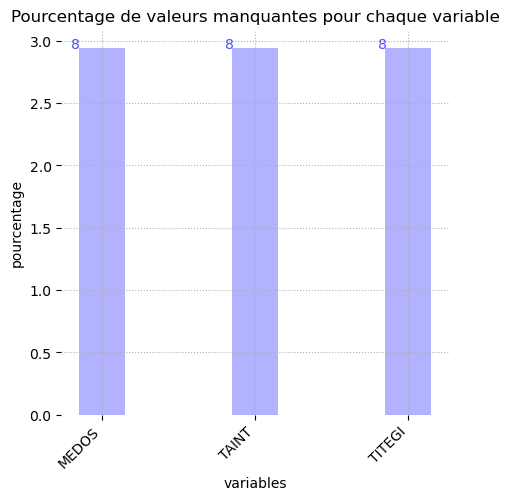

In [73]:
plot_na_null(a,a.columns,fig_size=[5,5],plot_null=False)

### One-hot encoding

In [74]:
"""OK"""
def one_hot_encode(df,num_cols,cat_cols):
    """
    Cette fonction permet de one-hot encoder le jeu 
    d'entraînement et le jeu de test. 

    Input:
    -------
    - df (dataframe): jeu de données entier (données de
      train et de test non séparées pour le moment).
    - cat_cols (list): variables qualitatives.
    - num_cols (list): variables quantitatives.

    Output:
    ------
    - df_oh (dataframe): jeu de données one-hot encodé.  
    """

    # Noms des colonnes qualitatives et quantitatves 
    # num_cols = df.select_dtypes(exclude=['category']).columns.tolist()
    # cat_cols = df.select_dtypes(include=['category']).columns.tolist()

    # dataframe réduite aux variables quantitatives
    df_num = df[num_cols]
    # dataframe réduite aux variables qualitatives + one-hot encoding
    df_cat = pd.get_dummies(df[cat_cols],drop_first = True)
    # concaténation des datafrmes quantitatifs et qualitatifs
    df_oh = pd.concat([df_num,df_cat],axis=1)
    
    return df_oh

Mettre toutes les TS à la même longeur: peut-être pas besoin ici car on a 1 TS multivariée et pas plusieurs TS multivariées.

Rocket: variable lentgth time series https://forums.fast.ai/t/time-series-sequential-data-study-group/29686/532?page=27

https://mrmint.fr/multivariate-regression 

### MiniRocket

#### Multivarié (Slinding Windows)

In [75]:
# Librairies nécessaires pour MiniRocket
# ---------------------------------------------
from tsai.basics import *

from tsai.models.MINIROCKET import *
from sklearn.metrics import mean_squared_error, make_scorer
    
import sktime
import sklearn

my_setup(sktime, sklearn) 

os              : Windows-10-10.0.19041-SP0
python          : 3.7.2
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.28
sktime          : 0.16.0
sklearn         : 1.0.2
torch           : 1.13.1+cpu
device          : cpu
cpu cores       : 4
threads per cpu : 2
RAM             : 15.81 GB
GPU memory      : N/A


In [76]:
# One-hot Encoding des données
# -------------------------------------------
credits_MTS_oh = one_hot_encode(df=credits_MTS,num_cols=VAR_QUANTI_CREDIT_n + VAR_REP,cat_cols=VAR_QUALI_CREDIT_n)

In [77]:
"""OK"""
def run_miniRocket_multi(df,var_rep,window_length=9,n_estimators=5,valid_size=.2):
    """
    Cette fonction permet d'appliquer le modèle MiniRocket dans le cas 
    de données multivariées, après que celles-ci aient été préalablement
    one-hot encodées. Cependant, il n'est pas nécessaire de renormaliser 
    les variables.
    La fonction sépare le jeu de données en jeu de train et jeu de test. 
    Il n'y a donc pas besoin de séparer en train et en test au préalable.  

    Input:
    ------
    - df (dataframe): dataframe contenant les données (une sélection de 
      variable retenant les variables explicatives les plus pertinentes 
      peut être appliquée). 
    - var_rep (liste): variable réponse ['NB_DOSS_DAY'] (sous forme de liste)
    - window_length (int): taille de la fenêtre glissante. 
    - n_estimators (int): nombre de modèles MiniRockets qui sont fit.
      Les prédictions sont une moyenne de tous les modèles MiniRockets entrainés.
    - valid_size (float): taille du dataset de test.
    
    Output:
    -------
    - y_pred (np.array): valeurs réelles et valeurs prédites.
      On renvoie aussi les valeurs réelles pour les graphes + tard.
    - rmse (float): valeur du rmse calculé sur les donné de test 
    - splits (liste): liste de tableaux contenant les indices du jeu 
      de train et du jeu de test. 
    
    ================================== Notes =====================================
    
    Les variables explicatives sont X=[[t t t t], (toutes les variables du jeu de   
                                       [t t t t],  données credits préalablement 
                                       [t t t t],  sélectionnées sauf 'NB_DOSS_DAY')
                                       [v v v v],
                                       [v v v v]]
    
    et la variable à expliquer est y='NB_DOSS_DAY'=[t t t v v] où 
    't' représente les données de train et 'v' les données de test (validation).
    
    Afin que les données soient dans le bon format pour l'application de 
    MiniRocket, on applique une fenêtre glissante (comme indiqué par [1]). 
    La fenêtre glissante permet de passer d'un format X=(n_timesteps, n_features)
    à un format X=(n_samples, n_features, n_steps) où n_steps = window_length et 
    n_samples = n_windows = (n_timesteps - window_length)//stride + 1*(len(df)%2==0)
    De même, la réponse passe du format y=(n_timesteps) au format y=(n_samples).
    
    Pour constituer le vecteur y, la fonction SlidingWindow prend une valeur de y 
    toutes les window_length valeurs: 
    par exemple, si target = [0,1,2,3,4,5,6,7,8,9,10,11,12] et que window_length=3 
    alors y = [2,5,8,11]

    Après plusieurs test, un stride=1 est adopté pour la fenêtre glissante.
    Si stride=n>1, alors on obtiendra des valeurs prédites tous les
    n jours si les données sont regroupées par jour (ou toutes les n semaines
    si les données sont regroupées par semaines).
    Avec stride=1 ou n>1, les window_length premières valeurs sont omises. 
    
    
    La taille de la fenêtre est customisable et doit être >= 7. Après 
    plusieurs tests, de petites valeurs pour la taille de la fenêtre 
    montrent de meilleurs résultats.
    
    >>> Nous n'avons pas besoin de renormaliser les données avant d'appliquer
        MiniRocket.        
    >>> MiniRocketRegressor est recommandé pour des séries temporelles allant 
        jusqu'à 10k. Pour un jeu de données plus important, on peut utiliser 
        MINIROCKET (dans Pytorch avec GPU).
    ==============================================================================
        
    References:
    ----------
    - MiniRocket tutorial: 
        https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/10_Time_Series_Classification_and_Regression_with_MiniRocket.ipynb
        https://github.com/timeseriesAI/tsai/tree/main/tsai/models
    - librairie tsai: 
        https://timeseriesai.github.io/tsai/tslearner.html
        https://timeseriesai.github.io/tsai/tslearner.html#tsclassifier-api
        https://timeseriesai.github.io/tsai/learner.html
    - données utilisées dans la doc de la librarie tsai:
        https://timeseriesai.github.io/tsai/data.external.html
    - comment utiliser les données présentes dans la doc de tsai
        [1] https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/00c_Time_Series_data_preparation.ipynb#scrollTo=5f1tQ1G2-GxY
    - la fonction slice (replace colon in index):
        https://stackoverflow.com/questions/7813305/array-assignment-in-numpy-colon-equivalent
    - explication des sliding windows: 
        https://machinelearningmastery.com/time-series-forecasting-supervised-learning/
    - différence univarié/multivarié: 
        https://www.datacamp.com/tutorial/tutorial-time-series-forecasting
    """
    
    # liste des variables explicatives 
    exp_var = list(df.columns).copy()
    # on supprime de la liste la variable à prédire 
    exp_var.remove(var_rep[0])

    # Définition des paramètres de la fenêtre glissante
    # ------------------------------------------
    window_length = window_length # window_length is usually selected based on prior domain knowledge or by trial and error
    stride = 1 # None for non-overlapping (stride = window_length) (default = 1). 
               # This depends on how often you want to predict once the model is trained 
    start = 0  # use all data since the first time stamp (default = 0)
    get_x = exp_var # Indicates which are the columns that contain the x data.
    get_y = var_rep[0] # In multivariate time series, you must indicate which is/are the y columns
    horizon = 0  # 0 means y is taken from the last time stamp of the time sequence (default = 0)
    seq_first = True

    # Application de la fenêtre glissante
    # ------------------------------------------
    X, y = SlidingWindow(window_length, stride=stride, start=start, get_x=get_x,  
                         get_y=get_y, horizon=horizon, seq_first=seq_first)(df)

    # Calcul des indices des données de test de de train. Avec shuffle=False, on prend
    # les 80% des premières valeurs comme train et les 20% des dernières valeurs comme test.
    # ------------------------------------------
    splits = get_splits(y, valid_size=valid_size, stratify=True, random_state=23, shuffle=False)

    # Définition des set de train et de tests
    # ------------------------------------------
    X_train = X[splits[0]] ;  y_train = y[splits[0]]
    X_test  = X[splits[1]] ;   y_test = y[splits[1]]

    # Définition de la métrique et du modèle MiniRocket
    # ------------------------------------------
    rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    model = MiniRocketVotingRegressor(n_estimators=n_estimators, scoring=rmse_scorer)

    # On entraîne le modèle sur les données de train
    # ------------------------------------------
    timer.start(False) #début du timer
    print("début de l'entraînement...")
    model.fit(X_train, y_train) #entraînement du modèle
    print("...fin !")
    t = timer.stop() #fin du timer

    # On calcule les prédicitons sur les données de test
    # ------------------------------------------
    y_pred = model.predict(X_test)
    # on transforme les prédictions en entiers (car c'est le nb de crédits)
    y_pred = y_pred.astype(int)
    # on transforme les prédiction négatives en 0
    y_pred[np.where(y_pred<0)[0]] = 0
    # calcul & affichage du rmse
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f'rmse sur les données de test : {rmse:.5f} temps d\'exécution: {t}')
    
    # Comme on a appliqué des fenêtres glissantes avec stride=1, les splits sont 
    # décalés de window_length, et on doit les redéfinir.
    # ------------------------------------------
    if stride==1:
        # valeur à ajouter 
        to_add = len(df)-(len(splits[0])+len(splits[1])) 
        # pour avoir des données qui correspondent à y_test et y_pred,
        # quand on fait TS[splits[1]], on ajoute window_length à tous 
        # les termes de splits[1] 
        s1 = np.array(splits[1])+to_add
        # pour avoir des données qui correspondent aux données de train
        # quand on fait TS[splits[0]], on ajoute window_length à tous 
        # les termes de splits[0] et on ajoute une liste [0,1,...window_length]
        # pour avoir le début de la TS. 
        s0 = np.r_[np.arange(to_add),np.array(splits[0])+to_add]
        splits = (s0,s1)

    return y_pred,rmse,splits

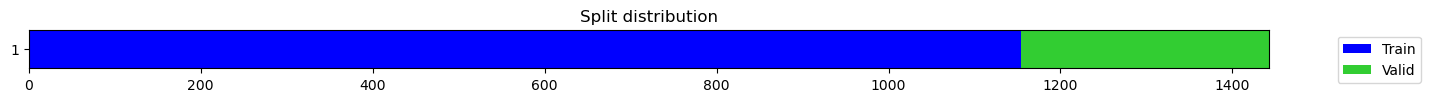

début de l'entraînement...
...fin !
rmse sur les données de test : 15.68350 temps d'exécution: 17.426098


In [78]:
y_pred,rmse,splits=run_miniRocket_multi(credits_MTS_oh,['NB_DOSS_DAY'],window_length=9,n_estimators=5)

In [79]:
"""OK"""
def plot_prediction(TS,TS_forecast,splits,conf_int=None,model_name=''):
    """
    Cette fonction trace la prédiction du modèle ARIMA,SARIMA 
    ou MiniRocket.
    
    Input:
    ------
    - TS (pd.series): série temporelle avec en index
      une date et en valeur, la variable d'intérêt.
    - TS_forecast (pd.series): valeurs prédites sur le jeu de test 
      (index: une date, valeur :variable d'intérêt).
    - splits (list): liste de 2 tableaux comprenant les indices
      tu set de train et du set de test.   
    - conf_int (np.array): intervalle de confiance pour 
      les prédictions au niveau alpha=0.05. Si conf_int=None,
      aucun intervalle de confiance n'est tracé. 
    - model_name (string): nom du modèle utilisé pour la 
      prédiction pour l'affichage du graphique.

    Output:
    ------
    - Graphique.
    """

    fig, axs = plt.subplots(3, 1, figsize=(10,13),gridspec_kw={'height_ratios':[2,1.5,1.5]})
    fig.subplots_adjust(hspace=.5)
    # =================================
    # Tracé de la prédiction
    # =================================
    # Tracé de la série temporelle de train originale
    axs[0].plot(TS.iloc[splits[0]],label='ST de train',lw=1,color='#1f77b4')
    # Tracé de la série temporelle de test originale
    axs[0].plot(TS.iloc[splits[1]],label='ST de test',lw=1,color='#ff7f0e')
    # Tracé de la série temporelle de test prédite
    axs[0].plot(TS_forecast,label='ST prédite',lw=1,color='#2ca02c')
    
    # Tracé de l'intervalle de confiance si confint!=None
    if np.any(conf_int):
        cf= pd.DataFrame(conf_int)
        axs[0].fill_between(TS_forecast.index,
                        cf[0],
                        cf[1],color='grey',alpha=.3,label='IC(alpha=0.05)')
    
    axs[0].set_title('Prédiction par le modèle '+ model_name)
    axs[0].set_xlabel('Temps')
    axs[0].set_ylabel('NB_DOSS_DAY')
    axs[0].tick_params(axis='x', rotation=45)
    axs[0].grid(ls=':')
    axs[0].legend(prop={'size': 8},loc=2)
    
    # =================================
    # Tracé de la prédiction avec zoom sur les données de test
    # =================================
    # Tracé de la série temporelle de test originale
    axs[1].plot(TS.iloc[splits[1]],label='ST de test',lw=1,color='#ff7f0e')
    # Tracé de la série temporelle de test prédite
    axs[1].plot(TS_forecast.iloc[splits[1]],label='ST prédite',lw=1,color='#2ca02c')
    axs[1].set_title('Zoom prédiction par le modèle '+ model_name)
    axs[1].set_xlabel('Temps')
    axs[1].set_ylabel('NB_DOSS_DAY')
    axs[1].tick_params(axis='x', rotation=45)
    axs[1].grid(ls=':')
    axs[1].legend(prop={'size': 8},loc=2)
    
    
    # =================================
    # Tracé de l'erreur entre valeur réelle & prédiction
    # =================================
    err = np.abs(TS - TS_forecast)
    axs[2].scatter(x=TS.index, y=err,label='abs(erreur)',s=8,color='#d62728')
    axs[2].set_title('abs(valeur réelle - valeur prédite)')
    axs[2].set_xlabel('Temps')
    axs[2].set_ylabel('NB_DOSS_DAY')
    axs[2].tick_params(axis='x', rotation=45)
    axs[2].grid(ls=':')
    
    # =================================
    # Affichage de la valeur moyenne
    # =================================
    mean_TS = int(np.mean(TS))
    mean_err = int(np.mean(err))
    print("Valeur moyenne de la ST originale: ",mean_TS)
    print("Valeur moyenne de l'erreur: ",mean_err)
    axs[2].axhline(y=mean_TS,color='blue',ls=':',label='valeur moyenne ST originale')
    axs[2].axhline(y=mean_err,color='green',ls=':',label='valeur moyenne abs(erreur)')
    axs[2].legend(prop={'size': 8},loc=2)
    
    plt.show()

Valeur moyenne de la ST originale:  29
Valeur moyenne de l'erreur:  12


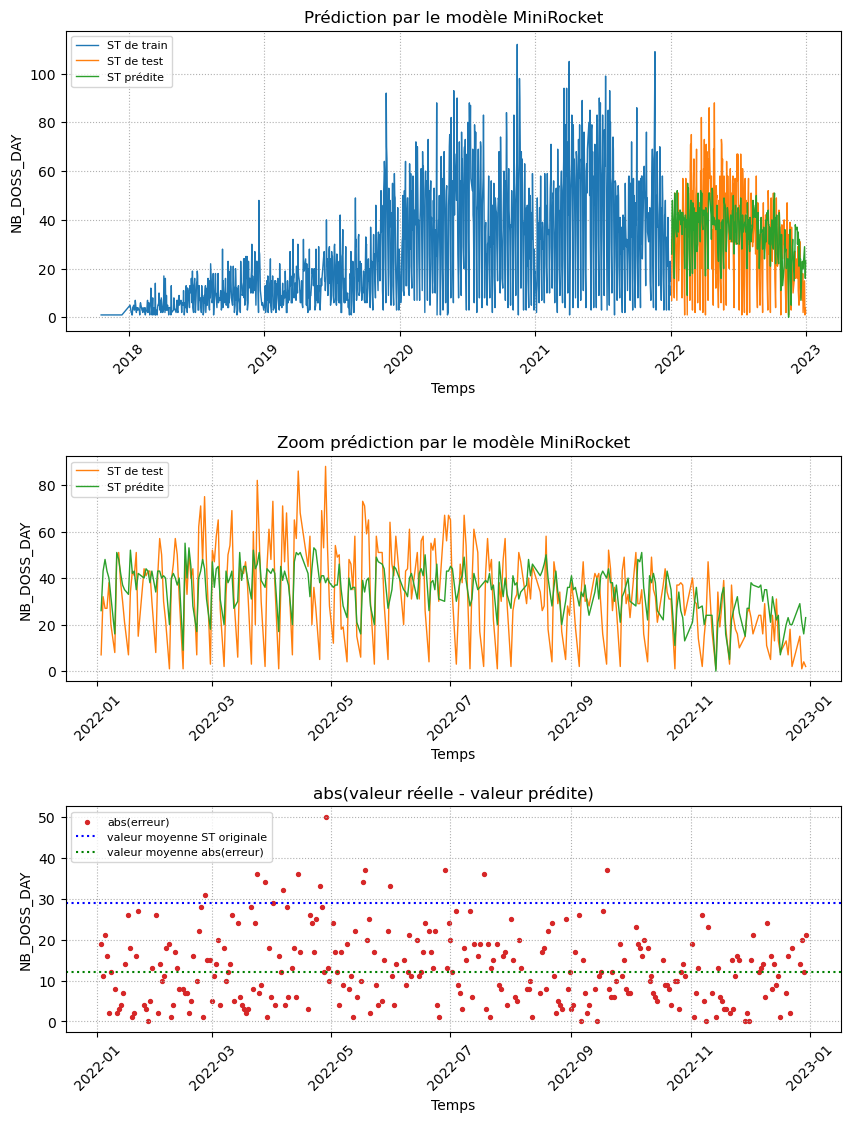

In [80]:
# Préparation de la Série temporelle pour affichage
# ----------------------------------------------
# ST avec en index une date et en valeur, la variable d'intérêt.
TS = credits_MTS['NB_DOSS_DAY'] 
TS.index = credits_MTS['DATEDI']
# ST prédite. Comme y_pred et TS[splits[1]] n'ont pas la même longueur à 
# cause des fenêtres glissantes, on effectue la manip ci-dessous
TS_forecast = TS*np.nan 
TS_forecast[-len(y_pred):] = y_pred

# Affichage de la Série temporelle
# ----------------------------------------------
plot_prediction(TS,TS_forecast,splits,conf_int=None,model_name='MiniRocket')

#### Univarié  (Slinding Windows)

In [81]:
def create_TS(df,by='day'):
    """
    Cette fonction crée une série temporelle du nombre de 'CODOSB' par jour 
    ou par semaine. La référence de temps est donnée par la variable 'DATEDI'. 
    Si on compte le nombre de 'CODOSB' par semaine, on obtient le regroupement suivant:
    ex: 2017-12-11   12
        2017-12-18   18
        2017-12-25   31
    Ce qui indique qu'il y a 31 'CODOSB' entre ]2017-12-18, 2017-12-25],  
    18 'CODOSB' entre ]2017-12-11, 2017-12-18]. 

    Input:
    ------
    - df (dataframe): dataframe contenant les données.
    - by (string): indique si on veut regrouper le nombre de 'CODOSB'
      par jours (by='day'), par jours en exclant les dimanches (by='business_day')
      ou par semaine (by='week').

    Output:
    -------
    - TS (pd.series): série temporelle avec en index une date 
      et en valeur, le nombre de 'CODOSB' par jour, buisiness day ou semaine.
      
    References:
    ---------
    * Grouper par semaine: https://www.statology.org/pandas-group-by-week/
    * Alias de groupage: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
    """
    # =============================
    # Nb de 'CODOSB' par jours
    # =============================
    #----- nb de 'CODOSB' par jours (calcule du lundi au dimanche)
    TS_day = df.groupby([pd.Grouper(key='DATEDI', freq='D')])['CODOSB'].count()
    if by=='day': 
        TS = TS_day
        
    elif by=='business_day':
        #----- nb de 'CODOSB' par jours en excluant le dimanche (calcule du lundi au samedi)
        # indices des jours n'étant pas des dimanches dans TS_day
        idx_B = np.where(TS_day.index.strftime("%A")!='Sunday')[0]
        # on de garde de TS_day, que les jours du lundi au samedi
        TS_day_B = TS_day[idx_B] 
        TS = TS_day_B
        
    # =============================
    # Nb de 'CODOSB' par semaine
    # =============================  
    elif by=='week':
        # Convertit la colonne date en datetime et soustrait une semaine
        df['DATEDI'] = pd.to_datetime(df['DATEDI']) - pd.to_timedelta(7, unit='d')
        # Calcule la somme des valeurs, regroupées par semaine. On obtient en index, 
        # les dates correspondant à des lundis et en valeur, le nb de 'CODOSB' par semaine. 
        TS_week = df.groupby([pd.Grouper(key='DATEDI', freq='W-MON')])['CODOSB'].count()
        TS = TS_week
        
    # On trie la série temporelle (normalement elle est déjà triée)    
    TS.sort_index(inplace=True)
    
    return TS

In [82]:
TS_day = create_TS(credits,by='day')
TS_day_B = create_TS(credits,by='business_day')
TS_week = create_TS(credits,by='week')

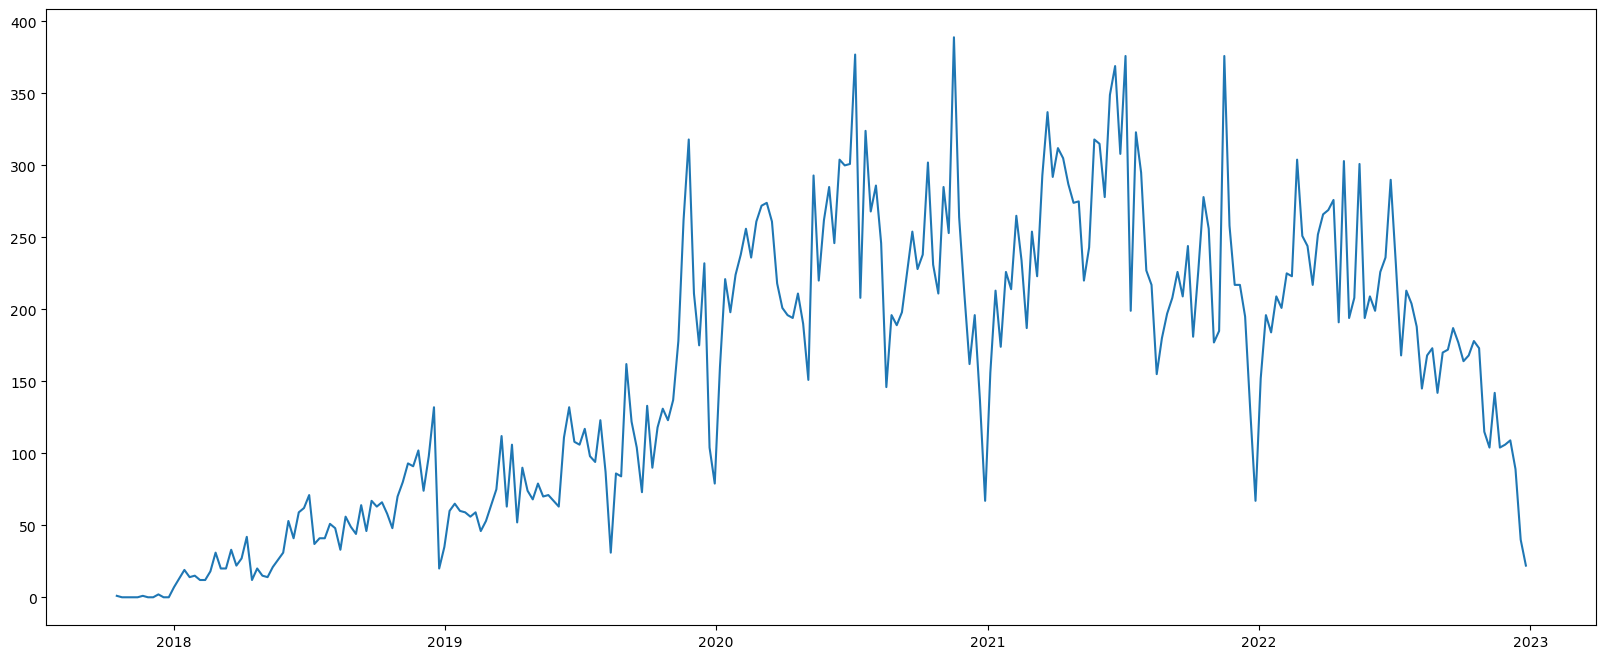

In [83]:
plt.figure(figsize=(20,8))
plt.plot(TS_week)

<font color = 'red'> __Regarder pourquoi en 2018 et fin 2022 on a des données nulles... -> j'ai regardé et on dirait que je n'ai pas fait d'erreurs__  </font>

In [84]:
"""OK"""
def run_miniRocket_uni(TS_,window_length=9,n_estimators=5,valid_size=.2):
    """
    Cette fonction permet d'appliquer le modèle MiniRocket dans le cas 
    de données univariées. 
    La fonction sépare le jeu de données en jeu de train et jeu de test. 
    Il n'y a donc pas besoin de séparer en train et en test au préalable.  

    Input:
    ------
    - TS (pd.series): série temporelle avec en index
      une date et en valeur, la variable d'intérêt.
    - window_length (int): taille de la fenêtre glissante. 
    - n_estimators (int): nombre de modèles MiniRockets qui sont fit.
      Les prédictions sont une moyenne de tous les modèles MiniRockets entrainés.
    - valid_size (float): taille du dataset de test.
    
    Output:
    -------
    - y_pred (np.array): valeurs réelles et valeurs prédites.
      On renvoie aussi les valeurs réelles pour les graphes + tard.
    - rmse (float): valeur du rmse calculé sur les donné de test 
    - splits (liste): liste de tableaux contenant les indices du jeu 
      de train et du jeu de test. 
    
    ================================== Notes =====================================
    
    La série temporelle est TS=[[t]     
                                [t],  
                                [t],  
                                [v],
                                [v]]
    
    avec TS='NB_DOSS_DAY où 't' représente les données de train et
    'v' les données de test (validation).
    
    Afin que les données soient dans le bon format pour l'application de 
    MiniRocket, on applique une fenêtre glissante (comme indiqué par [1]). 
    La fenêtre glissante permet de passer d'un format TS=(n_timesteps)
    à un format X=(n_samples, 1 , n_steps) où n_steps = window_length et 
    n_samples = n_windows = (n_timesteps - window_length)//stride + 1*(len(df)%2==0).
    De même, la réponse devient est au format y=(n_samples).
    
    Pour constituer le vecteur y, la fonction SlidingWindow prend une valeur de TS 
    toutes les window_length valeurs: 
    par exemple, si TS = [0,1,2,3,4,5,6,7,8,9,10,11,12] et que window_length=3 
    alors y = [2,5,8,11]

    Après plusieurs test, un stride=1 est adopté pour la fenêtre glissante.
    Si stride=n>1, alors on obtiendra des valeurs prédites tous les
    n jours si les données sont regroupées par jour (ou toutes les n semaines
    si les données sont regroupées par semaines).
    Avec stride=1 ou n>1, les window_length premières valeurs sont omises. 
    
    La taille de la fenêtre est customisable et doit être >= 7. Après 
    plusieurs tests, de petites valeurs pour la taille de la fenêtre 
    montrent de meilleurs résultats.
    
    >>> Nous n'avons pas besoin de renormaliser les données avant d'appliquer
        MiniRocket.        
    >>> MiniRocketRegressor est recommandé pour des séries temporelles allant 
        jusqu'à 10k. Pour un jeu de données plus important, on peut utiliser 
        MINIROCKET (dans Pytorch avec GPU).
    ==============================================================================
        
    References:
    ----------
    - MiniRocket tutorial: 
        https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/10_Time_Series_Classification_and_Regression_with_MiniRocket.ipynb
        https://github.com/timeseriesAI/tsai/tree/main/tsai/models
    - librairie tsai: 
        https://timeseriesai.github.io/tsai/tslearner.html
        https://timeseriesai.github.io/tsai/tslearner.html#tsclassifier-api
        https://timeseriesai.github.io/tsai/learner.html
    - données utilisées dans la doc de la librarie tsai:
        https://timeseriesai.github.io/tsai/data.external.html
    - comment utiliser les données présentes dans la doc de tsai
        [1] https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/00c_Time_Series_data_preparation.ipynb#scrollTo=5f1tQ1G2-GxY
    - la fonction slice (replace colon in index):
        https://stackoverflow.com/questions/7813305/array-assignment-in-numpy-colon-equivalent
    - explication des sliding windows: 
        https://machinelearningmastery.com/time-series-forecasting-supervised-learning/
    - différence univarié/multivarié: 
        https://www.datacamp.com/tutorial/tutorial-time-series-forecasting
    """
    
    # La TS passée en argument peut contenir des dates en index.
    # On réinitialise les indices
    # ------------------------------------------
    TS = TS_.copy()
    TS.reset_index(drop=True,inplace=True)
    
    # Définition des paramètres de la fenêtre glissante
    # ------------------------------------------
    window_length = window_length # window_length is usually selected based on prior domain knowledge or by trial and error
    stride = 1 # None for non-overlapping (stride = window_length) (default = 1). 
               # This depends on how often you want to predict once the model is trained 
    horizon = 1 

    # Application de la fenêtre glissante
    # ------------------------------------------
    X, y = SlidingWindow(window_length, stride=stride, horizon=horizon)(TS)

    # Calcul des indices des données de test de de train. Avec shuffle=False, on prend
    # les 80% des premières valeurs comme train et les 20% des dernières valeurs comme test.
    # ------------------------------------------
    splits = get_splits(y, valid_size=valid_size, stratify=True, random_state=23, shuffle=False)
    
    # Définition des set de train et de tests
    # ------------------------------------------
    X_train = X[splits[0]] ;  y_train = y[splits[0]]
    X_test  = X[splits[1]] ;   y_test = y[splits[1]]

    # Définition de la métrique et du modèle MiniRocket
    # ------------------------------------------
    rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    model = MiniRocketVotingRegressor(n_estimators=n_estimators, scoring=rmse_scorer)

    # On entraîne le modèle sur les données de train
    # ------------------------------------------
    timer.start(False) #début du timer
    print("début de l'entraînement...")
    model.fit(X_train, y_train) #entraînement du modèle
    print("...fin !")
    t = timer.stop() #fin du timer

    # On calcule les prédicitons sur les données de test
    # ------------------------------------------
    y_pred = model.predict(X_test)
    # on transforme les prédictions en entiers (car c'est le nb de crédits)
    y_pred = y_pred.astype(int)
    # on transforme les prédiction négatives en 0
    y_pred[np.where(y_pred<0)[0]] = 0
    # calcul & affichage du rmse
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f'rmse sur les données de test : {rmse:.5f} temps d\'exécution: {t}')
    
    # Comme on a appliqué des fenêtres glissantes avec stride=1, les splits sont 
    # décalés de window_length, et on doit les redéfinir.
    # ------------------------------------------
    if stride==1:
        # valeur à ajouter 
        to_add = len(TS)-(len(splits[0])+len(splits[1])) 
        # pour avoir des données qui correspondent à y_test et y_pred,
        # quand on fait TS[splits[1]], on ajoute window_length à tous 
        # les termes de splits[1] 
        s1 = np.array(splits[1])+to_add
        # pour avoir des données qui correspondent aux données de train
        # quand on fait TS[splits[0]], on ajoute window_length à tous 
        # les termes de splits[0] et on ajoute une liste [0,1,...window_length]
        # pour avoir le début de la TS. 
        s0 = np.r_[np.arange(to_add),np.array(splits[0])+to_add]
        splits = (s0,s1)

    return y_pred,rmse,splits 

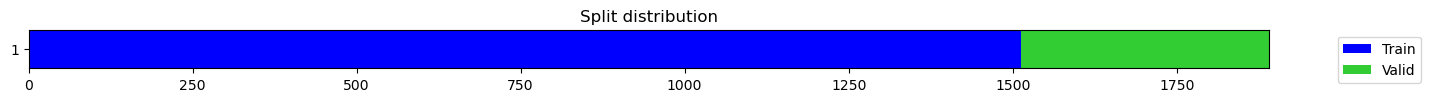

début de l'entraînement...
...fin !
rmse sur les données de test : 11.77220 temps d'exécution: 19.672602


In [85]:
y_pred,rmse,splits = run_miniRocket_uni(TS_day,window_length=9,n_estimators=5)

Valeur moyenne de la ST originale:  22
Valeur moyenne de l'erreur:  8


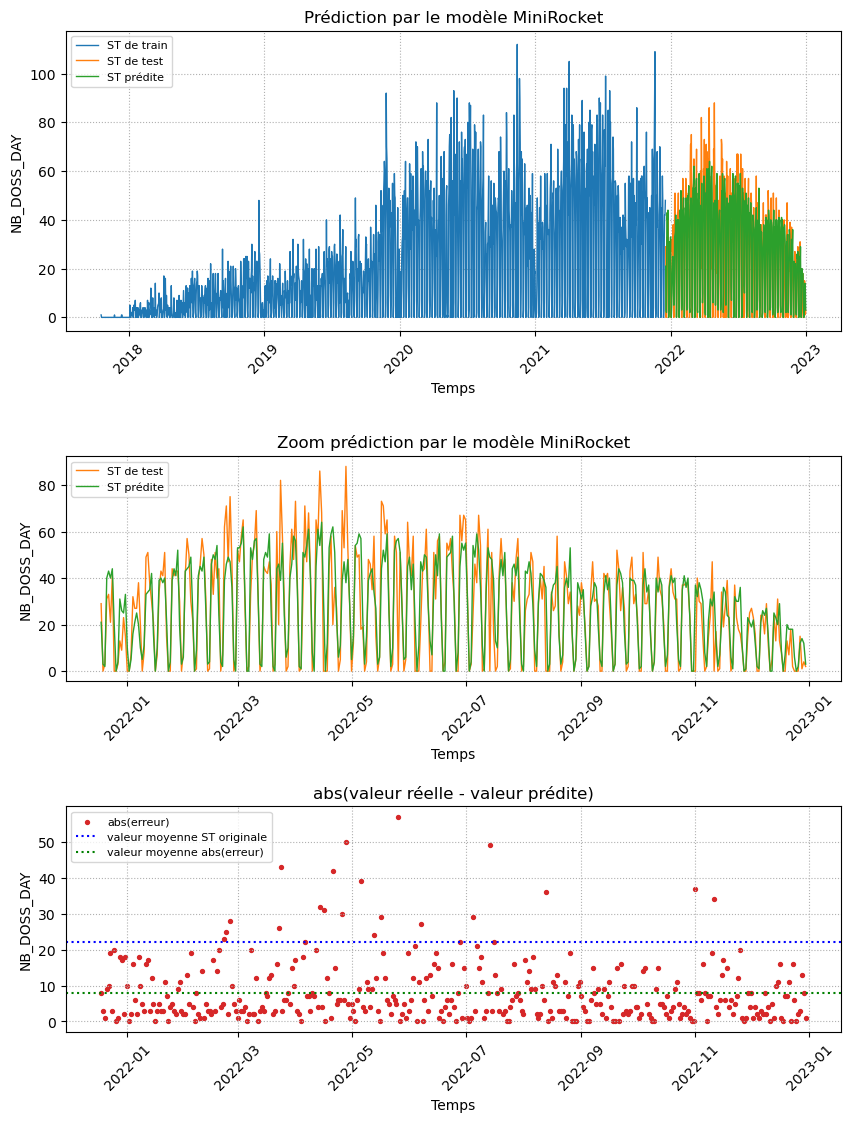

In [86]:
# Préparation de la Série temporelle pour affichage
# ----------------------------------------------
TS=TS_day.copy()
# ST prédite. Comme y_pred et TS[splits[1]] n'ont pas la même longueur à 
# cause des fenêtres glissantes, on effectue la manip ci-dessous
TS_forecast = TS*np.nan 
TS_forecast[-len(y_pred):] = y_pred

# Affichage de la Série temporelle
# ----------------------------------------------
plot_prediction(TS,TS_forecast,splits,conf_int=None,model_name='MiniRocket')

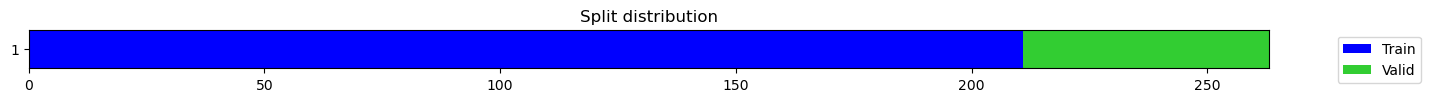

début de l'entraînement...
...fin !
rmse sur les données de test : 39.85092 temps d'exécution: 0.424823


In [87]:
y_pred,rmse,splits = run_miniRocket_uni(TS_week,window_length=9,n_estimators=5)

Valeur moyenne de la ST originale:  156
Valeur moyenne de l'erreur:  30


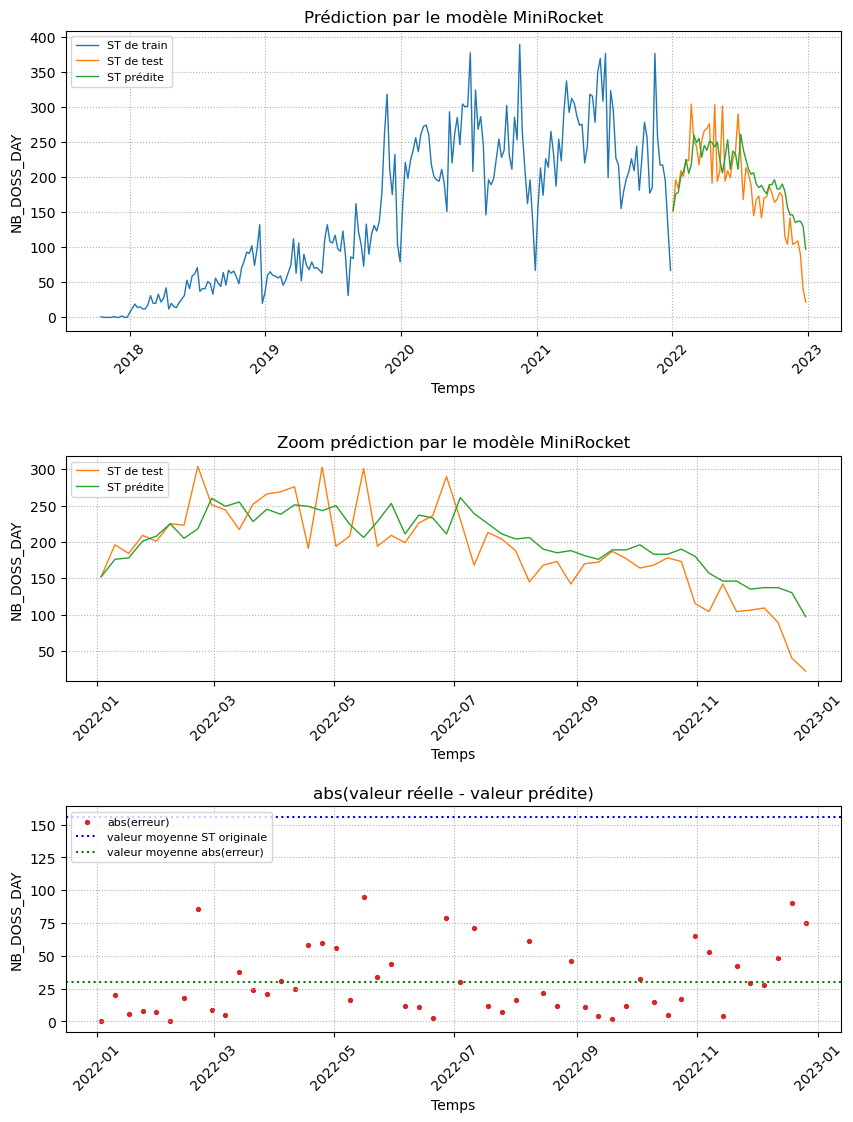

In [88]:
# Préparation de la Série temporelle pour affichage
# ----------------------------------------------
TS=TS_week.copy()
# ST prédite. Comme y_pred et TS[splits[1]] n'ont pas la même longueur à 
# cause des fenêtres glissantes, on effectue la manip ci-dessous
TS_forecast = TS*np.nan 
TS_forecast[-len(y_pred):] = y_pred

# Affichage de la Série temporelle
# ----------------------------------------------
plot_prediction(TS,TS_forecast,splits,conf_int=None,model_name='MiniRocket')

### Essayons de débruiter/transformer le signal

 SARIMAX: https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html#statsmodels.tsa.statespace.sarimax.SARIMAX & https://www.statsmodels.org/stable/api.html#univariate-time-series-analysis

#### Débruitage signal Ondelettes

Alors que la transformée de Fourier crée une représentation du signal dans le domaine des fréquences, la transformée en ondelettes crée une représentation du signal à la fois dans le domaine temporel et dans le domaine des fréquences, permettant ainsi un accès efficace à des informations localisées sur le signal. Le débruitage en Ondelettes permet aussi de débruiter des signaux plus irréguliers.

In [24]:
import pylab as pyl
import pywt
import scipy as scp

#import holoviews as hv # pip install "holoviews[recommended]"
#hv.extension("bokeh")

import param
import panel as pn

pn.extension()

In [90]:
"""OK"""
def psnr(Sref, Sd):
    """
    Cette fonction calcule le PSNR permettant de quantifier 
    la qualité de reconstruction du signal compressé par 
    rapport au signal originale.
    Un PSNR plus élevé indique généralement que la reconstruction
    est de meilleure qualité. La valeur maximale est 100. 
    
    Input:
    -----
    - Sref (np.array): signal original
    - Sd (np.array): signal débruité. 
    
    Output:
    ------
    - PSNR (float): valeur du PSNR
    """
    mse = np.mean((Sref - Sd) ** 2)
    if mse == 0:
        return 100
    Val_MAX = max(Sref)
    PSNR = 20 * np.log10(Val_MAX / np.sqrt(mse))
    return PSNR

In [91]:
"""OK"""
def EstimEcartTypeBruit(sb,qmf):
    """

    Cette fonction estime l'écart-type du bruit d'un signal. 
    Cette méthode suppose un bruit gaussien. 
    
    
    Input:
    ------
    - sb (np.array): signal bruité
    - qmf (string): base d'ondelettes de PyWavelets ('haar','db2','db3'...)
      Pour le débruitage, les bases Symlet ('sym') ou Daubechies ('db') sont recommandée [2].
      Le numéro 'N' dans 'dbN' est le nombre de moments nuls de la base d'ondelettes.
      Plus il y a de moments nuls, plus la base d'ondelettes peut représenter des fonctions
      complexes avec peu de coefficients d'ondelette.
      (voir toutes les ondelettes disponibles: pywt.families() et pywt.wavelist('db'))
    
    Output:
    -------
    - sigma (float): estimation de l'écart type des coefficients
      de bruits.

    =================== Notes issues de [1] ===================
    On peut estimer la variance du bruit d'un signal en utilisant les coefficients d'ondelettes.
    En effet on peut exploiter le fait qu'aux fines échelles, l'essentiel des coefficients 
    sont dus au bruit. La moyenne des valeurs absolue des coefficients du signal bruité
    peut être lourdement impacté par les coefficients du signal mais pas la médiane. 
    Si X est une variable gaussienne centrée réduite, la médiane m de sa valeur absolue 
    vérifie P(X>m)=0.25. L'espérance de cette médiane des coefficients du bruit 
    est donnée par np.sqrt(2)*scp.special.erfinv(0.5) où scp.special.erfinv est 
    la l'inverse de la error function.
    ==========================================================

    Références:
    ---------
    Estimation du bruit:
    - Cours signal Ondelettes INSA 4A [1].
    - https://www.scielo.br/j/bcg/a/Sk5YwZC3vwNbBH6R3mJrQyC/?lang=en
    - https://ieeexplore.ieee.org/document/9321739 (télécharger le pdf ici:
    https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=
    2ahUKEwj846T43pT9AhWRUqQEHYpFA9EQFnoECAoQAQ&url=https%3A%2F%2Fnightlessbaron
    .github.io%2Ffiles%2Fpublications%2FDIP_IEEE.pdf&usg=AOvVaw0AmaueY3uK2N0e6b-1KXJo)
    - https://en.wikipedia.org/wiki/Error_function
    
    Quelle base d'ondelette choisir: 
    - https://www.mathworks.com/help/wavelet/gs/choose-a-wavelet.html [2]
    - https://math.stackexchange.com/questions/128165/what-is-a-vanishing-moment
    """
    # niveau maximal de la décomposition en ondelettes
    Lmax=pywt.dwt_max_level(len(sb),pywt.Wavelet(qmf).dec_len)
    # décomposition en ondelettes
    wsb=pywt.wavedec(sb, qmf, mode='per', level=Lmax)
    # Espérance de la médiane des coefficients de bruit
    mt=np.sqrt(2)*scp.special.erfinv(0.5)
    # ecart-type du bruit
    sigma = np.median(np.abs(wsb[Lmax]))/mt
    return sigma

In [92]:
# Tests de la fonction EstimEcartTypeBruit
# ----------------------------------------------
sigma_day = EstimEcartTypeBruit(sb=TS_day.values,qmf='db30')
sigma_week = EstimEcartTypeBruit(sb=TS_week.values,qmf='db30')
print("Bruit estimé pour la série temporelle par jours: ",sigma_day)
print("Bruit estimé pour la série temporelle par semaines: ",sigma_week)

Bruit estimé pour la série temporelle par jours:  9.896759928800456
Bruit estimé pour la série temporelle par semaines:  22.172725023222398


In [93]:
"""OK"""
def SeuillageOndelette(SB,qmf,Seuil,L=None):
    """
    Cette fonction permet de faire un seuillage doux en Ondelettes. 
    
    Input:
    -----
    - SB (np.array): signal à débruiter.
    - qmf (string): base d'ondelettes de PyWavelets ('haar','db2','db3'...)
      Pour le débruitage, les bases Symlet ('sym') ou Daubechies ('db') sont recommandée [2].
      Le numéro 'N' dans 'dbN' est le nombre de moments nuls de la base d'ondelettes.
      Plus il y a de moments nuls, plus la base d'ondelettes peut représenter des fonctions
      complexes avec peu de coefficients d'ondelette.
      (voir toutes les ondelettes disponibles: pywt.families() et pywt.wavelist('db'))
    - L (int): niveau maximal de la transformée en Ondelettes. Si L=None, ce 
      niveau est caculé
    - Seuil (float): Seuil pour le seuillage doux en Ondelettes.
    
    Output:
    ------
    - Srec (np.array): signal débruité.
    
    ======================= Notes =======================
    Le bruit d'un signal est généralement concentré sur les coefficients
    d'ondelettes de plus haut niveau (les plus précis).
    On calcule les coefficients d'ondelettes du signal d'entrée SB. 
    On conserve uniquement les coefficients qui sont supérieurs à
    un certain seuil en valeur absolue. On fait la transformée 
    en Ondelettes inverse pour reconstruire le signal. 
    Le signal reconstruit est débruité.
    ====================================================
    
    Références:
    ---------
    - Cours signal Ondelettes INSA 4A.
    Quelle base d'ondelette choisir: 
    - https://www.mathworks.com/help/wavelet/gs/choose-a-wavelet.html [2]
    - https://math.stackexchange.com/questions/128165/what-is-a-vanishing-moment
    """
    # Multilevel 1D Discrete Wavelet Transform of data.
    WTB= pywt.wavedecn(SB, qmf, mode='per', level=L)
    # Arrange a wavelet coefficient list from wavedecn into a single array.
    arr, coeff_slices = pywt.coeffs_to_array(WTB)
    # Selection des coefficients d'ondelettes supérieurs en valeur absolue au Seuil
    WTS=arr*(np.abs(arr)>Seuil)
    # Convert a combined array of coefficients back to a list compatible with waverecn.
    coeffs_from_arr = pywt.array_to_coeffs(WTS, coeff_slices)
    # Multilevel nD Inverse Discrete Wavelet Transform.
    Srec=pywt.waverecn(coeffs_from_arr,qmf,mode='per')
    # Si len(SB) est impair, alors la dernière valeur de Srec est doublée 
    if len(SB)%2 !=0:
        Srec=Srec[:-1] #on retire la dernière valeur 
    return Srec

In [94]:
# Tests de la fonction SeuillageOndelette
# ----------------------------------------------
TSrec_day = SeuillageOndelette(TS_day,qmf='db30',Seuil=10,L=None)

In [95]:
"""OK"""
def Debruit(SB,qmf,T):
    """
    Cette fonction permet de faire le débruitage d'un signal 
    SB en utilisant les coefficients d'ondelette.
    Utilise la fonction 'EstimEcartTypeBruit' pour estimer le
    bruit du signal afin de calculer le seuil intervant dans 
    le calcul du seuillage doux en ondelettes de la fonction
    'SeuillageOndelette'.
    
    Input:
    -----
    - SB (np.array): signal à débruiter.
    - qmf (string): base d'ondelettes de PyWavelets ('haar','db2','db3'...)
      Pour le débruitage, les bases Symlet ('sym') ou Daubechies ('db') sont recommandée [2].
      Le numéro 'N' dans 'dbN' est le nombre de moments nuls de la base d'ondelettes.
      Plus il y a de moments nuls, plus la base d'ondelettes peut représenter des fonctions
      complexes avec peu de coefficients d'ondelette.
      (voir toutes les ondelettes disponibles: pywt.families() et pywt.wavelist('db'))
    - T (float): Le seuil du seuillage doux en ondelettes est calculé comme Seuil=T*sigma
      où sigma a été estimée par 'EstimEcartTypeBruit'.
    
    Output:
    ------
    - Srec (np.array): signal débruité.
    - PSNR (float): valeur du psnr
    
    Références:
    ---------
    - Cours signal Ondelettes INSA 4A.
    Quelle base d'ondelette choisir: 
    - https://www.mathworks.com/help/wavelet/gs/choose-a-wavelet.html [2]
    - https://math.stackexchange.com/questions/128165/what-is-a-vanishing-moment
    """
    # Calcul du niveau maximal de décomposition en ondelettes 
    Lmax=pywt.dwt_max_level(len(SB),pywt.Wavelet(qmf).dec_len)
    # Estimation du bruit du signal avec les coefficients d'ondelette
    sigma = EstimEcartTypeBruit(SB,qmf)
    # Calcul du seuil pour le seuillage doux en ondelettes
    Seuil=T*sigma
    # Seuillage doux en ondelettes donnant le signal débruité
    Srec=SeuillageOndelette(SB,qmf,Seuil,Lmax)
    # Calcul du psnr entre le signal d'origine et le signal débruité
    PSNR=psnr(SB,Srec)
    return Srec,PSNR

In [96]:
# Tests de la fonction Debruit
# ----------------------------------------------
Srec,PSNR = Debruit(TS_day,qmf='sym20',T=.1)

In [97]:
"""OK"""
def DebruitTrans(SB,qmf,T,trans):
    """
    Cette fonction permet de faire le débruitage d'un signal 
    SB en utilisant les coefficients d'ondelette.
    Utilise la fonction 'EstimEcartTypeBruit' pour estimer le
    bruit du signal afin de calculer le seuil intervant dans 
    le calcul du seuillage doux en ondelettes de la fonction
    'SeuillageOndelette'.

    De plus, la performance du débruitage par seuillage doux en Ondelettes 
    peut être améliorée en utilisant le fait que la transformée en ondelettes 
    n'est pas invariante par translation. Ainsi si on effectue un shift 
    circulaire sur les composantes d'un vecteur, on modifie l'amplitude
    des coefficients d'ondelettes. On peut exploiter cette propriété pour
    le débruitage en effectuant un débruitage d'un même signal dans des 
    bases d'ondelettes translatées.

    Input:
    -----
    - SB (np.array): signal à débruiter.
    - qmf (string): base d'ondelettes de PyWavelets ('haar','db2','db3'...)
      Pour le débruitage, les bases Symlet ('sym') ou Daubechies ('db') sont recommandée [2].
      Le numéro 'N' dans 'dbN' est le nombre de moments nuls de la base d'ondelettes.
      Plus il y a de moments nuls, plus la base d'ondelettes peut représenter des fonctions
      complexes avec peu de coefficients d'ondelette.
      (voir toutes les ondelettes disponibles: pywt.families() et pywt.wavelist('db'))
    - T (float): Le seuil du seuillage doux en ondelettes est calculé comme Seuil=T*sigma
      où sigma a été estimée par 'EstimEcartTypeBruit'.
    - trans (integer): valeur de la translation.

    Output:
    ------
    - Srec (np.array): signal débruité.
    - PSNR (float): valeur du psnr

    Références:
    ---------
    - Cours signal Ondelettes INSA 4A.
    Quelle base d'ondelette choisir: 
    - https://www.mathworks.com/help/wavelet/gs/choose-a-wavelet.html [2]
    - https://math.stackexchange.com/questions/128165/what-is-a-vanishing-moment
    """
    # Calcul du niveau maximal de décomposition en ondelettes 
    Lmax=pywt.dwt_max_level(len(SB),pywt.Wavelet(qmf).dec_len)
    # Estimation du bruit du signal avec les coefficients d'ondelette
    sigma = EstimEcartTypeBruit(SB,qmf)
    # Calcul du seuil pour le seuillage doux en ondelettes
    Seuil=T*sigma
    SSum=0*SB
    # Vecteur contenant les psnr pour chaque translation
    P=np.zeros(trans)
    for k in np.arange(0,trans):
        # Translation du signal SB de k valeurs
        SBtemp=np.roll(SB,k)
        # Seuillage doux en ondelettes du signal translaté
        # donnant le signal reconstitué
        Srectemp=SeuillageOndelette(SBtemp,qmf,Seuil,Lmax)
        # Translation inverse du signal reconstitué de k valeurs
        Srectemp2=np.roll(Srectemp,-k)
        # Somme des signaux reconstitués
        SSum=SSum+Srectemp2
        # Calcule une moyenne des signaux reconstitués
        Srec=SSum/(k+1)
        # Calcule le psnr de la reconstitution
        P[k]=psnr(SB,Srec)
    # Calcul du PSNR moyen
    PSNR = np.mean(P)
    return Srec,PSNR

In [98]:
# Tests de la fonction DebruitTrans
# ----------------------------------------------
Srec,PSNR = DebruitTrans(TS_day,qmf='haar',T=1,trans=8)

In [99]:
"""OK mais remplacée par une autre fonction au final
qui s'appelle plot_dash_debruitTrans car cette fonction ne 
marchait plus je ne sais pas pourquoi"""

class WaveDebruit(param.Parameterized):
    """
    Cette fonction permet d'afficher le débruitage d'un signal 
    issu de la fonction 'DebruitTrans'. L'affichage est intéractif
    Pour plus d'info, voir la doc de 'DebruitTrans'.
    
    Pour l'utiliser, exécuter :
    wavedebruit = WaveDebruit()
    pn.Row(wavedebruit.param,wavedebruit.view(TS_day,TS_week))
    
    où 
    - TS_day (pd.series): série temporelle avec en index une date 
      et en valeur, le nombre de 'CODOSB' par jour.
    - TS_week (pd.series): série temporelle avec en index une date 
      et en valeur, le nombre de 'CODOSB' par semaine.
    """
    # Liste des bases d'ondelettes possibles
    wavelist = pywt.wavelist('haar') + pywt.wavelist('db') + pywt.wavelist('sym')
    
    # Définition des curseurs
    Signal =  param.ObjectSelector(default="TS_week",objects=["TS_week","TS_day"])
    wave = param.ObjectSelector(default="haar",objects=wavelist)
    T = param.Number(3,bounds=(0,8))
    translation = param.Integer(3,bounds=(0,len(TS_week)//2))
    index0 = param.Integer(0,bounds=(0,None))
    index1 = param.Integer(len(TS_day),bounds=(0,None))
    
    def view(self):
        if self.Signal == "TS_week":
            SB = TS_week
        elif self.Signal == "TS_day":
            SB = TS_day
            
        Srec,PSNR = DebruitTrans(SB,self.wave,self.T,self.translation)
        
        fig, axs = plt.subplots(2,1, figsize=(10,8))
        plt.subplots_adjust(hspace=0.5)
        
        frame = [self.index0,self.index1]

        # Graphique de la série temporelle d'origine
        #--------------------------------
        axs[0].plot(SB[slice(frame[0],frame[1])])
        axs[0].set_title("Signal d'origine")
        axs[0].set_xlabel("Temps")
        axs[0].tick_params(axis='x', rotation=45)
        axs[0].set_ylabel("NB_DOSS_DAY")
        axs[0].grid(linestyle=':')

        # Graphique de la série débruitée
        #--------------------------------
        axs[1].plot(Srec[slice(frame[0],frame[1])])
        axs[1].set_title("Signal débruité\nPSNR={}".format(round(PSNR,2)))
        axs[1].set_xlabel("Temps")
        axs[1].tick_params(axis='x', rotation=45)
        axs[1].set_ylabel("NB_DOSS_DAY")
        axs[1].grid(linestyle=':')
        plt.close()
            
        return pn.Column(fig)

Row
    [0] Column(margin=5, name='WaveDebruit', width=300)
        [0] StaticText(value='<b>WaveDebruit</b>')
        [1] Select(name='Signal', options=OrderedDict([('TS_week', ...]), value='TS_week')
        [2] Select(name='Wave', options=OrderedDict([('haar', ...]), value='haar')
        [3] FloatSlider(end=8, name='T', value=3)
        [4] IntSlider(end=136, name='Translation', value=3)
        [5] IntInput(name='Index0', start=0)
        [6] IntInput(name='Index1', start=0, value=1899)
    [1] Column
        [0] Matplotlib(Figure, height=576, width=720)
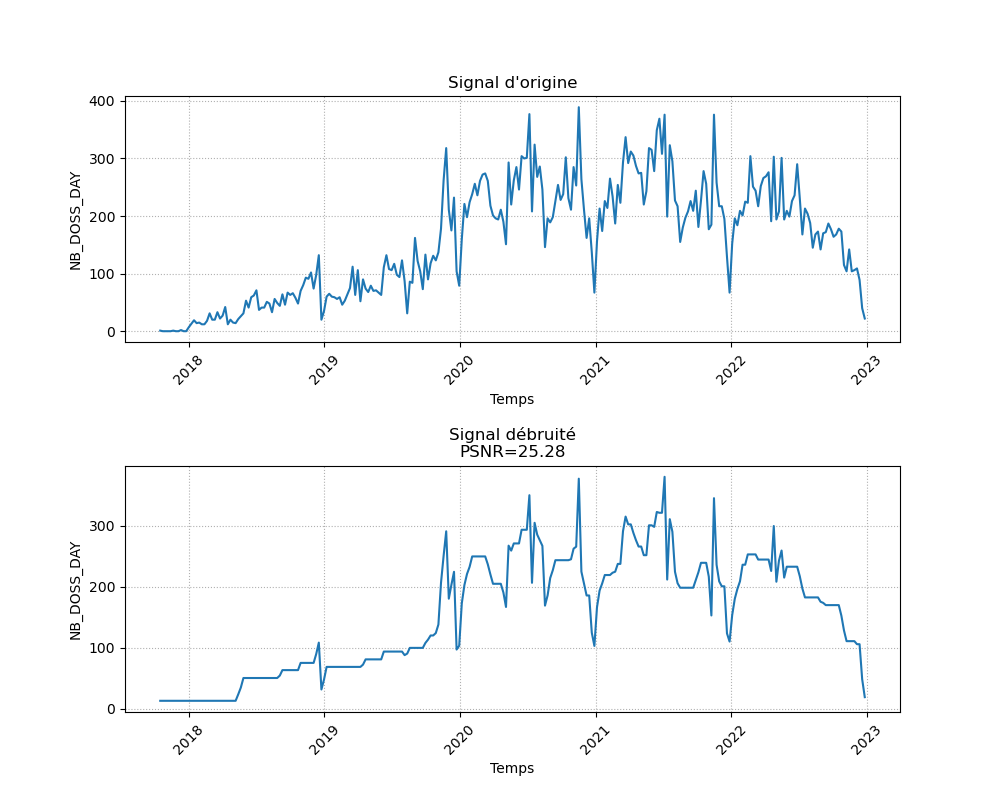

In [100]:
wavedebruit = WaveDebruit()
pn.Row(wavedebruit.param,wavedebruit.view())

In [ ]:
"""OK"""
def plot_DebruitTrans(SB,qmf,T,trans,frame=[None,None],fig_size=[10,8]):
    """
    Cette fonction permet d'afficher le débruitage d'un signal 
    à l'aide de la fonction 'DebruitTrans'. 
    Pour plus d'info, voir la doc de 'DebruitTrans'.

    Input:
    -----
    - SB (np.array): signal à débruiter.
    - qmf (string): base d'ondelettes de PyWavelets.
    - T (float): seuil du seuillage doux en ondelettes est calculé comme Seuil=T*sigma
      où sigma a été estimée par 'EstimEcartTypeBruit'.
    - trans (integer): valeur de la translation.
    - frame (liste): bornes des abscisses sur lesquelles afficher le plot.
      Si frame=[None,None], toute la série temporelle est affichée.
    - fig_size (list): liste de 2 valeurs indiquant la taille 
      des subplots. 

    Output:
    ------
    - Graphiques.
    """
    # Calcul du signal reconstitué
    Srec,PSNR = DebruitTrans(SB,qmf='haar',T=T,trans=trans)
    
    fig, axs = plt.subplots(2,1, figsize=(fig_size[0], fig_size[1]))
    plt.subplots_adjust(hspace=0.5)

    # Graphique de la série temporelle d'origine
    #--------------------------------
    axs[0].plot(SB[slice(frame[0],frame[1])])
    axs[0].set_title("Signal d'origine")
    axs[0].set_xlabel("Temps")
    axs[0].set_ylabel("NB_DOSS_DAY")
    axs[0].grid(linestyle=':')

    # Graphique de la série débruitée
    #--------------------------------
    axs[1].plot(Srec[slice(frame[0],frame[1])])
    axs[1].set_title("Signal débruité\nbase={},PSNR={}".format(qmf,round(PSNR,2)))
    axs[1].set_xlabel("Temps")
    axs[1].set_ylabel("NB_DOSS_DAY")
    axs[1].grid(linestyle=':')

In [ ]:
plot_DebruitTrans(TS_day,qmf='sym19',T=0.5,trans=8,frame=[None,None])
plot_DebruitTrans(TS_week,qmf='sym11',T=1.5,trans=20,frame=[None,None])

In [ ]:
# Une fois que l'on a trouvé les bons paramètres avec le panel ci-dessus, on définit le signal débruité
TSrec_day,_  = DebruitTrans(TS_day,qmf='sym19',T=.5,trans=8)
TSrec_week,_ = DebruitTrans(TS_week,qmf='sym11',T=1.5,trans=20) #'db9'

<font color = 'red'> Il y a des données négatives à cause du débruitage... 
-> a traiter maintenant ou à la fin ?</font>

In [ ]:
from scipy.fft import fft, fftfreq
from scipy import signal as sig
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

In [ ]:
"""OK"""
def plot_FFT(TS,grouped_by,thres=1e4,fig_size=[10,9]):
    """
    Cette fonction trace le signal entrée en argument ainsi que 
    la Transformée de Fourier discrète du signal.
    
    Cette fonction est utile pour déterminer la période de la 
    saisonnalité. Par exemple, un pic de fréquence à 
    f= 0.10[1/Jour] donne une période de 1/f = 10 jours. 

    Input:
    ------
    - TS (pd.series): série temporelle avec en index une date 
      et en valeur, la variable d'intérêt.
    - grouped_by (string): Indique si les données sont regroupées par 
      jour ou par semaine pour l'affichage du label des axes des plots.
    - thres (float): les fréquences au dessus du seuil 'thres' seront 
      indiquées avec un point rouge.
    - fig_size (list): liste de 2 valeurs indiquant la taille 
      des subplots. 
 
    Output:
    -------
    - Graphiques.

    Reference:
    ----------
    FFT: https://docs.scipy.org/doc/scipy/tutorial/fft.html#d-discrete-fourier-transforms
    Trouver la saisonnalité(= période) à partir de FFT: https://github.com/Kommandat/seasonality-
    fourier-analysis/blob/master/notebooks/Part%201%20-%20Seasonality%20Analysis%20with%20scipy-fft.ipynb
    """

    # ===================================
    # Calcul de la Transformée de Fourier Discrete (DFT)
    # avec l'algorithme Fast Fourier Transform (FFT)
    # ===================================
    # Number of sample points
    N = len(TS)
    # Sample spacing
    T = 1 # 1 jour ou 1 semaine selon que les données sont aggrégées au jour ou à la semaine

    # Valeurs de la DFT (= nombre complexe a+jb)
    fft_output = fft(TS) 
    # Amplitude de la DFT (= |a+jb|)
    power = np.abs(fft_output) 
    # Lieu des fréquences calculées
    freq = fftfreq(N, T)

    # On ne garde que les fréquences positives. La FFT produit 
    # des fréquences positives et négatives mais seules les 
    # fréquences positives ont une réalité physique.
    mask = freq >= 0 
    freq = freq[mask]
    power = power[mask]

    # ===================================
    # Tracé des graphiques 
    # ===================================
    fig, axs = plt.subplots(3,1, figsize=(fig_size[0], fig_size[1]))
    plt.subplots_adjust(hspace=0.5)

    # Graphique de la série temporelle d'origine
    #--------------------------------
    axs[0].plot(TS)
    axs[0].set_title("Signal regroupé par {}".format(grouped_by))
    axs[0].set_xlabel("Temps")
    axs[0].set_ylabel("NB_DOSS_DAY")
    axs[0].grid(linestyle=':')

    # Graphique de la Transformée de Fourier 
    #--------------------------------
    axs[1].plot(freq, power)
    axs[1].set_title("Toutes les fréquences du signal")
    axs[1].set_xlabel("Fréquence [1/{}]".format(grouped_by))
    axs[1].set_ylabel("Amplitude")
    axs[1].grid(linestyle=':')

    # Graphique de la Transformée de Fourier où on ne garde que
    # les fréquences qui ont une amplitude >= 0.25 et qui sont
    # donc les fréquences dominantes du signal. Les fréquences 
    # nulles sont omises car elles représentent la baseline et
    # sont inutiles pour l'analyse.
    #--------------------------------
    mask = (freq > 0) & (freq <= 0.25) 
    axs[2].plot(freq[mask], power[mask])
    axs[2].set_title('Fréquences dans ]0, 0.25]')
    axs[2].set_ylabel( 'Amplitude' )
    axs[2].set_xlabel( 'Fréquence [1/{}]'.format(grouped_by))
    axs[2].grid(linestyle=':')
    # placer un marqueur aux fréquences dominances
    peaks = sig.find_peaks(power[freq >=0], prominence=thres)[0]
    peak_freq =  freq[peaks]
    peak_power = power[peaks]
    axs[2].plot(peak_freq, peak_power, 'ro')

    plt.tight_layout()
    plt.xticks(rotation=90)

    plt.show()


In [ ]:
plot_FFT(TSrec_day.values,grouped_by='Jour')
plot_FFT(TSrec_week.values,grouped_by='Semaine',thres=1e3)

In [1]:
"""OK"""
def transform_TS(TS,lam,cut=20,plot_graph:bool=True):
    """
    Cette fonction permet d'appliquer des corréctions sur la série temporelle 
    (ST) afin d'améliorer les prédictions ARIMA. 

    Input:
    ------
    - TS (pd.series): série temporelle avec en index une date 
      et en valeur, la variable d'intérêt.
    - lam (float): Si lam=0, la transformation log est appliquée. 
      La transformation log ne prend pas de valeurs nulles donc on supprime
      les première valeurs de la ST regroupée par semaine. Pour la ST regroupée
      par jour, les valeurs nulles ne sont pas seulement au début mais tout au
      long de la série donc on ne peut pas appliquer le log.
      Si lam>0, la transformation Cox-Box[1] de paramètre lambda est appliquée.
    - cut (int): si cut=n, on supprime les n premières valeurs de la ST donc 
      on ne sélectionne que ST[n:].
    - plot_graph (bool): si True, un graphique comprenant la ST d'origine et 
      la ST transformée est affiché.

    Rq: Pour la transformation Cox-Box, une bonne valeur de  lambda est celle 
    qui fait que la taille de la variation saisonnière est à peu près la même
    dans toute la série.

    Output:
    ------
    - TS_trans (pd.series): série temporelle transformée
      (index: date, valeur: la variable d'intérêt)
    - lam (float): valeur de lambda appliquée.

    ========================== Notes ==========================
    Soit Yt la ST à transformer. Pour l'étude avec ARIMA, 
    on suit les étapes suivantes:
    - On applique la transformation désirée à Yt: Wt = transformation(Yt)
    - On calcule la décomposition POSITIVE tendance+saisonnalité+résidus à Wt:
      Wt = mt+st+rt. On utilise de préférence la méthode STL. 
      (Rq: si transformation=log, alors une décomposition postive reviendra à 
      faire une décomposition multiplicative. Pour plus d'infos, se référer à
      la doc de la fonction 'decompose'). 
    - On retire la saisonnalité à Wt: Wt = Wt-st
    - On prédit les valeurs de test avec le modèle ARIMA sur Wt: on obtient W't.
    - On applique la transformée inverse pour obtenir les "véritables" valeurs 
      prédites: Y't = transformation_inv(W't)
    ===========================================================

    Référence:
    ----------
    [1] https://otexts.com/fpp2/transformations.html 
    """
    # On retire les cut=n premières valeurs qui sont négatives ou nulles
    # et/ou qui semblent incohérentes. 
    TS_trans  = TS[cut:] #retire les cut=n premières semaines
    if lam==0:
        # Transformation log pour que décomposition positive <=> décomposition multiplicative 
        TS_trans = np.log(TS_trans)
    else: 
        # Transformation Box-Cox pour que décomposition positive <=> décomposition multiplicative 
        TS_trans = np.multiply(np.sign(TS_trans),((np.abs(TS_trans))**lam - 1)/lam)
        
    # Tracé de la ST d'origine et de la ST transformée pour comparaison    
    if plot_graph:
        fig,axs = plt.subplots(1,2,figsize=(15,5))
        # ST originale
        axs[0].plot(TS)
        axs[0].set_title("ST d'origine")
        axs[0].tick_params(axis='x', rotation=45)
        axs[0].grid(ls=':')
        # ST transformée
        axs[1].plot(TS_trans)
        axs[1].set_title("ST transformée Box-Cox\nlambda={}, cut={}".format(lam,cut))
        axs[1].tick_params(axis='x', rotation=45)
        axs[1].grid(ls=':')
        plt.show()
        
    return TS_trans,lam

In [ ]:
TS_week,lam = transform_TS(TSrec_week,lam=0.1,cut=110,plot_graph=True) #0.3

In [ ]:
# On essaie de trouver la saisonnalité de la ST transformée
# ------------------------------------------------------
plot_FFT(TS_week.values,grouped_by='Semaine')
# on observe un pic à freq=0.05 -> donc période=20 

In [ ]:
"""OK"""
def transform_inv_TS(TS,lam):
    """
    Cette fonction applique la transformation inverse 
    de la fonction transform_TS.
    
    Input:
    ------
    - TS (pd.series): série temporelle avec en index une date 
      et en valeur, la variable d'intérêt.
    - lam (int): si lam=0, la transformation inverse du log est appliquée, 
      si lam>0, la transformation inverse Cox-Box de paramètre lambda 
      est appliquée.

    Output:
    ------
    - TS_inv (pd.series): série temporelle inverse transformée
      (index: date, valeur: la variable d'intérêt)
    """
    if lam==0:
        TS_inv = np.exp(TS)
    else:
        TS_inv = np.multiply(np.sign(lam*TS+1),(np.abs(lam*TS+1))**(1/lam))
    return TS_inv

In [ ]:
TS_inv=transform_inv_TS(TS_week,lam=lam)
plt.plot(TS_inv)

#### Regroupement par semaine

https://otexts.com/fpp2/weekly.html \
Weekly data is difficult to work with because the seasonal period (the number of weeks in a year) is both large and non-integer. The average number of weeks in a year is 52.18. Most of the methods we have considered require the seasonal period to be an integer. Even if we approximate it by 52, most of the methods will not handle such a large seasonal period efficiently.

The simplest approach is to use an STL decomposition along with a non-seasonal method applied to the seasonally adjusted data.

STL: ne peut pas traiter multiplicative sans une transfo préalable donc on utilise d'abbord additive et après on voit.

If the seasonal component is removed from the original data, the resulting values are the “seasonally adjusted” data. For an additive decomposition, the seasonally adjusted data are given by $y_t -S_t$, and for multiplicative data, the seasonally adjusted values are obtained using  $\frac{y_t}{S_y}$.

<font color='red'>__Je n'ai pas encore fait multiplicative on verra une fois que tout sera débruité et implémenté__</font>

In [ ]:
"""OK"""
def decompose(TS,decomposition='Naive',period=None,model='additive',fig_size=[10,9]):
    """
    Cette fonction permet de décomposer un signal Yt selon 3 paramètres: 
    tendance (mt), saisonnalité (st) et résidu (rt). 

    Input:
    ------
    - TS (pd.series): série temporelle avec en index une date 
      et en valeur, la variable d'intérêt.
    - decomposition (string): type de décomposition 'Naive' ou 'STL' (voir les 
      détails dans les Notes plus bas).
    - period (integer): La période est le nombre de fois que le cycle saisonnier
      se répète en un an. Si period=None, la période est prise comme la période de
      la TS (obentue avec TS.index.freq). Ainsi, si TS est regroupé par semaine period=52.
      On peut également utiliser la fonction plot_FFT pour déterminer la saisonnalité. 
    - model (string): 'additive' ou 'multiplicative' pour déterminer le type de 
      décomposition (voir détails dans la Notes plus bas).
    - fig_size (list): liste de 2 valeurs indiquant la taille 
      des subplots. 

    Output:
    -------
    - decompose.seasonal, decompose.trend, decompose.resid (pd.series): séries temporelles avec 
      en index une date et en valeur, respectivement la saisonalité, la tendance et les résidus.

    ======================================= Notes ============================================
    I) Si la décomposition est 'additive', alors le signal est décomposé comme:
    Yt = mt+st+rt. Pour retirer la saisonnalité de Yt, on calcule: Yt - st
    > Approprié si la variation des fluctuations saisonnières 
      ne varie pas avec le niveau de la série temporelle [1]. 

    II) Si la décomposition est 'multiplicative', alors le signal est décomposé comme: 
    Yt = mt*st*rt. Pour retirer la saisonnalité de Yt, on calcule: Yt/st. 
    > Approprié si la variation des fluctuations saisonnières semble 
      être proportionnelle au niveau de la série temporelle
      (couramment utilisé pour les séries temporelles économiques) [1].

    III) Si la décomposition semble être multiplicative mais que le signal comprend des valeurs nulles
    (comme c'est le cas ici), on utilise une décomposition pseudo-additive comme mentionné dans [1].
    Pour ce faire, on utilise la transformation de Box-Cox avec labmda > 0 pour transformer
    Yt en Wt. On effectue ensuite une décomposition additive sur Wt: Wt = mt+st+rt. On retire 
    la saisonnalité à Wt: Wt = Wt-st. On calule les prédictions sur les données transformées Wt. 
    A la fin de l'étude, on applique la transformée inverse de Cox-Box sur les données prédites.
    La valeur lambda doit être choisie de sorte à ce que la saisonnalité soit la plus régulière 
    possible. 

    ----- Méthode 1: -----
    La première méthode de décomposition est 'seasonal_decompose' de 'statsmodels'. 
    Cette décomposition est naive et des méthodes plus sophistiquées doivent être privilégiées.

    ----- Méthode 2: -----
    La deuxième méthode de décomposition est 'STL' de 'statsmodels'. Cette méthode est recommandée
    par [1] pour l'étude des données à la semaine. Cependant, elle ne supporte pas de décomposition
    multiplicative. Si les données sont non nulles, on peut utiliser une décomposition additive sur
    log(Yt) car Yt = mt*st*rt <=> log(Yt)=log(mt)+log(st)+log(rt). Si la série temporelle présente 
    des données nulles, on peut utiliser la méthode décrite dans III). 
    ===========================================================================================

    Références:
    -----------
    - Livre de référence pour cette étude [1] : 
        https://otexts.com/fpp2/stl.html
    - Fonctionnement de 'seasonal_decompose': 
        https://github.com/statsmodels/statsmodels/issues/3872
        https://stats.stackexchange.com/questions/285718/seasonal-decomposition
    - Semi-additive models: 
        https://www.abs.gov.au/websitedbs/d3310114.nsf/home/time+series+analysis:+the+basics
        (je n'ai pas réussi à trouver une foncion python qui l'implémentait)
    - Fonctionnement de 'STL' : 
        https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html
        https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html
        https://stackoverflow.com/questions/66067471/how-to-choose-the-correct-arguments-of-statsmodels-stl-function
    """

    # ===================================================
    # Calcul de la décomposition (tendance,saisonnalité,résidu)
    # ===================================================
    #----- Method 1: Seasonal decomposition using moving averages.
    if decomposition=='Naive':
        decompose = seasonal_decompose(TS,model=model, period=period, extrapolate_trend='freq') 
        # Attention, paramètre "freq" <=> "period". 
        # Si period=n, alors on considère qu'il y a une saisonnalité toutes les n semaines si les données sont 
        # regroupées par semaines ou tous le n jours si les données sont regroupées par jours. 

    #----- Method 2: Seasonal decomposition using STL.
    elif decomposition=='STL':
        stl = STL(TS,period=period)
        decompose = stl.fit()

    # ===================================================
    # Tracé des graphiques 
    # ===================================================
    fig_size = [10,15]

    fig, axs = plt.subplots(4,1, figsize=(fig_size[0], fig_size[1]))
    plt.subplots_adjust(hspace=0.4)

    # Graphique de la série temporelle
    axs[0].plot(TS)
    axs[0].set_title("Signal")
    axs[0].set_xlabel("Temps",fontsize=8)
    axs[0].set_ylabel("NB_DOSS_DAY",fontsize=8)
    axs[0].grid(linestyle=':')

    # Graphique de la tendance
    axs[1].plot(decompose.trend)
    axs[1].set_title("Tendance")
    axs[1].set_xlabel("Temps",fontsize=8)
    axs[1].set_ylabel("NB_DOSS_DAY",fontsize=8)
    axs[1].grid(linestyle=':')

    # Graphique de la saisonnalité
    axs[2].plot(decompose.seasonal)
    axs[2].set_title("Saisonnalité")
    axs[2].set_xlabel("Temps",fontsize=8)
    axs[2].set_ylabel("NB_DOSS_DAY",fontsize=8)
    axs[2].grid(linestyle=':')

    # Graphique de la saisonnalité
    axs[3].scatter(x=TS.index,y=decompose.resid,s=8)
    axs[3].set_title("Résidu")
    axs[3].set_xlabel("Temps",fontsize=8)
    axs[3].set_ylabel("NB_DOSS_DAY",fontsize=8)
    axs[3].grid(linestyle=':')

    return decompose.seasonal,decompose.trend,decompose.resid

In [ ]:
#TS_week=TSrec_week
TS_week_season,_,_ = decompose(TS_week,decomposition='STL',period=16,model='additive') #period=20 (if no cut)

On observe une Heteroscedasticité des résidus c'est-à-dire que les résidus n'ont pas tous les même variance (forme d'entonnoir).

Il y a plusieurs façons de retirer l'Heteroscedasticité des données : 
https://python.plainenglish.io/heteroscedasticity-analysis-in-time-series-data-fee51503cc0e

__ARIMA__ \
Testons un simple modèle ARIMA (qui est un non-seasonal model) sur les données regroupées par semaine où on a retiré la saisonnalité (https://www.justintodata.com/arima-models-in-python-time-series-prediction/)

Pour calculer les paramètres de ARIMA (p,d,q), on peut utiliser soit une méthode toute faite de python soit on trouve les paramètres manuellement avec des plots spécifiques. Nous allons tester les deux approches.

In [ ]:
"""OK"""
def correct_season(TS,TS_season,model='additive',display_graph:bool=True):
    """
    Cette fonction corrige la saisonnalité de la série temporelle passée
    en argument. 

    Input:
    ------
    - TS (pd.series): série temporelle originale Yt avec en index une date 
      et en valeur, la variable d'intérêt.
    - TS_season (pd.series): série temporelle se la saisonnalité St avec en 
      index une date et en valeur, la variable d'intérêt.
    - model (string): 'additive' ou 'multiplicative' pour spécifier le type de 
      décomposition. Si model='additive', la série temporelle Yt est corrigée par 
      Yt = Yt - St, si model='additive', la série temporelle Yt est corrigée par 
      Yt = Yt/St.
    - display_graph (bool): si True, affiche un graphe avec la série temporelle
      et la série temporelle corrigée. 

    Output:
    -------
    - TS_cor (pd.series): série temporelle corrigée de la saisonnalité.
    - Graphique si display_graph=True
    """
    
    if model=='additive':
        TS_cor = TS.subtract(TS_season)
        # avec la soustraction, certaines variables deviennent NaN
    elif model=='multiplicative':
        TS_cor = TS.divide(TS_season)
        
    if display_graph==True:
        fig, axs = plt.subplots(1,1, figsize=(10,5))
        axs.plot(TS,label="ST originale")
        axs.plot(TS_cor,label="ST corrigée de la saisonnalité")
        axs.set_title("Comparaison ST originale et ST corrigée de la saisonnalité")
        axs.set_xlabel("Temps")
        axs.set_ylabel("NB_DOSS_DAY")
        plt.legend()
        plt.grid(linestyle=':')
    return TS_cor

In [ ]:
TS_week_cor = correct_season(TS_week,TS_week_season,model='additive',display_graph=True)

On voit que la Sérite Temporelle (ST) n'est pas stationnaire. Il faut donc la rendre stationnaire en différenciant la série temporelle. 

In [ ]:
"""OK"""
def split_train_test_uni(TS,k=0.8):
    """
    Divise la série temporelle en set de train et de test 
    pour l'étude univariée.
    
    Input:
    ------
    - TS (pd.series): série temporelle avec en index une date 
      et en valeur, la variable d'intérêt.
    - k (float): pourcentage du set de train.   

    Output:
    -------
    - TS_train,TS_test (pd.series): série temporelle de train  
      et de test avec en index une date et en valeur, la variable 
      d'intérêt.
    - splits (list): liste de 2 tableaux comprenant les indices
      tu set de train et du set de test.   
    """
    # indices du train set et du test set
    splits = [np.arange(0,int(k*len(TS))),np.arange(int(k*len(TS)),len(TS))]
    TS_train = TS[splits[0]]
    TS_test  = TS[splits[1]]
    return TS_train,TS_test,splits

In [ ]:
TS_train,TS_test,splits = split_train_test_uni(TS_week_cor,k=0.8)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statistics import stdev

"""OK"""
def plot_autocorr_TS(TS):
    """
    Cette fonction trace les plots ACF et PACF permettant de déterminer
    si la série teporelle (ST) est stationnaire et les paramètres des modèles
    ARIMA ou SARIMA. Si la ST n'est pas stationnaire, on peut la différencier 
    pour la rendre plus stationnaire.
    
    La fonction réalise aussi le test ADF (Augmented Dickey-Fuller) où 
    l'hypothèse nulle est que la ST est stationnaire. Ainsi, une  
    p-valeur > 0.05 indique que l'on rejette PAS l'hypothèse nulle 
    et donc que la ST est non-stationnaire.

    Input:
    -----
    - TS (pd.series): série temporelle avec en index une date 
      et en valeur, la variable d'intérêt.

    Output:
    ------
    - p_val (float): p-valeur du test ADF
    - ecart_type (float): écart type de la série temporelle différenciée
    - Affichage graphiques & p-valeur du test ADF
    
    ############################## Notes ##################################
    
    - Le log peut aider à stabiliser la variance d'une ST.
    - La différentiation peut aider à stabiliser la moyenne d'une ST en
    éliminant (ou en réduisant) la tendance et la saisonnalité.

    ###### ACF  
    Le graphique ACF montre les autocorrélations qui mesurent la relation entre Yt et
    Yt-k pour différentes valeurs de k. Or si Yt et Yt-1 sont corrélés alors Yt-1 et Yt-2
    sont probablement aussi corrélés. Cependant, Yt et Yt-2 peuvent être corrélés car ils
    sont tous deux connectés à Yt-1 plutot que parce que Yt-2 contient une nouvelle 
    information qui pourrait être utilisée pour la prédiction.
    
    ###### PACF
    Pour surmonter ce problème, nous pouvons utiliser PACF. Celles-ci mesurent la relation 
    entre Yt et Yt-k en en enlevant les effets des lags 1,2,3,...k-1.
    
    *************************************************************
              IDENTIFIER PARAMETRES ARIMA(p,d,q) 
    *************************************************************
    ==================================================
    Identifier l'Ordre de différentation (d) et la constante: 
    ==================================================
    Règle 0: Si la série originale est stationnaire, l'ACF tombe à zéro rapidement,alors que si la
    série n'est pas stationnaire, l'ACF diminue lentement. Le variance et la moyenne des séries
    stationnaires ne changent pas avec le temps. Pour savoir si une série est stationnaire,
    on peut aussi calculer les moyennes et variances de la série et de la série différenciée.

    Règle 1: ACF: si la ST a des autocorrélations positives jusqu'à un grand nombre de lags (10 ou +), 
    alors elle a besoin d'un ordre de différentiation plus élevé.

    Règle 2: ACF: Si l'autocorrélation à lag-1 est négative ou nulle, ou si les autocorrélations sont
    toutes petites et sans schéma, alors la ST n'a pas besoin d'un ordre de différentiation plus élevé. 
    Si l'autocorrélation lag-1 est de -0,5 ou plus négative, la série peut être surdifférenciée. 
    /.\ Attention à la surdifférenciation !

    Règle 3: L'ordre optimal de différentiation est souvent l'ordre de différentiation auquel l'écart-type
    est le plus faible. (Pas toujours, cependant). Trop ou pas assez de différentiation peut également 
    être corrigée avec des termes AR ou MA (voir les règles 6 et 7).

    Règle 4: Un modèle **sans** ordre de différentiation suppose que la série originale est stationnaire.
    Un modèle avec **un** ordre de différentiation suppose que la série originale a une tendance moyenne 
    constante. Un modèle avec **deux** ordres de différentiation suppose que la série originale a une 
    tendance variable dans le temps.

    Règle 5: Un modèle **sans** ordre de différentiation comprend normalement un terme constant 
    (qui implique une moyenne non nulle). Un modèle avec **deux** ordres de différentiation n'inclut
    normalement pas de terme constant. Dans un modèle avec **un** ordre de différentiation, un terme 
    constant doit être inclus si la série a une tendance moyenne non nulle.

    ==================================================
    Identifier le nombre de termes AR(p) et MA(q) :
    S'applique une fois que la ST est STATIONNAIRE (= différenciée)
    ==================================================

    ###### Les données suivent un modèle ARIMA(p,d,0)=AR(p) si : 

    Règle 6: (ignorer la valeur au lag 0)
    - PACF: si la série différentiée présente une coupure nette et/ou si l'autocorrélation au lag-1 est positive,
      i.e. si la série semble légèrement "sous-différenciée", il faut envisager d'ajouter un ou plusieurs termes 
      AR au modèle. Le décalage au-delà duquel le PACF se coupe est le nombre de termes AR à ajouter.
    - PACF: il y a un pic significatif à lag p (au delà de l'intervalle de confiance) mais aucun au-delà 
      du lag p (pic significatif positif ou négatif).
    - PACF: le graphe décroit rapidement vers zéro (de façon exponentielle ou sinusoïdale)
    - ACF: décroît plus graduellement.

    ###### Les données suivent un modèle ARIMA(0,d,q) = MA(q) si : 

    Règle 7: (ignorer la valeur au lag 0)
    - ACF: si la série différentiée présente une coupure nette et/ou si l'autocorrélation en lag-1 est négative,
      i.e. si la série semble légèrement "surdifférenciée", il faut envisager d'ajouter un terme MA au modèle.
      Le lag au-delà duquel l'ACF se coupe est le nombre de termes MA à ajouter.
    - ACF: il y a un pic significatif à lag q (au delà de l'intervalle de confiance) mais aucun au-delà
      du lag q (pic significatif positif ou négatif).
    - AFC: le graphe décroit rapidement vers zéro (de façon exponentielle ou sinusoïdale)
    - PACF: décroît plus graduellement.

    Règle 8: Il est possible qu'un terme AR et un terme MA annulent leurs effets respectifs, donc si un modèle
    mixte AR-MA semble convenir aux données, essayez également un modèle avec un terme AR et un terme MA en moins,
    en particulier si les estimations des paramètres dans le modèle original nécessitent plus de 10 itérations pour 
    converger. /.\ Attention à l'utilisation de plusieurs termes AR et de plusieurs termes MA dans le même modèle !

    Règle 9: Si la somme des coefficients AR du modèle est presque égale à 1 (racine unitaire), vous devez réduire
    le nombre de termes AR d'une unité et augmenter l'ordre de différentiation d'une unité.

    Règle 10: Si la somme des coefficients MA du modèle est presque égale à 1 (racine unitaire), vous devez réduire
    le nombre de termes MA d'une unité et l'ordre de différentiation d'une unité.

    Règle 11: Si les prévisions à long terme semblent erratiques ou instables, il peut y avoir une racine 
    unitaire dans les coefficients AR ou MA.
    
    *************************************************************
            IDENTIFIER PARAMETRES SARIMA(p,d,q)(P,D,Q,m) 
    *************************************************************
    ==================================================
    Identifier la partie saisonnière du modèle (m) :
    ==================================================
    Règle 12: Si nous voulons utiliser un modèle SARIMA, nous avons besoin de connaitre la 
    saisonnalité. On peut tout à fait utiliser un modèle SARIMA sur une ST dont 
    on a retiré la saisonnalité, et c'est même ce qui est recommandé de faire selon [1]
    (où on recommande d'étudier la ST sans saisonnalité et la saisonnalité de façon
    séparée pour mieux déterminer les paramètres du modèle SARIMA.)
    Ainsi, si par exemple, nos données ont été collectées sur une base mensuelle et que
    nous avons une saisonnalité annuelle, on a une saisonnalité lag=12 et on devrait
    observer un pic au lag 12 dans les plots ACF et PACF. 

    Règle 13: Si la série présente une tendance saisonnière forte et cohérente, alors vous devez utiliser un ordre
    de différenciation saisonnière (sinon le modèle suppose que la tendance saisonnière s'estompera avec le temps).
    Cependant, n'utilisez jamais plus d'un ordre de différenciation saisonnière ou plus de deux ordres de 
    différenciation totale (saisonnière + non saisonnière).
    
    ==================================================
    Identifier l'Ordre de différentation saisonnière (D)
    ==================================================
    Règle 14: Si nous avons utilisé la différenciation saisonnière pour rendre la ST stationnaire 
    (par exemple, la valeur réelle (Yt) soustraite par m=12 mois précédents (Yt-12)), nous ajoutons
    1 terme à la différenciation saisonnière.

    ==================================================
    Identifier le nombre de termes AR(P) et MA(Q) :
    S'applique une fois que la ST différenciée.
    ==================================================
    ###### Termes AR(P) : 
    Règle 15: 
    - PACF: Au lieu de compter le nombre de pics qui sortent de l'intervalle de confiance, 
      on compte le nombre de pics saisonniers qui en sortent.
      Par exemple, si m=12, on regarde si le pic au lag 12 est hors de l'intervalle de confiance. 
      Dans ce cas, on ajoute un terme AR (SAR).
    - ACF: Si l'autocorrélation de la série différentiée de manière appropriée est positive au lag m, 
      où m est le nombre de périodes dans une saison, envisager d'ajouter un terme SAR au modèle. 
      Cette situation est susceptible de se produire si une différence saisonnière n'a pas été utilisée, 
      ce qui ne serait approprié que si le modèle saisonnier n'est pas stable dans le temps. 
     
    ###### Termes MA(Q) : 
    Règle 16: 
    - ACF: Au lieu de compter le nombre de pics qui sortent de l'intervalle de confiance, 
      on compte le nombre de pics saisonniers qui en sortent.
      Par exemple, si m=12, on regarde si le pic au lag 12 est hors de l'intervalle de confiance. 
      Dans ce cas, on ajoute un terme MA (SMA).
    - ACF: Si l'autocorrélation de la série différentiée est négative au lag m, envisager d'ajouter
      un terme SMA au modèle. Cette situation est susceptible de se produire si une différence saisonnière
      a été utilisée, ce qui devrait être fait si les données ont un modèle saisonnier stable et logique.
      
    /.\ Eviter d'utiliser plus d'un ou deux paramètres saisonniers (SAR+SMA)  dans le même modèle, 
    car cela risque d'entraîner un ajustement excessif des données et/ou des problèmes d'estimation.
      
    ############################## FIN Notes ##############################

    Références:
    ----------
    Choisir les paramètres ARIMA : 
    - https://otexts.com/fpp2/non-seasonal-arima.html
    - https://www.justintodata.com/arima-models-in-python-time-series-prediction/
    - https://medium.com/analytics-vidhya/arima-fc1f962c22d4
    - https://people.duke.edu/~rnau/arimrule.htm
    Choisir les paramètres SARIMA:
    - https://arauto.readthedocs.io/en/latest/how_to_choose_terms.html
    - [1] https://stats.stackexchange.com/questions/385657/determine-paramaters-for-sarima-model
    
    Autocorrélation négative:
    - http://www.pmean.com/09/NegativeAutocorrelation.html
    """
    # =======================================
    # Graphiques ACf et PACF
    # =======================================
    # ACF et PACF plots qui sont utiles pour déterminer les valeurs p et q
    # Si p,q sont tous deux >0, ces plots n'aident pas à trouver leurs valeurs.
    fig, axs = plt.subplots(1,2, figsize=(10,4))
    plt.subplots_adjust(wspace=0.3)
    x_lines = np.arange(0,26) #locations des lignes verticales
    
    #----- ACF
    acf_original = plot_acf(TS,ax=axs[0],title = "Autocorrelation (ACF)")
    axs[0].set_xlabel("lag"); axs[0].set_ylabel("ACF")
    for v in x_lines: #ajout de lignes verticales pour la précision
        axs[0].axvline(x=v,color='grey',alpha=.6, ls=':',lw=1)

    #----- PACF
    pacf_original = plot_pacf(TS,ax=axs[1],title = "Partial Autocorrelation (PACF)")
    axs[1].set_xlabel("lag"); axs[1].set_ylabel("PACF")
    for v in x_lines: #ajout de lignes verticales pour la précision
        axs[1].axvline(x=v,color='grey',alpha=.5, ls=':',lw=1)
        
    plt.show()
    
    # =======================================
    # Test ADF
    # =======================================
    adf_test = adfuller(TS)
    p_val = adf_test[1] #p-valeur
    print('p-value test ADF : {}'.format(p_val))
    if p_val >= 0.05:
        print('p-value > 0.05 : ST non stationnaire')
    else: 
        print('p-value < 0.05 : ST stationnaire')
        
    # =======================================
    # Ecart type de la série temporelle 
    # =======================================
    ecart_type = stdev(TS)
    print('Ecart type de la ST : ',round(ecart_type,3))
    return p_val, ecart_type

In [ ]:
_ = plot_autocorr_TS(TS_train)

**(Analyse plus valable car on a transformé le signal)** Le graphique ACF montre que les corrélations avec les lags sont élevés et positifs avec une décroissance très lente. Alors que le graphique PACF montre que les autocorrélations partielles ont des pics au lags 0 et 1.
Ce sont les deux signes d'une ST avec une tendance. Donc notre ST n'est pas stationnaire. \
De plus, le test ADF montre une p-value > 0.05 donc la ST n'est pas stationnaire (on le voyait déjà avec le graphe).

In [ ]:
"""OK"""
def diff_TS(TS,period=1,show_graph:bool=True):
    """
    Cette fonction permet de différencier une série temporelle
    Y_t afin de la rendre plus startionnaire:
    Y_t = Y_t - Y_(t-k) où k est l'ordre de la différenciation
    (argument period). 
    Pour une ST avec une saisonnalité, on peut commencer par 
    d'abord différencier avec la valeur de la saisonnalité
    puis ensuite différencier avec k=1,2,... (autant de fois
    que nécessaite pour rendre la ST stationnaire)
    
     Input:
    -----
    - TS (pd.series): série temporelle avec en index une date 
      et en valeur, la variable d'intérêt.
    - period (integer): ordre de la différenciation 
    - show_graph (bool): si True, la ST différenciée 
      est affichée.

    Output:
    ------
    - TS_diff (pd.series): série temporelle différenciée
    - Graphique de la série temporelle différenciée si
      show_graph=True
    """

    TS_diff = TS.diff(period).dropna()
    
    if show_graph:
        fig, axs = plt.subplots(1,1, figsize=(10,5))
        axs.plot(TS_diff)
        axs.set_title("ST différenciée (period={})".format(str(period)))
        axs.set_xlabel("Temps")
        axs.set_ylabel("NB_DOSS_DAY")
        axs.axhline(y=0,c="black",alpha=.5, ls=':',lw=1)
        plt.show ()
    
    return TS_diff

In [ ]:
from pmdarima.arima import ndiffs
from pmdarima.arima import nsdiffs
print(ndiffs(TS_train))
print(nsdiffs(TS_train,m=16))

In [ ]:
TS_train_diff = diff_TS(TS_train,period=1)

#TS_train_diff = TS_train # pas de différenciation

On observe que la ST différenciée (avec période = 2) semble davantage startionnaire. Essayons de tracer à nouveau les graphes ACF et PACF pour confirmer cette hypothèse.

In [ ]:
_ = plot_autocorr_TS(TS_train_diff)

On a donc à présent une série temporelle stationnaire. 

Après une différenciation, on voit que le lag-1 de l'autocorrélation (ACF) est négatif ou nul et donc on ne différencie pas davantage la ST d'après la régle 1. On conserve donc la différenciation avec period=2

D'après la règle 7, le plot ACF présente une coupure nette et une autocorrélation en lag-1 négative. Ainsi la série est légèrement "surdifférenciée", il faut envisager d'ajouter des termes MA au modèle. \
Sur le graphe ACF on voit un pic significatif (négatif ou positif) aux lag 1,2,10,18,19 et 20. Au delà, les amplitudes des pics sont plus réduites.  On va donc prendre un modèle MA(1) = ARIMA(0,2,10) pour le moment car 19 ou 20 semble trop élevé.


__Inclure le terme constant ? -> cf règle 5__

In [ ]:
pmdarima

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

"""OK"""
def train_SARIMA (TS_train,TS_test=None,order=None,seasonal_order=None,trend=None,all_pred:bool=False,verbose:bool=True):
    """
    Input:
    ------
    - TS_train (pd.series): série temporelle de train  
      avec en index une date et en valeur, la variable 
      d'intérêt.
    - TS_test (pd.series): série temporelle de test  
      avec en index une date et en valeur, la variable 
      d'intérêt.
    - order (tuple): liste des 3 paramètres de ARIMA: order=(p,d,q)
      Si order=None, les paramètres sont déterminés avec le modèle 
      auto_arima de pmdarima.
    - seasonal_order (tuple): liste des 4 paramètres de SARIMA: seasonal_order=(P,D,Q,M)
      Si seasonal_order=None, on applique un modèle ARIMA.
    - trend (string ou liste): contrôle la tendance déterministe. Peut prendre les valeurs: 
      * 'n': pas de tendance
      * 'c': terme constant (valeur par défaut pour les modèles sans différenciation (d=0))
      * 't': tendance linéaire dans le temps, 
      * 'ct': inclut les deux. 
      * Peut également être une liste définissant un polynôme : [1,1,0,1] indique a+bt+ct^3 
      La valeur par défaut est 'c' pour les modèles sans différentiation,
      et aucune tendance pour les modèles avec différentiation.
      Si trend=None, les paramètres sont déterminés avec le modèle 
      auto_arima de pmdarima.
    - all_pred: si True, calcule les prédictions sur le jeu de test et train avec 'get_prediction'
      de statsmodels ARIMA, si False, calcule uniqumenet le forecast sur le jeu de test avec 
      'get_forecast'. 
    - verbose (bool): si True, affiche SARIMA.summary() et le plot
      des résidus.

    Output:
    ------
    - forecast_test (pd.series): valeurs prédites sur le jeu de test 
      (index: une date, valeur :variable d'intérêt).
    - conf_int (pd.DataFrame ou np.array): intervalle de confiance pour 
      les prédictions au niveau alpha=0.05.

    ======================== Notes ========================
    Le modèle ARIMA(p,d,q) sécrit avec :
    - p = ordre de la partie autoregressive AR(p)
    - d = degré de la différenciation
    - q = odre de la partie moving average MA(q)

    La prédiction ARIMA(p,d,q) s'écrit :
    Y't = c + ar.L1*Y_(t-1) + ar.Lp*Y_(t-p) + ma.L1*e_(t-1) + ma.Lq*e_(t-q) + e_t
    Les résidus du modèle sont:
    r_t = Y't - Yt où Y't*: valeur prédite et Yt: valeur réelle. 
    
     Le modèle SARIMA(p,d,q)(P,D,Q,M) sécrit avec :
    >>>> Partie non saisonnière: 
    - p = ordre de la partie autoregressive AR(p) 
    - d = degré de la différenciation
    - q = odre de la partie moving average MA(q)
    >>>> Partie saisonnière: 
    - P = ordre de la partie autoregressive saisonnière AR(P) 
    - D = degré de la différenciation saisonnière
    - Q = odre de la partie moving average saisonnière MA(Q)
    - M = saisonnalité 
    
    La prédiction SARIMA(p,d,q)(P,D,Q,M) est complexe et nous n'allons 
    pas l'écrire maintenant.

    Analyse de quelques éléments de la sortie model_fit.summary():

    ----- 2ème encadré: Test de significativité des coefficients. 

        - ar.L1,ar.L2: coefficients AR dans le modèle ARIMA
        - ma.L1, ma.L2: coefficients MA dans le modèle ARIMA
        - sigma2: terme d'erreur (e_t).
        - P>|z|: p-valeur du test de significativité. Si p-value < 0.05 
          alors le coefficient est significatif (rejette hypothèse nulle).

    ----- 3ème encadré: Autres tests
    ARIMA suppose que les résidus sont gaussiens, centrés, non corrélées entre
    eux (= bruit blanc) et qu'ils ont la même variance (homoscédasticité)

        - Ljung-Box: Ljung Box test, teste que les résidus soient un bruit blanc.
          Si p-value < 0.05, on rejette l'hypothèse nulle et 
          les résidus ne sont PAS du bruit blanc. 
        - Heteroscedasticity: White’s test, teste que les résidus de l'erreur ont la 
          même variance. Si p-value < 0.05, on rejette l'hypothèse nulle et 
          les résidus n'ont PAS la même variance. 
        - Jarque-Bera: Jarque-Bera test, teste la normalité des résidus. 
          Si p-value < 0.05, on rejette l'hypothèse nulle et 
          les résidus ne sont PAS gaussiens. 
    =======================================================


    Références:
    ----------
    - interprétation ARIMA summary: https://analyzingalpha.com/interpret-arima-results
    - livre de référence: https://otexts.com/fpp2/residuals.html
    - arima doc: https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html
    - prédiction: https://www.justintodata.com/arima-models-in-python-time-series-prediction/
    """

    # ==============================
    # Modèle ARIMA trouvé automatiquement
    # ==============================
    if order==None:
        # définition du modèle auto arima 
        model = pm.auto_arima(TS_train,stepwise=False, seasonal=False)
        # Fit le modèle sur les données d'entraînement
        model_fit = model.fit(TS_train)
        # prédiction et intervalle de confiance sur les données de test
        if all_pred: 
             forecast_test,conf_int = model_fit.predict_in_sample(start=0,end=len(TS_test)+len(TS_train),
                                                                  return_conf_int=True)
        else:
            forecast_test,conf_int = model_fit.predict(len(TS_test),return_conf_int=True)
                              
        # Calcul des résidus 
        residuals = model_fit.resid()

    # ==============================
    # Modèle ARIMA trouvé manuellement
    # ==============================
    else:
        # définition du modèle auto arima 
        model = ARIMA(TS_train, order=order,seasonal_order=seasonal_order,trend=trend)    
        # Fit le modèle sur les données d'entraînement
        model_fit = model.fit(method = 'innovations_mle') #autre option: method='statespace'
        # prédiction set intervalle de confiance sur les données de test
        if all_pred: 
            # prédiction sur le train et le test 
            m = model_fit.get_prediction(start=0,end=len(TS_test)+len(TS_train))
        else:
            # prédiction sur le test uniquement
            m = model_fit.get_forecast(steps=len(TS_test))
            
        forecast_test = m.predicted_mean
        conf_int = m.conf_int(alpha=0.05)
        conf_int = np.array(conf_int) #transformation de df à array
        # Calcul des résidus 
        residuals = model_fit.resid

    if verbose: 
        print(model_fit.summary())

        # ==============================
        # Graphique des résidus
        # ==============================
        fig = model_fit.plot_diagnostics(figsize=(14,10))   
        plt.show()

    return forecast_test,conf_int

In [ ]:
# param ST non coupée, Box-Cox(lambda=0.1), corrigée de la saisonnalité period=20(trouvé avec STL)
# --------------------------------------------------
#forecast_test,conf_int = train_SARIMA (TS_train,order=(4,1,3),seasonal_order=(0,1,0,20),trend='n',verbose=True)

# param ST non coupée (cut=110), Box-Cox(lambda=0.1), corrigée de la saisonnalité period=16 (trouvé avec STL)
# --------------------------------------------------
#forecast_test,conf_int = train_SARIMA (TS_train,order=(7,0,5),seasonal_order=(0,0,1,16),trend='n',verbose=True) 
forecast_test,conf_int = train_SARIMA (TS_train,order=(7,0,2),seasonal_order=(0,0,2,16),
                                      trend='n',all_pred=False,verbose=True) 

### PARAM qui donnent de bons résultats: order=(7,0,2),seasonal_order=(0,0,2,16),Box-Cox(lambda=0.1),(cut=110)

In [ ]:
plot_prediction(TS_week_cor,forecast_test,splits,conf_int=conf_int,model_name='SARIMA')

In [ ]:
# Tracé avec la transformation inverse 
TS_week_inv = transform_inv_TS(TS_week_cor,lam=lam)
forecast_test_inv = transform_inv_TS(forecast_test,lam=lam)
conf_int_inv = transform_inv_TS(conf_int,lam=lam)

plot_prediction(TS_week_inv,forecast_test_inv,splits,conf_int=conf_int_inv*0,model_name='SARIMA')
print("Nombre de dossiers moyen par semaine: ",int(np.mean(TS_week_inv)))

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(TS_week_inv.iloc[splits[1]], forecast_test_inv, squared=False) #RMSE
print(f'rmse sur le test set : {rmse:.5f}')

non-seasonal method: Croston’s: conseillé par le livre de ref quand on a des counts (mais peut-être qu'il ne faut pas débruiter)

## DELAI

Dans cette section, on cherche à prédire la variable réponse `DELAI`. 

Pour rappel, voici la table des données crédit : 

| Index | `DATEDI`   | `DELAI` | `TAINT`... |`NB_DOSS_DAY`|
|-------|------------|---------|----------  |-------------| 
|0	    |2017-10-19  |	 2	   | 2.4266	    |1            |
|1	    |2017-11-24	 |   0	   |1.6625	    |1            |
|2	    |2017-12-13  |  140	   |1.5104      |1            |
|3	    |2017-12-14  |	41     |	1.8146  |1            |
|4	    |2018-01-05  |	37     |	0.0000	|5            |
|...    |	...	     |...	   |...         |...          |
|42654  |2022-12-29  |	85     |	2.1305  |4            |
|42655  |2022-12-29  |	85     |	1.8658  |4            |
|42656  |2022-12-29  |	71     |	2.4777  |4            |
|42657  |2022-12-30  |	56     |	2.6312  |2            |
|42658  |2022-12-30  |	56     |	2.2938  |2            |

On voit que plusieurs crédits peuvent être édités pour la même date. Or, pour avoir une série temporelle (ST), il ne faut pas de doublons dans les dates. On ne peut pas aggréger les données correspondant à une même date car la variable DELAI dépend du n° crédit et il y a donc différentes valeurs pour une même date car plusieurs crédits peuvent être édités à une même date.

Une première idée consiste à ne plus considérer de séries temporelles. On peut imaginer qu'un tel type de crédit demande un tel délai d'édition. On pourrait ajouter une date (ex `DATEDI`) comme variable supplémentaire et appliquer des algorithmes de ML classiques. Cependant, il me semble que c'est ce que à fait Joan et les résultats ne sont pas satisfaisants.

Une autre idée est de considérer le process mining avec la librairie **pm4py**. 

Autre idée: essayer la classification pour voir si certains types de crédits ont certains types de délais.

Tenter d'extraire le jour de la semaine, mois pour transformer la date en variable explicative.

## Exploration sous forme de Séries Temporelles

## Notes

**Trouver un encoding pour les variables qualitatives: https://datascience.stackexchange.com/questions/64460/strategies-to-encode-categorical-variables-with-many-categories puis une fois que les var quali sont encodées (et celles inutiles supprimées), regarder les corrélations.**

**Essayer d'implémenter les encodings + les autres transformations de variables possibles + la normalisation sous forme d'une pipeline**

**Vaut-il mieux imputer ou supprimer les lignes avec des valeurs manquantes ? Si on impute, peut-être tenter une imputation simple et pas un truc du genre missForest qui prend du temps.**

**A la fin, il faudra rassemble toutes les transformations dans un .py et le mettre dans utilities**

**PCA et MCA: essayer https://www.kaggle.com/code/jiagengchang/heart-disease-multiple-correspondence-analysis/notebook apr-s avoir installé le pip** tester correspondance analysis ? https://www.statgraphics.com/categorical-data-analysis

**correspondances categorical vs numerical: essayer de refaire tourner le phik sinon: https://datascience.stackexchange.com/questions/893/how-to-get-correlation-between-two-categorical-variable-and-a-categorical-variab** 

<font color = 'red' > **COCO = identifiant contrat: certains sont des chiffres et d'autres des chiffres et des lettres... => normal ?** </font>

CODOSB et COCO: utiles pour jointure mais utile pour la suite ? car chaque identifiant est presque unique... => l'enlever

interpolation des dates uniquement (implementée dans pandas). Essayer

__réunion data science 03/02/23__

- Est-ce qu'on reste par client ou on passe par foyer => pour le moment on reste par client et on voir après. 
- Feature selection: supprimer ou regrouper des features par connaissance métier, supprimer des features par corrélation car j'ai peur que d'autres méthodes de features selection prennent trop de temps. 
- Pourquoi profil client ? => pour le moment, je ne regarde que les crédits
- Point de départ = accord prêteur ou date accord client (le client a signé)
- Délai : difference accord prêteur et accord client.
- Soit date d'envoi back office. Quand le client signe son dossier et qu'il a envoyé ces documents, c'est la qu'on doit lui annoncer un délai d'édition. A partir de quelle étape on considère que le dossier est constitué ? Il est possible que la date de création du dossier soit égale à la date d'accord client mais pas tout le temps.
- Pour le volume de crédit par ex: si on a 100 simulations, peut etre qu'une partie aboutit sur des demandes de financement ou pas. 
- Travaux autour de l'outil celonis, serait-on pas en train de refaire le job ? Voir avec ces gens pour pas qu'on fasse des trucs pour rien. Il y a des tables celonis déjà faites que l'on pourrait exploiter. 
- 2 choses à calculer: des volumes et des délai d'édition pour le client.
- Celonis: on doit avoir des tables très précises (le colis est à tel endroit à tel moment). Soit ils l'ont déjà fait, soit on peut exploiter les tables celonis qu'ils ont fait. Celonis: pour visualiser un process. La donnée est vue comme un process au lieu de la voir comme une table. 
- Librairie pm4py python moins puissant et friendly que celonis mais peut marcher.  
- Y a til des clusters de dossiers par rapport à leur profils -> regarder ça. Dossiers qui ont les mêmes caractéristiques : on sait quand ils vont être édités. Classification plutot par rapport aux caractéristiques crédit. ==> Essayer de faire ça. 
- Des dossiers vont être édités en agence et d'autres en back Office les délais seront dirrérents.
- Redéfinir la variable à expliquer Y. 
- Y: partir de l'accord client (égale à la date de création du dossier car regarde que les clients qui ont aboutit à une demande de crédit). 
- date création dossier et date accord client: j'ai les 2 dates voir si c'est les mêmes et prendre l'une des 2 comme Y. 
- En plus de  la classif, essayer ARIMA ou autre.
- Pour Rocket, utiliser des délais : de tant à tant de jour ....
- Regarder si certains crédits se comportent de manière similaire ou pas.

## Prétraitement des données clients

In [ ]:
# variables qualitatives 
VAR_QUALI_CLIENT = ['COETB','LIETB','COESRG','LIESNLRG','COESSU','LIESNLSU',
                    'COES','LIESNL','COPFCI','COEMEM','CODOSB','COMAX','COPOST','CTSCPI','CTREGM',
                    'CTSIFA','CTCLOG','CTCTRT','COSCOR'] + ['CEBPF1','CEBPF2','CEBPF3','CEBPF4','CEBPF5','CEBPF6','CEBPF7']
# variables dates
VAR_DATE_CLIENT = ['DAEMB']
# variables quantitatives
VAR_QUANTI_CLIENT =  list((set(clients.columns).difference(VAR_QUALI_CLIENT+VAR_DATE_CLIENT)))

### Variables quantitatives

In [ ]:
clients[VAR_QUANTI_CLIENT].dtypes

#### Varibales nulles & variables manquantes

In [ ]:
plot_na_null(clients,VAR_QUANTI_CLIENT + VAR_DATE_CLIENT,fig_size=[15,10],plot_null=True)

#### Histogrammes & Boxplots

In [ ]:
plot_hist_box(clients,VAR_QUANTI_CLIENT,type_plot='hist',layout=[3,3])

**Observations:**

- Certains graphes sont des carrés car il y a beaucoup de valeurs manquantes

#### Corrélations

In [ ]:
plot_corr(clients,VAR_QUANTI_CLIENT,'spearman',fig_size=[8,6],
          save_path=PATH_PLOTS,save_name="client_correlation_quanti_spearman")

**Obersvations:** on voit que les variables suivantes sont corrélées: \
==> Analyse à nuancer car certaines variables ont beaucoup de données manquantes.

- `NBENTCLI`(Nombre d'entretiens M-12) corrélé à -44% avec `MCMD12`(Cumul mouvement net débiteurs 12 mois), à 42% avec `DMRELBJ`(Ancienneté), 43% avec `MCMC12`(Cumul mouvement net créditeurs 12 mois)
- `DMRELBJ`(Ancienneté) corrélé à -44% avec `MCMD12`(Cumul mouvement net débiteurs 12 mois), 28% avec `DANAID`(Age),  41% avec `MCMC12`(Cumul mouvement net créditeurs 12 mois)
- `MCMD12`(Cumul mouvement net débiteurs 12 mois) corrélé à -0.97% avec `MCMC12`(Cumul mouvement net créditeurs 12 mois)
- `QTENAC`(Nbre d'enfants à charge) corrélé à 32% avec `DANAID`(Age)
- `MTCDIM`(Montant des crédits immobiliers en cours) corrélé à 90% avec `NBCIMMO`(Nombre de crédits immobiliesr en cours), 64% avec `MCTOTA`(Total des avoirs)
- `NBCIMMO`(Nombre de crédits immobiliesr en cours) corrélé à 67% avec `MCTOTA`(Total des avoirs)

### Variables dates

### Variables qualitatives

#### Variables manquantes

In [ ]:
plot_na_null(clients,VAR_QUALI_CLIENT,fig_size=[15,5],plot_null=False)

In [ ]:
clients_cat = to_Categorical(clients,VAR_QUALI_CLIENT)

In [ ]:
print_levels(clients_cat,VAR_QUALI_CLIENT,fig_size=[15,5],verbose=True)

#### Boxplots quantitative~qualitative

In [ ]:
# Variables qualitatives de client qui ont beaucoup de modalités (big)
VAR_QUALI_CLIENT_B =  ['COPFCI','COEMEM','CODOSB','COMAX','COPOST' ]

# Variables qualitatives de client qui ont peu de modalités (small)
VAR_QUALI_CLIENT_S = list((set(VAR_QUALI_CLIENT).difference(VAR_QUALI_CLIENT_B)))

In [ ]:
plot_box_cat_num(clients_cat,VAR_QUANTI_CLIENT,VAR_QUALI_CLIENT_S[:5],
                 fig_size=[20,30],layout=[12,4],hide_labels=True)

In [ ]:
plot_box_cat_num(clients_cat,VAR_QUANTI_CLIENT,VAR_QUALI_CLIENT_S[5:10],
                 fig_size=[20,30],layout=[12,4],hide_labels=True)

In [ ]:
plot_box_cat_num(clients_cat,VAR_QUANTI_CLIENT,VAR_QUALI_CLIENT_S[10:15],
                 fig_size=[20,30],layout=[12,4],hide_labels=True)

In [ ]:
plot_box_cat_num(clients_cat,VAR_QUANTI_CLIENT,VAR_QUALI_CLIENT_S[15:],
                 fig_size=[20,30],layout=[14,4],hide_labels=True)

COSCOR:  s'arrêter avant DX et les autres avant on peu exclure 

_______
_______
# Brouillon

In [ ]:
# Toutes les variables qui sont des dates

#parser = lambda date: pd.datetime.strptime(date, '%d/%m/%Y %H:%M').date()

In [ ]:
credits_CEMP[DATES].iloc[np.where(credits_CEMP[DATES].isna())[0]]

In [ ]:
# Transformer le type string en float pour les variables 'MEDOS','TAINT','TITEGI'
# -----------------------------------
#--- remplace ',' par '.' et passe du format string au format float
var = ['MEDOS','TAINT','TITEGI']
for v in var:
    credits[v] = credits[v].apply(lambda x: float(x.replace(',', '.')))

In [ ]:
date = '10/01/2018 00:00'
d = pd.datetime.strptime(date, '%d/%m/%Y %H:%M').date()#.strftime('%Y-%m-%d')
print(d)

In [ ]:
'2018-01-10T00:00:00.000000000'

#In [14]: pd.read_csv(StringIO(s), parse_dates=[0], date_parser=parser)

In [ ]:
# Données manquantes et données nulles
# -------------------------------------------

print("Pourcentage de valeurs manquantes pour chaque variable:")
for v in VAR_QUANTI_CREDIT:
    nb_na = round(len(np.where(credits[v].isna())[0])/len(credits)*100,4)
    print(v + " : "+ str(nb_na) + " %")
    
print("------------------------------")    
print("Pourcentage de zéros pour chaque variable:")
for v in VAR_QUANTI_CREDIT:
    nb_na = round(len(np.where(credits[v]==0.0)[0])/len(credits)*100,4)
    print(v + " : "+ str(nb_na) + " %")

In [ ]:
# Histogrammes de toutes les variables quantitatives
# --------------------------------------------------
# source: https://stackoverflow.com/questions/17210646/python-subplot-within-a-loop-first-panel-appears-in-wrong-position

fig, axs = plt.subplots(3,4, figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Histogramme des variables quantitatives", fontsize=18, y=0.95)
axs = axs.ravel()

#---- Parcourt les variables et trace leur histogramme
i=0
S=[3.5]*11 #liste de seuils pour les outliers (utilisé dans la fonction "is_outlier")
for v in VAR_QUANTI_CREDIT:
    df_v = credits[v][~is_outlier(credits[v],S[i])] #colonne de la variable v sans les outliers
    sns.histplot(ax=axs[i], data=df_v, edgecolor='w',alpha=0.6)
    axs[i].set_title("histogramme de " + v)
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].spines[['right', 'top', 'bottom', 'left']].set_visible(False)
    i+=1
    
fig.delaxes(axs[11])
plt.show()

In [ ]:
# Boxplots de toutes les variables quantitatives
# --------------------------------------------------
# source: https://stackoverflow.com/questions/17210646/python-subplot-within-a-loop-first-panel-appears-in-wrong-position

fig, axs = plt.subplots(3,4, figsize=(20, 20))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Boxplot des variables quantitatives", fontsize=18, y=0.95)
axs = axs.ravel()

#---- Parcourt les variables et trace leur histogramme
i=0
S=[3.5]*11 #liste de seuils pour les outliers (utilisé dans la fonction "is_outlier")
for v in VAR_QUANTI_CREDIT:
    df_v = credits[v] #[~is_outlier(credits[v],S[i])] #colonne de la variable v sans les outliers
    sns.boxplot(ax=axs[i], data=df_v, saturation=0.75)
    axs[i].set_title("boxplot de " + v)
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].spines[['right', 'top', 'bottom', 'left']].set_visible(False)
    i+=1
    
fig.delaxes(axs[11])
plt.show()

In [ ]:
v = 'DELINS'

fig, axs = plt.subplots(figsize=(10, 4))
fig.suptitle("Histogramme de " + v, fontsize=16, y=0.95)
df_v = credits[v][~is_outlier(credits[v])] #colonne de la variable v sans les outliers
sns.histplot(ax=axs, data=df_v, edgecolor='w',alpha=0.6)
axs.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
axs.grid(linestyle = ':')
plt.show()

In [ ]:
# Transforme les valeurs non NaN en int
credits[v] = credits[v][credits[v].notna()].astype(int) 



https://medium.com/analytics-vidhya/constructing-heat-map-for-chi-square-test-of-independence-6d78aa2b140f


Hypothèses du test Chi2:
- two categorical variables.
- two or more categories (groups) for each variable.
- Independence of observations.
- There is no relationship between the subjects in each group.
- The categorical variables are not “paired” in any way (e.g. pre-test/post-test observations).
- Expected frequencies for each cell are at least 1.
- Expected frequencies should be at least 5 for the majority (80%) of the cells.

**remarque**: Expected Frequencies: The test compares the observed frequencies to the frequencies you would expect if the two variables are unrelated. When the variables are unrelated, the observed and expected frequencies will be similar.

In [ ]:
"""
Cette fonction calcule les tests d'indépendance chi2 au niveau alpha = 65% 
entre chaque groupe de variables qualitatives var de la dataframe df.
On trace ensuite un heatmap des tests.

Pour chaque paire de variables, on calcule la table de contingence.
Si dans cette table, + de 20% des cellules ont une expected frequency < 5,
nous ignorerons la p-value entre ces deux variables et on ne peut pas 
conclure quant à la dépendence de ces deux variables. 
Cela se traduit dans le heatmap par la valeur 2. 

/.\ La dataframe ne doit pas avoir été mise au format pd.Categorical.

Input:
------
- df (dataframe): dataframe contenant les données.
- var (str): variables qualitatives pour lesquelles 
  tracer les barplots.
- fig_size (list): liste de 2 valeurs indiquant la taille 
  des subplots. 
- save_path (str): chemin du dossier vers lequel sauvegarder 
  les graphes. Si none, les graphes ne sont pas sauvegardés. 
- save_name (str): nom du graphe sauvegardé. 

Output:
------
- Graphiques.

Reference:
---------
https://medium.com/analytics-vidhya/constructing-heat
-map-for-chi-square-test-of-independence-6d78aa2b140f

https://github.com/shafqaatahmad/chisquare-test-
heatmap/blob/main/Chi-Square%20test%20Heat%20Map.py
"""


#from sklearn.feature_selection import chi2
from scipy import stats

df = credits[['LIETB', 'COPROG', 'COOBJ','TOPPSC']]
df = clients[VAR_QUALI_CLIENT[:10]]
#df['COOBJ']=df['COOBJ'].astype(str)

#---- Construction d'une matrice de corrélation vide
# Extracting column names 
column_names=df.columns
# Assiging column names to row indexs 
chisqmatrix=pd.DataFrame(df,columns=column_names,index=column_names)

#---- Calcul du chi2 pour chaque paire de variables
# Setting counters to zero
outercnt=0
innercnt=0
for icol in column_names: # Outer loop
    for jcol in column_names: # inner loop
        # Converting to cross tab as for Chi-square test we have
        # to first convert variables into contigency table
        mycrosstab=pd.crosstab(df[icol],df[jcol])
        #Getting p-value and other usefull information
        stat,p,dof,expected=stats.chi2_contingency(mycrosstab) #expected = expected frequency
        # Rounding very small p-values to zero               
        chisqmatrix.iloc[outercnt,innercnt]=round(p,5)
        # As mentioned above Expected frequencies should be at 
        # least 5 for the majority (80%) of the cells.
        # Here we are checking expected frequency of each group
        cntexpected=expected[expected<5].size
        #Getting percentage of expected frequency 
        perexpected=((expected.size-cntexpected)/expected.size)*100 
     
        if perexpected<20:
            chisqmatrix.iloc[outercnt,innercnt]=2 #Assigning 2
        if icol==jcol:
            chisqmatrix.iloc[outercnt,innercnt]=0.00 #pas de pvalue entre la même vairiable
        
        innercnt=innercnt+1
        
    innercnt=0
    outercnt=outercnt+1 
    
sns.heatmap(chisqmatrix.astype(np.float64), annot=True,linewidths=0.1, 
            cmap='coolwarm')

=> pb mémoire

In [ ]:
 #df[v] = df[v].apply(lambda x: pd.Timestamp(x)) #pd.Timestamp(x).date()

In [ ]:
def interpolate_date(df,var):
    """
    Cette fonction interpole les dates de façon linéaire. 
    L'interpolation donne des dates précises commme : '2022-12-18 12:00:00'
    Or, nous n'avons pas besoin d'une telle précision donc nous 
    simplifierons en '2022-12-18'. 
    Avant d'appliquer cette fonction, appliquer la fonction type_date. 
    
    Input:
    ------
    - df (dataframe): dataframe contenant les données.
    - var (str): variable dates à interpoler

    Output:
    ------
    - df (dataframe): dataframe transformé.
    
    Reference:
    ----------
    https://github.com/pandas-dev/pandas/issues/11312
    """
    
    for v in var:
        # Transformation du type datatime au type float.
        # Les valeurs NaN prendront des valeurs négatives.
        s2 = pd.Series(df[v].values.astype('int64'))
        # On met toutes les valeurs négatives en np.nan
        s2[s2<0] = np.nan
        # On interpole les floats de façon linéaire et on transforme à nouveau le floats en datetime
        df[v] = pd.to_datetime(s2.interpolate(method='linear'), unit='ns')
        # Réduit la précision au jour (et non pas à l'heure)
        df[v] = df[v].apply(lambda x: x.date())
        # Remet au format timestamp
        df[v] = pd.to_datetime(df[v])
        
    return(df)

In [ ]:
sns.catplot(x='TOPPSC', y='DELEDI',
            data=credits_cat, linewidth=1,
            kind='box',flierprops = dict(markerfacecolor = '0.5', markersize = 2),ax = axs)

In [ ]:
"""df = pd.DataFrame({
    'col1': [2, np.nan, 9, 8, 7,np.nan, 4],
    'col2': [0, 1, np.nan, 4, 2, 3,6],
})

v = 'col1'"""

df = credits.copy()
v = 'DTINS'

# indices des éléments de df[v]
save_idx = df[v].index

# indices des éléments non NaN dans df[v]
idx_no_na=df[v][df[v].notna()].index
print('idx_no_na',len(idx_no_na))

# indices des éléments NaN dans df[v]
idx_na=df[v][df[v].isna()].index
print('idx_na',len(idx_na))

# indices des éléments non NaN **triés** dans df[v]
# (on trie sans les NaN car sinon ils se retrouvent tous à la fin du tri)
idx_sorted=df[v][idx_no_na].sort_values().index
print('idx_sorted',len(idx_sorted))

# On insert dans idx_sorted les indices idx_na aux 
# localisations donnés dx_na. Ceci revient à avoir trié le tableau
# sans avoir tenu compte des NaN que l'on a laissé au même endroit.
for i in range(len(idx_na)):
    idx_sorted = np.insert(arr=idx_sorted,obj=idx_na[i],values=idx_na[i])
print('idx_sorted',len(idx_sorted))

# On intepole 
#df_interp = df[v][idx_sorted].interpolate(method='linear')

# On remet df[v] dans l'odre d'origine.  
#df[v] = df_interp[save_idx]

In [ ]:
"""
Je peux mettre une variable jour férié ou pas mais je prends quelle date pour ça ?
"""

df = credits 
date_var = 'DATEDI'

TS_day = df.groupby([pd.Grouper(key=date_var, freq='D')])['CODOSB'].count()
#----- nb de 'CODOSB' par jours en excluant le dimanche (calcule du lundi au samedi)
# indices des jours n'étant pas des dimanches dans TS_day
idx_B = np.where(TS_day1.index.strftime("%A")!='Sunday')[0]
# on de garde de TS_day, que les jours du lundi au samedi
TS_day_B = TS_day[idx_B] 

# vacances scolaires france: https://pypi.org/project/vacances-scolaires-france/
# jours feries france: https://github.com/etalab/jours-feries-france
from vacances_scolaires_france import SchoolHolidayDates
from jours_feries_france import JoursFeries

# indices des dates étant des jours fériés 
idx_bank = []

for i in range(len(TS_day_B)):
    # si TS_day_B.index[i] est un jour férié...
    if JoursFeries.is_bank_holiday(TS_day_B.index[i]):
        # ... on ajoute l'index i à la liste des indices des jours fériés
        idx_bank.append(i)
        
        
    #idx_bank.append(JoursFeries.is_bank_holiday(TS_day_B.index[i]))
    
TS_day_B[np.array(idx_bank)]

**pour la dataframe `credits`, ajouter une variable pour savoir si on est en période de vacances scolaires (mais quelle zone en fonction du code postal: on va pas pouvoir différencier en fonction des zones car trop de codes postals... tant pis???) et une variable pour savoir si c'est un jour férié ou pas mais normalement lors d'un jour férié il n'y a pas de dossier économique. Il faudra mettre les transformations sur les dates au début avant variable quantitatives pour pouvoir voir si les nouvelles variables que l'on a créé à l'aide des dates sont corrélées ou pas avec la variable à expliquer**

mais je peux tenter d'utiliser ce tableau: https://public.opendatasoft.com/explore/dataset/correspondance-code-insee-code-postal/export/?flg=fr

In [ ]:
def clean_COOBJ(credits_quali):
    """Nettoyage des données qualitatives.

    Args:
        credits_quali (pd.DataFrame): jeu de données

    Returns:
        pd.DataFrame: jeu de données nettoyé
    """
    new_COOBJ = []
    for code in list(credits_quali.COOBJ.values):
        if not isinstance(code, str):
            if code < 10:
                # print(code)
                new_COOBJ.append('0' + str(int(code)))
            else:
                new_COOBJ.append(str(int(code)))
        else:
            if code in ['1', '2', '3', '5', '7', '8', '9']:
                new_COOBJ.append(('0' + str(code)).strip())
            else:
                new_COOBJ.append(code.strip()) 
    credits_quali['COOBJ'] = new_COOBJ
    return credits_quali

In [ ]:
import mock

timer.start(False)
with mock.patch("sklearn.utils.validation._assert_all_finite"):
    model.fit(X_train2, y_train2)
t = timer.stop()

y_pred = model.predict(X_test)
#rmse = mean_squared_error(y_test, y_pred, squared=False)
#print(f'valid rmse        : {rmse:.5f} time: {t}')

In [ ]:
X = pd.concat([X_train,X_test]).copy()
y = pd.concat([y_train,y_test]).copy()

#X: array-like of shape (n_samples, n_steps) or (n_samples, n_features, n_steps)
#y: array-like of shape (n_samples), (n_samples, n_outputs) or (n_samples, n_features, n_outputs) with the target

X = np.array(X,dtype=np.float32) #type float32 otherwise pythorch error
y = np.array(y,dtype=np.float32)

X = np.reshape(X,(1,X.shape[1],X.shape[0])) #size: (n_samples, n_features, n_steps)

#y = np.reshape(y,(1,y.shape[0])) #size: (n_samples, n_outputs)

# Définition des indices pour le set de train
# rq: slice(start, stop, step) -> start and step optional, default=None.
idx0 = slice(1) #np.array([0])
idx1 = np.arange(0,X.shape[1])
idx2 = slice(train_idx[0],train_idx[-1]) 
tup_train = (idx0,idx1,idx2)

# Définition des indices pour le set de test
idx2 = slice(test_idx[0],test_idx[-1]) 
tup_test = (idx0,idx1,idx2)
splits = [tup_train,tup_train]

mrf = MiniRocketFeatures(X.shape[1], X.shape[2]).to(default_device())
X_train = X[splits[0]]

print(X_train.shape)

mrf.fit(X_train)
X_feat = get_minirocket_features(X, mrf, chunksize=1024, to_np=True)
X_feat.shape, type(X_feat)

check_data(X, y, splits)

#https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/04_Intro_to_Time_Series_Regression.ipynb
tfms = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(X_feat, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)

In [ ]:
def plot_FFT(TS,fig_size=[10,6]):
    """
    Cette fonction trace le signal entrée en argument ainsi que 
    la Transformée de Fourier discrète du signal.

    Input:
    ------
    - TS (pd.series): série temporelle avec en index une date 
      et en valeur, la variable d'intérêt
    - fig_size (list): liste de 2 valeurs indiquant la taille 
      des subplots. 

    Output:
    -------
    - Graphiques.

    Reference:
    ----------
    FFT: https://docs.scipy.org/doc/scipy/tutorial/fft.html#d-discrete-fourier-transforms
    Trouver la saisonnalité(=période) à partir de FFT: https://github.com/Kommandat/seasonality-
    fourier-analysis/blob/master/notebooks/Part%201%20-%20Seasonality%20Analysis%20with%20scipy-fft.ipynb
    """

    # ===================================
    # Calcul de la Transformée de Fourier Discrete 
    # avec l'algorithme Fast Fourier Transform (FFT)
    # ===================================
    # Number of sample points
    N = len(TS)
    # Sample spacing
    T = 1 #/N # 1/nb de jours
    # Valeurs de la discrete Fourier Transform (=nb complexe)
    yf = fft(TS) 
    # Lieu des fréquences calculées
    xf = fftfreq(N, T)[:N//2] 

    # ===================================
    # Tracé des graphiques 
    # ===================================
    fig, axs = plt.subplots(2,1, figsize=(fig_size[0], fig_size[1]))
    plt.subplots_adjust(hspace=0.5)

    # Graphique de la série temporelle
    axs[0].plot(TS)
    axs[0].set_title("Signal")
    axs[0].set_xlabel("Temps")
    axs[0].set_ylabel("NB_DOSS_DAY")
    axs[0].grid()

    # Transformée de Fourier 
    axs[1].plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    axs[1].set_title("Transformée de Fourier discrète du signal")
    axs[1].set_xlabel("Fréquence [1/jour]")
    axs[1].set_ylabel("Amplitude")
    axs[1].grid()
    
    plt.show()

In [ ]:
"""TS_week = TSrec_week
TS_week = TS_week.iloc[np.where(TS_week>0)]
TS_week = np.log(TS_week)
TS_week = TS_week.iloc[np.where(TS_week>0)]
TS_week = TS_week.asfreq('W-MON')
TS_week = TS_week.interpolate(method='linear') 

TS_week_season,_,_ = decompose(TS_week,decomposition='STL',period=10,model='additive')"""

In [ ]:
'''def split_train_test_1(df):
    """
    Cette fonction crée le jeu de test et de train pour le cas de la prédiction de 'NB_DOSS_DAY'.
    Pour ce faire, 80% des données du début de la série temporelle sont prises comme données 
    d'entraînement et 20% des données de fin de la série temporelle sont prises comme données 
    de test. On enlève la variable date 'DATEDI' du jeu de données de train (on considère pour 
    le moment que toutes les données sont espacées d'un jour).    
    
    Input:
    ------
    - df (dataframe): dataframe contenant les données.

    Output:
    ------
    - X_train,y_train (dataframe): données d'entraînement.
    - X_test,y_test (dataframe): données de test.
    - train_idx (np.array): indices des données d'entraînement.
    - test_idx (np.array): indices des données de test.

    Reference:
    ---------
    https://stackoverflow.com/questions/15222754/
    groupby-pandas-dataframe-and-select-most-common-value
    """
    
    df = credits_MTS
    #---- indices des données de train et de test
    train_idx = np.arange(0,int(len(df)*0.8))
    test_idx = np.arange(int(len(df)*0.8),len(df))

    #---- données d'entraînement
    X_train = df.iloc[train_idx].copy()
    X_train.drop(['NB_DOSS_DAY','DATEDI'],axis=1,inplace=True)
    y_train = df['NB_DOSS_DAY'].iloc[train_idx].copy()

    #---- données de test
    X_test =  df.iloc[test_idx].copy()
    X_test.drop(['NB_DOSS_DAY','DATEDI'],axis=1,inplace=True)
    y_test = df['NB_DOSS_DAY'].iloc[test_idx].copy()

    return X_train,y_train,X_test,y_test,train_idx,test_idx'''

'''X_train,y_train,X_test,y_test,train_idx,test_idx = split_train_test_1(credits_MTS)'''

In [ ]:
'''def one_hot_encode0(X_train,X_test,num_cols,cat_cols):
    """
    Cette fonction permet de one-hot encoder le jeu 
    d'entraînement et le jeu de test. 

    Input:
    -------
    - X_train,X_test (dataframe): jeu d'entraînement et 
      de test.
    - cat_cols (list): variables qualitatives
    - num_cols (list): variables quantitatives

    Output:
    ------
    - X_train_oh,X_test_oh (dataframe): jeu d'entraînement 
    et de test one-hot encodés. 
    """
    # Liste contenant les dataframes de train et de test
    dfs = [X_train,X_test]

    # Noms des colonnes qualitatives et quantitatves 
    # num_cols = X_train.select_dtypes(exclude=['category']).columns.tolist()
    # cat_cols = X_train.select_dtypes(include=['category']).columns.tolist()

    for i in range(len(dfs)):
        # dataframe réduite aux variables quantitatives
        df_num = dfs[i][num_cols]
        # dataframe réduite aux variables qualitatives + one-hot encoding
        df_cat = pd.get_dummies(dfs[i][cat_cols],drop_first = True)
        # concaténation des datafrmes quantitatifs et qualitatifs
        dfs[i] = pd.concat([df_num,df_cat],axis=1)

    X_train_oh, X_test_oh = dfs
    
    return X_train_oh,X_test_oh'''

'''X_train,X_test=one_hot_encode0(X_train,X_test,VAR_QUANTI_CREDIT_n,VAR_QUALI_CREDIT_n)'''

In [ ]:
'''
def rescale(X,var_quanti,scaler=0) : 
    """
    Cette fonction rescale les variables quantitatives avec la min-max normalisation.
    Le scaler est fit sur le set de train uniquement.  
    
    * Si la variable scaler = 0, nous définissons un nouveau scaler 
      qui est fit et transform sur le set de train. 
    * Si la variable scaler /= 0, nous utilisons le scaler entré
      en argument qui aura été au préalable fit sur le set de train. 
      Ce scaler servira à transformer le set de test.
      
    Input:
    -------
    - X (dataframe): données de train (X_train) de ou test (X_test).
    - var_quanti (list): variables quantitatives à renormaliser.
    - scaler (int ou sklearn scaler): si scaler=0, on scale et 
      transforme sur X, si sclaler/=0, on transforme sur X.   

    Output:
    ------
    - X (dataframe): données de train (X_train) de ou test (X_test)
      renormalisé.
    - scaler (sklearn scaler): scaler fitté sur les données X.
    """
    # sauvegarde des indices
    idx = X.index
    
    # si il n'y a pas de scaler prédéfini,
    # on fit sur les données X qui sont des données de train    
    if scaler == 0 :
        scaler = MinMaxScaler()
        scaler.fit(X[var_quanti])

    # si le scaler a été au préalable défini,
    # on utilise ce scaler pour transformer les données X qui peuvent être train ou test
    X_scaled = pd.DataFrame(scaler.transform(X[var_quanti]),columns=var_quanti)
    
    # on remet les bons indices 
    X_scaled.index = idx
    # on update X
    X[var_quanti] = X_scaled
    
    return X,scaler
'''

In [ ]:
'''X_train, scaler = rescale(X_train,VAR_QUANTI_CREDIT_n,scaler=0)
X_test,_ = rescale(X_test,VAR_QUANTI_CREDIT_n,scaler=scaler)'''

### Fin Brouillon